<a href="https://colab.research.google.com/github/GarlandZhang/hairy_gan/blob/master/hairy_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from google.colab import files
import os

import pandas as pd
import os
import shutil
if not os.path.exists('kaggle.json'):
  shutil.copy('/content/drive/My Drive/hairy_gan/kaggle.json', 'kaggle.json')
  # !pip install -q kaggle
  # files.upload()
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !kaggle datasets download -d jessicali9530/celeba-dataset --force
  !unzip celeba-dataset.zip
  !mv img_align_celeba celeba-dataset
  !mv list_eval_partition.csv celeba-dataset/list_eval_partition.csv
  !mv list_landmarks_align_celeba.csv celeba-dataset/list_landmarks_align_celeba.csv
  !mv list_attr_celeba.csv celeba-dataset/list_attr_celeba.csv
  !mv list_bbox_celeba.csv celeba-dataset/list_bbox_celeba.csv

  !mkdir celeba-dataset/train
  !mkdir celeba-dataset/validation
  !mkdir celeba-dataset/test

  partitions_df = pd.read_csv('celeba-dataset/list_eval_partition.csv') # 0 => train, 1 => validation, 2 => test
  for i, set_name in enumerate(['train', 'validation', 'test']):
    set_ids_df = partitions_df.loc[partitions_df['partition'] == i]['image_id']
    set_ids = set_ids_df.tolist()
    for id in set_ids:
      shutil.copy(os.path.join('celeba-dataset/img_align_celeba', id), os.path.join('celeba-dataset', f'{set_name}', id))

  !git clone https://www.github.com/keras-team/keras-contrib.git \
    && cd keras-contrib \
    && pip install git+https://www.github.com/keras-team/keras-contrib.git \
    && python convert_to_tf_keras.py \
    && USE_TF_KERAS=1 python setup.py install

  !pip install scipy==1.1.0

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197910.jpg  
  inflating: img_align_celeba/img_align_celeba/197911.jpg  
  inflating: img_align_celeba/img_align_celeba/197912.jpg  
  inflating: img_align_celeba/img_align_celeba/197913.jpg  
  inflating: img_align_celeba/img_align_celeba/197914.jpg  
  inflating: img_align_celeba/img_align_celeba/197915.jpg  
  inflating: img_align_celeba/img_align_celeba/197916.jpg  
  inflating: img_align_celeba/img_align_celeba/197917.jpg  
  inflating: img_align_celeba/img_align_celeba/197918.jpg  
  inflating: img_align_celeba/img_align_celeba/197919.jpg  
  inflating: img_align_celeba/img_align_celeba/197920.jpg  
  inflating: img_align_celeba/img_align_celeba/197921.jpg  
  inflating: img_align_celeba/img_align_celeba/197922.jpg  
  inflating: img_align_celeba/img_align_celeba/197923.jpg  
  inflating: img_align_celeba/img_align_celeba/197924.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [ ]:
from __future__ import print_function, division
import scipy
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Embedding
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.optimizers import Adam
from keras.models import load_model, save_model

import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow.python.keras.backend import set_session, clear_session
# from tensorflow.python.keras.models import load_model
# tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.enable_eager_execution()

from tqdm import tqdm

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# !rm -r celeba-dataset/train_filter
# !mkdir celeba-dataset/train_filter
# # extract images of particular class for training
# num_images_each = 25
# feature = 'Bald'
# complete_df = pd.read_csv('celeba-dataset/list_attr_celeba.csv')
# for img_id in complete_df.loc[complete_df[feature] == 1][:num_images_each].filter(['image_id']).to_numpy():
#   img_id = img_id[0]
#   shutil.copy(f'celeba-dataset/train/{img_id}', f'celeba-dataset/train_filter/{img_id}')

# for img_id in complete_df.loc[complete_df[feature] == -1][:num_images_each].filter(['image_id']).to_numpy():
#   img_id = img_id[0]
#   shutil.copy(f'celeba-dataset/train/{img_id}', f'celeba-dataset/train_filter/{img_id}')

In [ ]:
class DataLoader():
    def __init__(self, dataset_name, img_res):
        self.dataset_name = dataset_name
        self.img_res = img_res
        self.complete_df = pd.read_csv('celeba-dataset/list_attr_celeba.csv')
        self.features = ['Bald', 'Bangs', 'Eyeglasses', 'Mustache', 'No_Beard', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Hat']
        self.num_attrs = len(self.features)

    def load_data(self, dataset_type, batch_size=1, is_testing=False):
        data_type = dataset_type
        path = glob('%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        attribs = []
        
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

            # get attributes

            img_attribs = [(val + 1) // 2 for val in self.complete_df.loc[self.complete_df['image_id'] == os.path.basename(img_path)].filter(items=self.features).to_numpy()[0]]

            attribs.append(img_attribs)

        imgs = np.array(imgs)/127.5 - 1.
        attribs = np.array(attribs)

        return imgs, attribs

    def load_batch(self, batch_size=1, is_testing=False, is_filter=False):
        if is_filter:
          data_type = 'train_filter'
        elif is_testing:
          data_type = 'test'
        else:
          data_type = 'train'
        path = glob('%s/%s/*' % (self.dataset_name, data_type))

        self.n_batches = int(len(path) / batch_size)
        total_samples = self.n_batches * batch_size

        path = np.random.choice(path, total_samples, replace=False)

        i = 0
        while i < self.n_batches - 1:
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs = []
            attribs = []
            for img_path in batch:
                img = self.imread(img_path)

                img = scipy.misc.imresize(img, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img = np.fliplr(img)

                imgs.append(img)

                # get attributes

                img_attribs = np.array([(val + 1) // 2 for val in self.complete_df.loc[self.complete_df['image_id'] == os.path.basename(img_path)].filter(items=self.features).to_numpy()[0]])

                attribs.append(img_attribs)

            imgs = np.array(imgs)/127.5 - 1.
            attribs = np.array(attribs)

            i += 1
            if i == self.n_batches - 1:
              # reset
              path = glob('%s/%s/*' % (self.dataset_name, data_type))
              path = np.random.choice(path, total_samples, replace=False)
              i = 0

            yield imgs, attribs

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [ ]:
def build_encoder(img_shape, num_filters=64, kernel_size=4, strides=2):
  def build_conv(x, num_filters, kernel_size, strides):
    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

  img = Input(shape=img_shape)
  x = build_conv(img, num_filters, kernel_size, strides)
  x = build_conv(x, num_filters * 2, kernel_size, strides)
  x = build_conv(x, num_filters * 4, kernel_size, strides)
  x = build_conv(x, num_filters * 8, kernel_size, strides)
  x = build_conv(x, num_filters * 16, kernel_size, strides)
  # x.name = 'encoder_output'

  model = Model(img, x, name='encoder')

  model.summary()

  return model

def build_embedding(img, label, input_shape, attr_size):
  label_embedding = Embedding(2, np.prod(input_shape), input_length=attr_size)(label)
  # style_embedding = Embedding(2, np.prod(input_shape), input_length=attr_size)(style)
  # label_style_embedding = Add()([label_embedding, style_embedding])
  # label_style_embedding = Reshape(input_shape[:-1] + (attr_size * input_shape[-1], ))(label_style_embedding)
  # emb_img = Concatenate(axis=-1)([img, label_style_embedding])
  label_embedding = Reshape(input_shape[:-1] + (attr_size * input_shape[-1], ))(label_embedding)
  emb_img = Concatenate(axis=-1)([img, label_embedding])
  return emb_img

def build_decoder(latent_space_shape, attr_size, num_filters=64, kernel_size=4, strides=1):
  def build_deconv(x, num_filters, kernel_size, strides):
    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

  img = Input(shape=latent_space_shape)
  label = Input(shape=(attr_size, ), dtype='int32')

  emb_img = build_embedding(img, label, latent_space_shape, attr_size)

  x = build_deconv(emb_img, num_filters * 16, kernel_size=kernel_size, strides=strides)
  x = build_deconv(x, num_filters * 8, kernel_size=kernel_size, strides=strides)
  x = build_deconv(x, num_filters * 4, kernel_size=kernel_size, strides=strides)
  x = build_deconv(x, num_filters * 2, kernel_size=kernel_size, strides=strides)
  x = UpSampling2D(size=2)(x)
  x = Conv2D(3, kernel_size=kernel_size, strides=strides, padding='same', activation='tanh')(x)
  # x.name = 'decoder_output'

  model = Model([img, label], x, name='decoder')

  model.summary()

  return model

def build_convnet(img, num_filters=64, kernel_size=4, strides=2):
  def build_conv(x, num_filters, kernel_size, strides):
    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU()(x)
    return x
  
  x = build_conv(img, num_filters, kernel_size, strides)
  x = build_conv(x, num_filters * 2, kernel_size, strides)
  x = build_conv(x, num_filters * 4, kernel_size, strides)
  x = build_conv(x, num_filters * 8, kernel_size, strides)
  x = build_conv(x, num_filters * 16, kernel_size, strides)
  x = Flatten()(x)
  x = Dense(1024)(x)
  x = InstanceNormalization()(x)
  x = LeakyReLU()(x)

  return x

def build_discriminator(img_shape, optimizer):
  img = Input(shape=img_shape)
  x = build_convnet(img)
  output = Dense(1, activation='sigmoid', name='disc_output')(x)

  disc = Model(img, output, name='discriminator')
  disc.compile(loss='binary_crossentropy', optimizer=optimizer)

  disc.summary()

  return disc

def build_classifier(img_shape, attr_size, optimizer):
  img = Input(shape=img_shape)
  x = build_convnet(img)

  output = Dense(attr_size, activation='sigmoid', name='classif_output')(x)

  classif = Model(img, output, name='classifier')

  classif.compile(loss='binary_crossentropy', optimizer=optimizer)

  classif.summary()

  return classif

def build_combined_generator(img_shape, attr_size, genc, gdec, classifier, discriminator, optimizer):
  classifier.trainable = False

  x_a = Input(shape=img_shape) # original image
  a = Input(shape=(attr_size, )) # original attr
  b = Input(shape=(attr_size, )) # requested attr
  
  z = genc(x_a) # latent space representation of original image
  x_b = gdec([z, b]) # image with requested attr

  b_hat = classifier(x_b) # guess attributes
  valid = discriminator(x_b) # guess real or fake

  x_a_hat = gdec([z, a]) # reconstr

  combined = Model(
      inputs=[x_a, a, b],
      outputs=[b_hat, valid, x_a_hat],
      name='combined'
  )

  combined.compile(loss=['binary_crossentropy', 'binary_crossentropy', 'mae'], loss_weights=[10, 1, 100], optimizer=optimizer)

  combined.summary()

  return combined

In [ ]:
def shuffle(elems):
  new_elems = elems.copy()
  np.random.shuffle(new_elems)
  return new_elems

def create_random_attrs(attrs):
  # new_attrs = np.ones((attrs.shape))
  # count = attrs.shape[0]
  # attr_size = attrs[0].size
  
  new_attrs = np.random.randint(0, 2, size=attrs.shape)
  # for r in range(count):
  #   for c in range(attr_size):
  #     if attrs[r, c] == 1 and new_attrs[r, c] == 0:
  #       new_attrs[r, c] = 1
  
  return new_attrs

In [ ]:
def train_classifier_step(gen_batch, classifier):
  imgs, attrs = gen_batch

  x_a = imgs
  a = attrs

  classif_history = classifier.fit(x_a, a)

  return classif_history

def train_discriminator_step(batch_size, gen_batch, enc, dec, discriminator):
  imgs, attrs, new_attrs = gen_batch

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  x_a = imgs
  a = attrs
  b = new_attrs

  z = enc.predict(x_a)
  x_b = dec.predict([z, b])

  disc_real_history = discriminator.fit(x_a, real)
  disc_fake_history = discriminator.fit(x_b, fake)

  return disc_real_history, disc_fake_history

def train_encdec_step(batch_size, gen_batch, combined):
  imgs, attrs, new_attrs = gen_batch

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  x_a = imgs
  a = attrs
  b = new_attrs

  g_real_history = combined.fit([x_a, a, b], [b, fake, x_a])

  return g_real_history

In [ ]:
class HairyGan(): # based on AttGan
  def __init__(self, flags={}):

    self.img_rows = 128
    self.img_cols = 128
    self.img_channels = 3

    self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
    
    patch = int(self.img_rows / 2**4)
    self.disc_out = (patch, patch, 1) # output shape of discriminator

    self.dl = DataLoader(dataset_name='celeba-dataset', img_res=(self.img_rows, self.img_cols))

    self.optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

    self.flags = flags

    if os.path.exists(os.path.join(project_path, 'enc.h5')):
      print('Loading encoder from file')
      self.enc = load_model(os.path.join(project_path, 'enc.h5'), custom_objects={'InstanceNormalization': InstanceNormalization})
    else:
      self.enc = build_encoder(self.img_shape)
    
    if os.path.exists(os.path.join(project_path, 'dec.h5')):
      print('Loading decoder from file')
      self.dec = load_model(os.path.join(project_path, 'dec.h5'), custom_objects={'InstanceNormalization': InstanceNormalization})
    else:
      self.dec = build_decoder((4, 4, 1024), self.dl.num_attrs)

    self.disc = build_discriminator(self.img_shape, self.optimizer)
    
    if os.path.exists(os.path.join(project_path, 'disc.weights')):
      print('Loading disc from file')
      self.disc.load_weights(os.path.join(project_path, 'disc.weights'))


    self.classif = build_classifier(self.img_shape, self.dl.num_attrs, self.optimizer)
    
    if os.path.exists(os.path.join(project_path, 'classif.weights')):
      print('Loading classif from file')
      self.classif.load_weights(os.path.join(project_path, 'classif.weights'))

    self.combined = build_combined_generator(self.img_shape, self.dl.num_attrs, self.enc, self.dec, self.classif, self.disc, self.optimizer)   

    self.metrics = {}

  def pretrain_classifier(self, num_epochs, batch_size, visualize_interval):
    # set up data loader
    batch_gen = self.dl.load_batch(batch_size=batch_size, is_filter=self.flags['filter_on'])
    for i, elem in enumerate(batch_gen):
      break
  
    num_batches = self.dl.n_batches
    steps_per_epoch = num_batches

    count = 0

    for epoch in range(num_epochs):
      for step in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {num_epochs}', total=steps_per_epoch):
        gen_batch = next(batch_gen)

        classif_history = train_classifier_step(gen_batch, self.classif)
        classif_history.history['classif_loss'] = classif_history.history.pop('loss')

        self.metrics = add_metrics(self.metrics, [classif_history])

        if (count + 1) % visualize_interval == 0:
          try:
            self.sample_images(epoch, step, is_filter=self.flags['filter_on'])
            
            # save model
            self.classif.save_weights('classif.weights')
            shutil.copy('classif.weights', os.path.join(project_path, 'classif.weights'))

            # visualize loss/accuracy
            visualize_metrics(self.metrics)
          except Exception as e:
            print(e)
        
        count += 1

  def train(self, num_epochs, batch_size, visualize_interval):
    # set up data loader
    batch_gen = self.dl.load_batch(batch_size=batch_size, is_filter=self.flags['filter_on'])
    for i, elem in enumerate(batch_gen):
      break
  
    num_batches = self.dl.n_batches
    steps_per_epoch = num_batches

    count = 0

    for epoch in range(num_epochs):
      for step in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {num_epochs}', total=steps_per_epoch):
        imgs, attrs = next(batch_gen)
        new_attrs = create_random_attrs(attrs)
        gen_batch = (imgs, attrs, new_attrs)

        disc_real_history, disc_fake_history = train_discriminator_step(batch_size, gen_batch, self.enc, self.dec, self.disc)
        g_real_history = train_encdec_step(batch_size, gen_batch, self.combined)

        disc_real_history.history['disc_real_loss'] = disc_real_history.history.pop('loss')
        disc_fake_history.history['disc_fake_loss'] = disc_fake_history.history.pop('loss')
        g_real_history.history['g_real_loss'] = g_real_history.history.pop('loss')

        self.metrics = add_metrics(self.metrics, [disc_real_history, disc_fake_history, g_real_history])

        if (count + 1) % visualize_interval == 0:
          try:
            self.sample_images(epoch, step, is_filter=self.flags['filter_on'])
            
            # save models
            save_model(self.enc, 'enc.h5')
            shutil.copy('enc.h5', os.path.join(project_path, 'enc.h5'))
            shutil.copy('enc.h5', os.path.join(project_path, 'backup', 'enc.h5'))

            save_model(self.dec, 'dec.h5')
            shutil.copy('dec.h5', os.path.join(project_path, 'dec.h5'))
            shutil.copy('dec.h5', os.path.join(project_path, 'backup', 'dec.h5'))

            self.disc.save_weights('disc.weights')
            shutil.copy('disc.weights', os.path.join(project_path, 'disc.weights'))
            shutil.copy('disc.weights', os.path.join(project_path, 'backup', 'disc.weights'))

            self.combined.save_weights('combined.weights')
            shutil.copy('combined.weights', os.path.join(project_path, 'combined.weights'))
            shutil.copy('combined.weights', os.path.join(project_path, 'backup', 'combined.weights'))

            # visualize loss/accuracy
            visualize_metrics(self.metrics)
          except Exception as e:
            print(e)
        
        count += 1

  def sample_images(self, epoch, batch_i, is_filter=False):
    print(f'Epoch: {epoch} with batch: {batch_i}')
    rows, cols = 2, 3

    imgs, attrs = self.dl.load_data('test' if not is_filter else 'train_filter', batch_size=2, is_testing=True)

    new_attrs = create_random_attrs(attrs)

    encodings = self.enc.predict(imgs)

    reconstrs = self.dec.predict([encodings, attrs])

    new_imgs = self.dec.predict([encodings, new_attrs])
    # combined.predict([imgs, attrs, new_attrs]) 

    gen_imgs = np.array([imgs[0], new_imgs[0], reconstrs[0], imgs[1], new_imgs[1], reconstrs[1]])

    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axes = plt.subplots(rows, cols)

    count = 0

    for i in range(rows):
      for j in range(cols):
        axes[i, j].imshow(gen_imgs[count])
        axes[i, j].set_title(titles[j])
        axes[i, j].axis('off')
        count += 1

    plt.show()
    

In [ ]:
def add_metrics(metrics, histories):
  for history in histories:
    for k, v in history.history.items():
      if metrics.get(k) is None:
        metrics[k] = v
      else:
        metrics[k].append(v[0]) # array of 1 elem => elem
  return metrics

In [ ]:
def visualize_metrics(metrics):
  num_plots = len(metrics.keys())

  fig, axes = plt.subplots(num_plots)

  for pl, (title, values) in enumerate(metrics.items()):
    axes[pl].plot(values)
    axes[pl].set_title(title)

  plt.show()

In [ ]:
# project_path = '/content/drive/My Drive/hairy_gan'
# flags = { 'filter_on': False }
# gan = HairyGan(flags)
# gan.train(num_epochs=30, batch_size=2, visualize_interval=2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loading encoder from file


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loading decoder from file
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 64)        2         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
instance_normalization_2 (In (None, 32, 32, 128)       2         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
Train 0 / 100:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch 1/1
32/32 [==============================] - 3s 81ms/step - loss: 1.0919e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0270e-05
Epoch 1/1
32/32 [==============================] - 15s 472ms/step - loss: 7.4859 - classifier_loss: 0.0074 - discriminator_loss: 1.3520e-06 - decoder_loss: 0.0741


Train 0 / 100:   0%|          | 1/5086 [00:40<57:46:39, 40.90s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0054e-05
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.1271e-05
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 9.5932 - classifier_loss: 0.0086 - discriminator_loss: 1.0693e-06 - decoder_loss: 0.0951


Train 0 / 100:   0%|          | 2/5086 [00:48<43:38:06, 30.90s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6923e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9456e-06
Epoch 1/1
32/32 [==============================] - 6s 178ms/step - loss: 8.7198 - classifier_loss: 0.0112 - discriminator_loss: 7.3727e-07 - decoder_loss: 0.0861


Train 0 / 100:   0%|          | 3/5086 [00:55<33:42:20, 23.87s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1005e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.3710 - classifier_loss: 0.0104 - discriminator_loss: 6.7229e-07 - decoder_loss: 0.0927


Train 0 / 100:   0%|          | 4/5086 [01:03<26:48:40, 18.99s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2063e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2321e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4176 - classifier_loss: 0.0139 - discriminator_loss: 5.2023e-07 - decoder_loss: 0.0828


Train 0 / 100:   0%|          | 5/5086 [01:11<21:58:05, 15.56s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5784e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2362e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.5263 - classifier_loss: 0.0123 - discriminator_loss: 3.6958e-07 - decoder_loss: 0.0840


Train 0 / 100:   0%|          | 6/5086 [01:18<18:34:30, 13.16s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9301e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2233e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 11.3973 - classifier_loss: 0.0138 - discriminator_loss: 6.7459e-07 - decoder_loss: 0.1126


Train 0 / 100:   0%|          | 7/5086 [01:26<16:12:26, 11.49s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3451e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 0.0261
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4612 - classifier_loss: 0.0119 - discriminator_loss: 5.7634e-07 - decoder_loss: 0.0834


Train 0 / 100:   0%|          | 8/5086 [01:33<14:32:44, 10.31s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7830e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6395e-04
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 10.4879 - classifier_loss: 0.0219 - discriminator_loss: 3.8711e-07 - decoder_loss: 0.1027


Train 0 / 100:   0%|          | 9/5086 [01:41<13:21:47,  9.48s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4068e-05
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.7638e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 10.8735 - classifier_loss: 0.0127 - discriminator_loss: 1.5837e-07 - decoder_loss: 0.1075


Train 0 / 100:   0%|          | 10/5086 [01:48<12:32:57,  8.90s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4160e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 9.1437 - classifier_loss: 0.0186 - discriminator_loss: 1.3021e-07 - decoder_loss: 0.0896


Train 0 / 100:   0%|          | 11/5086 [01:56<12:01:22,  8.53s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3033e-04
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.0982e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.9815 - classifier_loss: 0.0113 - discriminator_loss: 1.3066e-07 - decoder_loss: 0.0887


Train 0 / 100:   0%|          | 12/5086 [02:04<11:37:15,  8.25s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0017e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 10.0658 - classifier_loss: 0.0171 - discriminator_loss: 1.3009e-07 - decoder_loss: 0.0989


Train 0 / 100:   0%|          | 13/5086 [02:11<11:21:54,  8.07s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2599e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9868e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.0608 - classifier_loss: 0.0332 - discriminator_loss: 1.9173e-07 - decoder_loss: 0.0873


Train 0 / 100:   0%|          | 14/5086 [02:19<11:09:42,  7.92s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8166e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4783e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.6916 - classifier_loss: 0.0168 - discriminator_loss: 1.2245e-07 - decoder_loss: 0.0852


Train 0 / 100:   0%|          | 15/5086 [02:26<11:01:04,  7.82s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0110
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 5.1685e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.7615 - classifier_loss: 0.0111 - discriminator_loss: 1.8289e-07 - decoder_loss: 0.0865


Train 0 / 100:   0%|          | 16/5086 [02:34<10:55:02,  7.75s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5304e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2078e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 10.1655 - classifier_loss: 0.0106 - discriminator_loss: 1.5768e-07 - decoder_loss: 0.1006


Train 0 / 100:   0%|          | 17/5086 [02:42<10:50:37,  7.70s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7702e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0979e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.4349 - classifier_loss: 0.0090 - discriminator_loss: 1.6850e-07 - decoder_loss: 0.0935


Train 0 / 100:   0%|          | 18/5086 [02:49<10:47:49,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0624e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7021e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.7258 - classifier_loss: 0.0118 - discriminator_loss: 1.2837e-07 - decoder_loss: 0.0961


Train 0 / 100:   0%|          | 19/5086 [02:57<10:44:02,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3060e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.7917e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.7119 - classifier_loss: 0.0087 - discriminator_loss: 1.4105e-07 - decoder_loss: 0.0963


Train 0 / 100:   0%|          | 20/5086 [03:04<10:41:54,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3766e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7993e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.5248 - classifier_loss: 0.0090 - discriminator_loss: 1.3301e-07 - decoder_loss: 0.0844


Train 0 / 100:   0%|          | 21/5086 [03:12<10:41:33,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4579e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6684e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1005 - classifier_loss: 0.0064 - discriminator_loss: 1.2056e-07 - decoder_loss: 0.0804


Train 0 / 100:   0%|          | 22/5086 [03:19<10:40:49,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1258e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.1936e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 9.9658 - classifier_loss: 0.0083 - discriminator_loss: 1.1759e-07 - decoder_loss: 0.0988


Train 0 / 100:   0%|          | 23/5086 [03:27<10:41:40,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2955e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6715e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.9022 - classifier_loss: 0.0073 - discriminator_loss: 1.2296e-07 - decoder_loss: 0.0883


Train 0 / 100:   0%|          | 24/5086 [03:35<10:41:52,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5936e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8029e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 9.9831 - classifier_loss: 0.0083 - discriminator_loss: 1.1285e-07 - decoder_loss: 0.0990


Train 0 / 100:   0%|          | 25/5086 [03:42<10:42:21,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2007e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7254e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.4341 - classifier_loss: 0.0077 - discriminator_loss: 1.1711e-07 - decoder_loss: 0.0936


Train 0 / 100:   1%|          | 26/5086 [03:50<10:41:07,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2149e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0735e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.8083 - classifier_loss: 0.0079 - discriminator_loss: 1.2276e-07 - decoder_loss: 0.0873


Train 0 / 100:   1%|          | 27/5086 [03:58<10:43:18,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6964e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 0.0880
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3360 - classifier_loss: 0.0083 - discriminator_loss: 4.5924e-08 - decoder_loss: 0.0825


Train 0 / 100:   1%|          | 28/5086 [04:05<10:41:36,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3462e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.9634 - classifier_loss: 0.0073 - discriminator_loss: 3.4184e-08 - decoder_loss: 0.0889


Train 0 / 100:   1%|          | 29/5086 [04:13<10:43:30,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4248e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9757e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.3648 - classifier_loss: 0.0068 - discriminator_loss: 2.8409e-08 - decoder_loss: 0.0930


Train 0 / 100:   1%|          | 30/5086 [04:20<10:41:10,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1143e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7214e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4518 - classifier_loss: 0.0060 - discriminator_loss: 2.8162e-08 - decoder_loss: 0.0839


Train 0 / 100:   1%|          | 31/5086 [04:28<10:41:28,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2388e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0014e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2893 - classifier_loss: 0.0059 - discriminator_loss: 3.0800e-08 - decoder_loss: 0.0823


Train 0 / 100:   1%|          | 32/5086 [04:36<10:39:41,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8079e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3218 - classifier_loss: 0.0080 - discriminator_loss: 2.6710e-08 - decoder_loss: 0.0824


Train 0 / 100:   1%|          | 33/5086 [04:43<10:40:12,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.1485
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8121e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 11.2968 - classifier_loss: 0.0065 - discriminator_loss: 1.6845e-07 - decoder_loss: 0.1123


Train 0 / 100:   1%|          | 34/5086 [04:51<10:40:22,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7524e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 6.1888e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4766 - classifier_loss: 0.0183 - discriminator_loss: 2.9724e-07 - decoder_loss: 0.0829


Train 0 / 100:   1%|          | 35/5086 [04:58<10:38:46,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4444e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3743e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.8287 - classifier_loss: 0.0121 - discriminator_loss: 4.7024e-07 - decoder_loss: 0.0871


Train 0 / 100:   1%|          | 36/5086 [05:06<10:37:53,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8136e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4966e-06
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.8061 - classifier_loss: 0.0116 - discriminator_loss: 4.1681e-07 - decoder_loss: 0.0869


Train 0 / 100:   1%|          | 37/5086 [05:14<10:41:42,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5740e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2439e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2440 - classifier_loss: 0.0111 - discriminator_loss: 3.4317e-07 - decoder_loss: 0.0813


Train 0 / 100:   1%|          | 38/5086 [05:21<10:40:06,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6703e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5208e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.6866 - classifier_loss: 0.0103 - discriminator_loss: 3.8767e-07 - decoder_loss: 0.0858


Train 0 / 100:   1%|          | 39/5086 [05:29<10:38:41,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1161e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0537e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5675 - classifier_loss: 0.0127 - discriminator_loss: 2.9260e-07 - decoder_loss: 0.0844


Train 0 / 100:   1%|          | 40/5086 [05:36<10:39:19,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0719e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6290 - classifier_loss: 0.0797 - discriminator_loss: 3.6164e-07 - decoder_loss: 0.0783


Train 0 / 100:   1%|          | 41/5086 [05:44<10:40:45,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4171e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5218e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 17.7775 - classifier_loss: 0.0820 - discriminator_loss: 3.1980e-07 - decoder_loss: 0.1696


Train 0 / 100:   1%|          | 42/5086 [05:52<10:38:25,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8653e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0505e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 11.8529 - classifier_loss: 0.0548 - discriminator_loss: 5.8870e-07 - decoder_loss: 0.1130


Train 0 / 100:   1%|          | 43/5086 [05:59<10:37:45,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7508e-04
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 0.3247
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 12.3319 - classifier_loss: 0.1238 - discriminator_loss: 1.4486e-07 - decoder_loss: 0.1109


Train 0 / 100:   1%|          | 44/5086 [06:07<10:38:05,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8057e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 13.0913 - classifier_loss: 0.2020 - discriminator_loss: 4.5411e-08 - decoder_loss: 0.1107


Train 0 / 100:   1%|          | 45/5086 [06:14<10:38:57,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.2761
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3063e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 12.6340 - classifier_loss: 0.0580 - discriminator_loss: 2.1104e-07 - decoder_loss: 0.1205


Train 0 / 100:   1%|          | 46/5086 [06:22<10:37:42,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2798e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 11.0589 - classifier_loss: 0.0432 - discriminator_loss: 2.8031e-07 - decoder_loss: 0.1063


Train 0 / 100:   1%|          | 47/5086 [06:30<10:37:17,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0616
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3672e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.6168 - classifier_loss: 0.0321 - discriminator_loss: 4.6439e-07 - decoder_loss: 0.0930


Train 0 / 100:   1%|          | 48/5086 [06:37<10:36:20,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8712e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.0763 - classifier_loss: 0.0222 - discriminator_loss: 3.8627e-07 - decoder_loss: 0.0985


Train 0 / 100:   1%|          | 49/5086 [06:45<10:36:44,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5290e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4565e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 10.4137 - classifier_loss: 0.0263 - discriminator_loss: 4.5619e-07 - decoder_loss: 0.1015


Train 0 / 100:   1%|          | 50/5086 [06:52<10:35:02,  7.57s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4570e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.7797 - classifier_loss: 0.0172 - discriminator_loss: 3.8075e-07 - decoder_loss: 0.0961


Train 0 / 100:   1%|          | 51/5086 [07:00<10:34:49,  7.56s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8158e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6905e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.5510 - classifier_loss: 0.0185 - discriminator_loss: 3.7865e-07 - decoder_loss: 0.0937


Train 0 / 100:   1%|          | 52/5086 [07:07<10:35:57,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2662e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8395e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 10.7601 - classifier_loss: 0.0390 - discriminator_loss: 3.4197e-07 - decoder_loss: 0.1037


Train 0 / 100:   1%|          | 53/5086 [07:15<10:35:39,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9395e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3244e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 9.7733 - classifier_loss: 0.0151 - discriminator_loss: 2.9519e-07 - decoder_loss: 0.0962


Train 0 / 100:   1%|          | 54/5086 [07:23<10:38:49,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4761e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8866e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 10.0078 - classifier_loss: 0.0172 - discriminator_loss: 2.5946e-07 - decoder_loss: 0.0984


Train 0 / 100:   1%|          | 55/5086 [07:30<10:36:44,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3581e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1464e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.0310 - classifier_loss: 0.0180 - discriminator_loss: 2.1862e-07 - decoder_loss: 0.0885


Train 0 / 100:   1%|          | 56/5086 [07:38<10:37:21,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6990e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7874e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.9060 - classifier_loss: 0.0118 - discriminator_loss: 1.7228e-07 - decoder_loss: 0.0879


Train 0 / 100:   1%|          | 57/5086 [07:45<10:37:36,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5714e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.1802 - classifier_loss: 0.0120 - discriminator_loss: 1.5630e-07 - decoder_loss: 0.0906


Train 0 / 100:   1%|          | 58/5086 [07:53<10:37:21,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7202e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2172e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.2344 - classifier_loss: 0.0126 - discriminator_loss: 1.7498e-07 - decoder_loss: 0.0911


Train 0 / 100:   1%|          | 59/5086 [08:01<10:37:03,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2392e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9956e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.8764 - classifier_loss: 0.0097 - discriminator_loss: 1.4460e-07 - decoder_loss: 0.0878


Train 0 / 100:   1%|          | 60/5086 [08:08<10:34:34,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4604e-04
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 2.4904e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 10.2743 - classifier_loss: 0.0105 - discriminator_loss: 1.5158e-07 - decoder_loss: 0.1017


Train 0 / 100:   1%|          | 61/5086 [08:16<10:36:35,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.9914e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1322e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6825 - classifier_loss: 0.0101 - discriminator_loss: 1.4774e-07 - decoder_loss: 0.0858


Train 0 / 100:   1%|          | 62/5086 [08:23<10:36:33,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9968e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1789e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.6287 - classifier_loss: 0.0090 - discriminator_loss: 1.3482e-07 - decoder_loss: 0.0854


Train 0 / 100:   1%|          | 63/5086 [08:31<10:34:39,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.6531e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.4014 - classifier_loss: 0.0135 - discriminator_loss: 1.4114e-07 - decoder_loss: 0.0927


Train 0 / 100:   1%|▏         | 64/5086 [08:39<10:34:04,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2568e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0450e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1620 - classifier_loss: 0.0140 - discriminator_loss: 1.3219e-07 - decoder_loss: 0.0802


Train 0 / 100:   1%|▏         | 65/5086 [08:46<10:35:00,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4755e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.3275 - classifier_loss: 0.0086 - discriminator_loss: 1.3368e-07 - decoder_loss: 0.0924


Train 0 / 100:   1%|▏         | 66/5086 [08:54<10:35:46,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1854e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3164e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 9.1933 - classifier_loss: 0.0120 - discriminator_loss: 1.2050e-07 - decoder_loss: 0.0907


Train 0 / 100:   1%|▏         | 67/5086 [09:01<10:36:55,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1759e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7885e-07
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.2246 - classifier_loss: 0.0125 - discriminator_loss: 1.2853e-07 - decoder_loss: 0.0810


Train 0 / 100:   1%|▏         | 68/5086 [09:09<10:38:53,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0153e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 9.1974 - classifier_loss: 0.0126 - discriminator_loss: 1.1414e-07 - decoder_loss: 0.0907


Train 0 / 100:   1%|▏         | 69/5086 [09:17<10:36:24,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5254e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5861 - classifier_loss: 0.0089 - discriminator_loss: 1.1443e-07 - decoder_loss: 0.0850


Train 0 / 100:   1%|▏         | 70/5086 [09:24<10:36:49,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4174e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0375e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.0319 - classifier_loss: 0.0099 - discriminator_loss: 1.2158e-07 - decoder_loss: 0.0893


Train 0 / 100:   1%|▏         | 71/5086 [09:32<10:36:37,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5663e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6025e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5383 - classifier_loss: 0.0090 - discriminator_loss: 1.0436e-07 - decoder_loss: 0.0745


Train 0 / 100:   1%|▏         | 72/5086 [09:40<10:35:58,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2994e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0929 - classifier_loss: 0.0117 - discriminator_loss: 1.3070e-07 - decoder_loss: 0.0798


Train 0 / 100:   1%|▏         | 73/5086 [09:47<10:35:07,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3406e-05
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 2.6836e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.4821 - classifier_loss: 0.0089 - discriminator_loss: 1.1575e-07 - decoder_loss: 0.0839


Train 0 / 100:   1%|▏         | 74/5086 [09:55<10:36:00,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6548e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7789e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 9.6025 - classifier_loss: 0.0072 - discriminator_loss: 1.0474e-07 - decoder_loss: 0.0953


Train 0 / 100:   1%|▏         | 75/5086 [10:02<10:37:05,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3489e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2795e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.9294 - classifier_loss: 0.0075 - discriminator_loss: 1.0747e-07 - decoder_loss: 0.0885


Train 0 / 100:   1%|▏         | 76/5086 [10:10<10:36:48,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2929e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0827e-04
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.4137 - classifier_loss: 0.0102 - discriminator_loss: 9.6065e-08 - decoder_loss: 0.0831


Train 0 / 100:   2%|▏         | 77/5086 [10:18<10:36:27,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6185e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3930e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.3533 - classifier_loss: 0.0088 - discriminator_loss: 9.4264e-08 - decoder_loss: 0.0927


Train 0 / 100:   2%|▏         | 78/5086 [10:25<10:36:16,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1837e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.6986 - classifier_loss: 0.0099 - discriminator_loss: 1.0885e-07 - decoder_loss: 0.0860


Train 0 / 100:   2%|▏         | 79/5086 [10:33<10:37:34,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9758e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4114e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.9840 - classifier_loss: 0.0081 - discriminator_loss: 8.3821e-08 - decoder_loss: 0.0890


Train 0 / 100:   2%|▏         | 80/5086 [10:41<10:37:12,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9806e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0638e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1051 - classifier_loss: 0.0089 - discriminator_loss: 9.6167e-08 - decoder_loss: 0.0802


Train 0 / 100:   2%|▏         | 81/5086 [10:48<10:35:04,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8685e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9524e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.3455 - classifier_loss: 0.0082 - discriminator_loss: 8.5376e-08 - decoder_loss: 0.0926


Train 0 / 100:   2%|▏         | 82/5086 [10:56<10:34:14,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9706e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7608e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.4258 - classifier_loss: 0.0108 - discriminator_loss: 8.7579e-08 - decoder_loss: 0.1032


Train 0 / 100:   2%|▏         | 83/5086 [11:03<10:32:44,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9366e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6065e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0904 - classifier_loss: 0.0081 - discriminator_loss: 8.0570e-08 - decoder_loss: 0.0801


Train 0 / 100:   2%|▏         | 84/5086 [11:11<10:32:45,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5944e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4168e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.8223 - classifier_loss: 0.0084 - discriminator_loss: 7.1004e-08 - decoder_loss: 0.0874


Train 0 / 100:   2%|▏         | 85/5086 [11:18<10:32:56,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0952e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8530e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 10.1727 - classifier_loss: 0.0075 - discriminator_loss: 7.4922e-08 - decoder_loss: 0.1010


Train 0 / 100:   2%|▏         | 86/5086 [11:26<10:32:07,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1565e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9798e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3117 - classifier_loss: 0.0075 - discriminator_loss: 6.7731e-08 - decoder_loss: 0.0824


Train 0 / 100:   2%|▏         | 87/5086 [11:34<10:31:32,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9850e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 9.0252 - classifier_loss: 0.0090 - discriminator_loss: 6.4078e-08 - decoder_loss: 0.0894


Train 0 / 100:   2%|▏         | 88/5086 [11:41<10:34:39,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6475e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9238e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.3058 - classifier_loss: 0.0077 - discriminator_loss: 6.3622e-08 - decoder_loss: 0.1023


Train 0 / 100:   2%|▏         | 89/5086 [11:49<10:34:37,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9498e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.9520e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.9719 - classifier_loss: 0.0083 - discriminator_loss: 7.9416e-08 - decoder_loss: 0.0989


Train 0 / 100:   2%|▏         | 90/5086 [11:57<10:33:40,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9718e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4942e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7545 - classifier_loss: 0.0065 - discriminator_loss: 7.9541e-08 - decoder_loss: 0.0869


Train 0 / 100:   2%|▏         | 91/5086 [12:04<10:32:53,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2223e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5487e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.3747 - classifier_loss: 0.0069 - discriminator_loss: 7.9842e-08 - decoder_loss: 0.0931


Train 0 / 100:   2%|▏         | 92/5086 [12:12<10:34:16,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0924e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.0870 - classifier_loss: 0.0130 - discriminator_loss: 1.1927e-07 - decoder_loss: 0.0896


Train 0 / 100:   2%|▏         | 93/5086 [12:19<10:33:32,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2235e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7952e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.8085 - classifier_loss: 0.0086 - discriminator_loss: 6.2471e-08 - decoder_loss: 0.0872


Train 0 / 100:   2%|▏         | 94/5086 [12:27<10:32:57,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5376e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3308e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.8856 - classifier_loss: 0.0093 - discriminator_loss: 5.7496e-08 - decoder_loss: 0.0879


Train 0 / 100:   2%|▏         | 95/5086 [12:35<10:33:02,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0147e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7341e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9675 - classifier_loss: 0.0081 - discriminator_loss: 6.4805e-08 - decoder_loss: 0.0789


Train 0 / 100:   2%|▏         | 96/5086 [12:42<10:32:42,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5182e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7173e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4697 - classifier_loss: 0.0077 - discriminator_loss: 6.5480e-08 - decoder_loss: 0.0839


Train 0 / 100:   2%|▏         | 97/5086 [12:50<10:33:38,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7101e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4031e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.8455 - classifier_loss: 0.0086 - discriminator_loss: 6.3616e-08 - decoder_loss: 0.0876


Train 0 / 100:   2%|▏         | 98/5086 [12:58<10:34:56,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7369e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6377e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.5874 - classifier_loss: 0.0099 - discriminator_loss: 5.1056e-08 - decoder_loss: 0.1049


Train 0 / 100:   2%|▏         | 99/5086 [13:05<10:33:23,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0876e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4743e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4923 - classifier_loss: 0.0099 - discriminator_loss: 5.4865e-08 - decoder_loss: 0.0839
Epoch: 0 with batch: 99


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


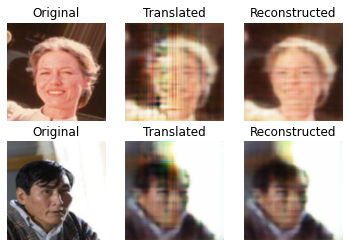

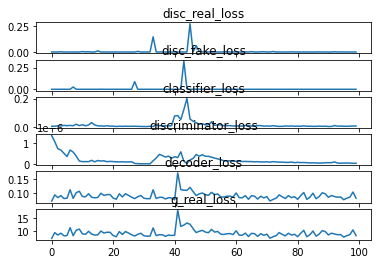

Train 0 / 100:   2%|▏         | 100/5086 [14:36<45:06:46, 32.57s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6751e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3612e-06
Epoch 1/1
32/32 [==============================] - 6s 178ms/step - loss: 8.1239 - classifier_loss: 0.0075 - discriminator_loss: 6.2362e-08 - decoder_loss: 0.0805


Train 0 / 100:   2%|▏         | 101/5086 [14:44<34:47:47, 25.13s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7305e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 9.5106 - classifier_loss: 0.0080 - discriminator_loss: 5.2453e-08 - decoder_loss: 0.0943


Train 0 / 100:   2%|▏         | 102/5086 [14:51<27:33:03, 19.90s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2398e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9488e-07
Epoch 1/1
32/32 [==============================] - 6s 178ms/step - loss: 8.0147 - classifier_loss: 0.0085 - discriminator_loss: 5.2111e-08 - decoder_loss: 0.0793


Train 0 / 100:   2%|▏         | 103/5086 [14:59<22:31:34, 16.27s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6664e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.2797e-05
Epoch 1/1
32/32 [==============================] - 6s 178ms/step - loss: 8.7006 - classifier_loss: 0.0071 - discriminator_loss: 5.5726e-08 - decoder_loss: 0.0863


Train 0 / 100:   2%|▏         | 104/5086 [15:07<18:53:36, 13.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6322e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1986e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.4829 - classifier_loss: 0.0077 - discriminator_loss: 5.2343e-08 - decoder_loss: 0.0841


Train 0 / 100:   2%|▏         | 105/5086 [15:14<16:22:13, 11.83s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0014e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3447e-07
Epoch 1/1
32/32 [==============================] - 6s 178ms/step - loss: 9.2545 - classifier_loss: 0.0063 - discriminator_loss: 5.5478e-08 - decoder_loss: 0.0919


Train 0 / 100:   2%|▏         | 106/5086 [15:22<14:34:26, 10.54s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8120e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9195e-06
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.9581 - classifier_loss: 0.0066 - discriminator_loss: 5.6558e-08 - decoder_loss: 0.0889


Train 0 / 100:   2%|▏         | 107/5086 [15:29<13:20:29,  9.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4481e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4172e-06
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.5509 - classifier_loss: 0.0057 - discriminator_loss: 5.7484e-08 - decoder_loss: 0.0849


Train 0 / 100:   2%|▏         | 108/5086 [15:37<12:28:29,  9.02s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4964e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4213e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 10.4050 - classifier_loss: 0.0094 - discriminator_loss: 4.6593e-08 - decoder_loss: 0.1031


Train 0 / 100:   2%|▏         | 109/5086 [15:45<11:53:15,  8.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2090e-05
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.7943e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9780 - classifier_loss: 0.0083 - discriminator_loss: 4.9762e-08 - decoder_loss: 0.0789


Train 0 / 100:   2%|▏         | 110/5086 [15:52<11:26:54,  8.28s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4181e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.6591 - classifier_loss: 0.0095 - discriminator_loss: 4.4469e-08 - decoder_loss: 0.0856


Train 0 / 100:   2%|▏         | 111/5086 [16:00<11:10:13,  8.08s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1870e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5675e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.9774 - classifier_loss: 0.0077 - discriminator_loss: 3.4926e-08 - decoder_loss: 0.0890


Train 0 / 100:   2%|▏         | 112/5086 [16:07<10:57:39,  7.93s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3669e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0187e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 9.3560 - classifier_loss: 0.0083 - discriminator_loss: 3.2316e-08 - decoder_loss: 0.0927


Train 0 / 100:   2%|▏         | 113/5086 [16:15<10:48:09,  7.82s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7958e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7566e-07
Epoch 1/1
32/32 [==============================] - 6s 178ms/step - loss: 8.3957 - classifier_loss: 0.0137 - discriminator_loss: 3.9349e-08 - decoder_loss: 0.0826


Train 0 / 100:   2%|▏         | 114/5086 [16:22<10:41:13,  7.74s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9752e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6011 - classifier_loss: 0.0090 - discriminator_loss: 3.6044e-08 - decoder_loss: 0.0851


Train 0 / 100:   2%|▏         | 115/5086 [16:30<10:38:07,  7.70s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3742e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1936e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 10.1360 - classifier_loss: 0.0073 - discriminator_loss: 4.5433e-08 - decoder_loss: 0.1006


Train 0 / 100:   2%|▏         | 116/5086 [16:38<10:34:49,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9300e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4618e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.1131 - classifier_loss: 0.0085 - discriminator_loss: 4.9477e-08 - decoder_loss: 0.0803


Train 0 / 100:   2%|▏         | 117/5086 [16:45<10:32:03,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.2036e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.5609 - classifier_loss: 0.0104 - discriminator_loss: 1.1755e-07 - decoder_loss: 0.0946


Train 0 / 100:   2%|▏         | 118/5086 [16:53<10:31:20,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0303e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4581e-05
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.3162 - classifier_loss: 0.0074 - discriminator_loss: 1.2541e-07 - decoder_loss: 0.0824


Train 0 / 100:   2%|▏         | 119/5086 [17:00<10:29:19,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5313e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6875e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.7496 - classifier_loss: 0.0087 - discriminator_loss: 1.2085e-07 - decoder_loss: 0.0866


Train 0 / 100:   2%|▏         | 120/5086 [17:08<10:31:51,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4679e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8251e-05
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.5126 - classifier_loss: 0.0062 - discriminator_loss: 9.5856e-08 - decoder_loss: 0.0745


Train 0 / 100:   2%|▏         | 121/5086 [17:16<10:31:05,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8045e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5938e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.1159 - classifier_loss: 0.0080 - discriminator_loss: 6.8791e-08 - decoder_loss: 0.0904


Train 0 / 100:   2%|▏         | 122/5086 [17:23<10:29:23,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8072e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9642e-04
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.1127 - classifier_loss: 0.0070 - discriminator_loss: 6.4612e-08 - decoder_loss: 0.0804


Train 0 / 100:   2%|▏         | 123/5086 [17:31<10:28:14,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3240e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2098e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.4655 - classifier_loss: 0.0057 - discriminator_loss: 5.6582e-08 - decoder_loss: 0.0741


Train 0 / 100:   2%|▏         | 124/5086 [17:38<10:29:54,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4210e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1469e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0756 - classifier_loss: 0.0079 - discriminator_loss: 5.9754e-08 - decoder_loss: 0.0800


Train 0 / 100:   2%|▏         | 125/5086 [17:46<10:29:05,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0476e-05
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.2930e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8054 - classifier_loss: 0.0069 - discriminator_loss: 5.3047e-08 - decoder_loss: 0.0774


Train 0 / 100:   2%|▏         | 126/5086 [17:54<10:27:53,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9608e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2116e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 9.1706 - classifier_loss: 0.0064 - discriminator_loss: 5.7164e-08 - decoder_loss: 0.0911


Train 0 / 100:   2%|▏         | 127/5086 [18:01<10:29:21,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7608e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3937e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.0484 - classifier_loss: 0.0059 - discriminator_loss: 5.0807e-08 - decoder_loss: 0.0999


Train 0 / 100:   3%|▎         | 128/5086 [18:09<10:30:13,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0111e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4739e-06
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.6981 - classifier_loss: 0.0070 - discriminator_loss: 5.2885e-08 - decoder_loss: 0.0863


Train 0 / 100:   3%|▎         | 129/5086 [18:16<10:28:28,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0047e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.6862e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.5590 - classifier_loss: 0.0062 - discriminator_loss: 4.9367e-08 - decoder_loss: 0.0950


Train 0 / 100:   3%|▎         | 130/5086 [18:24<10:28:43,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0764e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9808e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4735 - classifier_loss: 0.0062 - discriminator_loss: 5.1042e-08 - decoder_loss: 0.0841


Train 0 / 100:   3%|▎         | 131/5086 [18:32<10:28:03,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4434e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5493e-06
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 10.6379 - classifier_loss: 0.0074 - discriminator_loss: 5.7401e-08 - decoder_loss: 0.1056


Train 0 / 100:   3%|▎         | 132/5086 [18:39<10:27:05,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7785e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8821e-06
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.6038 - classifier_loss: 0.0072 - discriminator_loss: 4.9880e-08 - decoder_loss: 0.0853


Train 0 / 100:   3%|▎         | 133/5086 [18:47<10:30:35,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7207e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5275e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.0226 - classifier_loss: 0.0069 - discriminator_loss: 4.4469e-08 - decoder_loss: 0.0895


Train 0 / 100:   3%|▎         | 134/5086 [18:55<10:30:17,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4348e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1146e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4315 - classifier_loss: 0.0073 - discriminator_loss: 4.3442e-08 - decoder_loss: 0.0836


Train 0 / 100:   3%|▎         | 135/5086 [19:02<10:28:44,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6056e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3962e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 10.9089 - classifier_loss: 0.0081 - discriminator_loss: 4.8232e-08 - decoder_loss: 0.1083


Train 0 / 100:   3%|▎         | 136/5086 [19:10<10:27:07,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6053e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7982e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3002 - classifier_loss: 0.0082 - discriminator_loss: 3.9206e-08 - decoder_loss: 0.0822


Train 0 / 100:   3%|▎         | 137/5086 [19:17<10:26:26,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3661e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8223e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.8319 - classifier_loss: 0.0108 - discriminator_loss: 4.0975e-08 - decoder_loss: 0.0872


Train 0 / 100:   3%|▎         | 138/5086 [19:25<10:27:08,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8900e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8905e-06
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 9.0350 - classifier_loss: 0.0099 - discriminator_loss: 4.0440e-08 - decoder_loss: 0.0894


Train 0 / 100:   3%|▎         | 139/5086 [19:33<10:29:47,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4157e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3950e-06
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.0707 - classifier_loss: 0.0092 - discriminator_loss: 3.2563e-08 - decoder_loss: 0.0798


Train 0 / 100:   3%|▎         | 140/5086 [19:40<10:27:32,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3049e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6833e-05
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.2087 - classifier_loss: 0.0072 - discriminator_loss: 3.7038e-08 - decoder_loss: 0.0814


Train 0 / 100:   3%|▎         | 141/5086 [19:48<10:26:01,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7614e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0183e-06
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.3979 - classifier_loss: 0.0086 - discriminator_loss: 3.2171e-08 - decoder_loss: 0.0731


Train 0 / 100:   3%|▎         | 142/5086 [19:55<10:25:08,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9385e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0744e-06
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.3627 - classifier_loss: 0.0075 - discriminator_loss: 3.2112e-08 - decoder_loss: 0.0829


Train 0 / 100:   3%|▎         | 143/5086 [20:03<10:24:10,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0728e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0555e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1057 - classifier_loss: 0.0065 - discriminator_loss: 2.8115e-08 - decoder_loss: 0.0804


Train 0 / 100:   3%|▎         | 144/5086 [20:10<10:24:23,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6185e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1167e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.9121 - classifier_loss: 0.0065 - discriminator_loss: 3.0048e-08 - decoder_loss: 0.0885


Train 0 / 100:   3%|▎         | 145/5086 [20:18<10:26:02,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3010e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 4.2283e-06
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.1986 - classifier_loss: 0.0070 - discriminator_loss: 3.4765e-08 - decoder_loss: 0.0813


Train 0 / 100:   3%|▎         | 146/5086 [20:26<10:28:03,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7422e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8419e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4524 - classifier_loss: 0.0061 - discriminator_loss: 3.6840e-08 - decoder_loss: 0.0739


Train 0 / 100:   3%|▎         | 147/5086 [20:33<10:27:00,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3518e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2421e-06
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.7546 - classifier_loss: 0.0059 - discriminator_loss: 3.3791e-08 - decoder_loss: 0.0770


Train 0 / 100:   3%|▎         | 148/5086 [20:41<10:25:08,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1023e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3226e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.2432 - classifier_loss: 0.0093 - discriminator_loss: 3.2905e-08 - decoder_loss: 0.0915


Train 0 / 100:   3%|▎         | 149/5086 [20:49<10:26:32,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9596e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1023e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 9.3139 - classifier_loss: 0.0075 - discriminator_loss: 3.2800e-08 - decoder_loss: 0.0924


Train 0 / 100:   3%|▎         | 150/5086 [20:56<10:28:53,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6098e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0167e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0216 - classifier_loss: 0.0073 - discriminator_loss: 3.3628e-08 - decoder_loss: 0.0795


Train 0 / 100:   3%|▎         | 151/5086 [21:04<10:28:03,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9435e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3650e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1801 - classifier_loss: 0.0064 - discriminator_loss: 3.6485e-08 - decoder_loss: 0.0812


Train 0 / 100:   3%|▎         | 152/5086 [21:12<10:26:46,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1573e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5129e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.0522 - classifier_loss: 0.0057 - discriminator_loss: 3.1189e-08 - decoder_loss: 0.0800


Train 0 / 100:   3%|▎         | 153/5086 [21:19<10:28:37,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0213e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9629e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2553 - classifier_loss: 0.0085 - discriminator_loss: 3.1667e-08 - decoder_loss: 0.0817


Train 0 / 100:   3%|▎         | 154/5086 [21:27<10:28:10,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0095e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.0033e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2572 - classifier_loss: 0.0064 - discriminator_loss: 3.3187e-08 - decoder_loss: 0.0819


Train 0 / 100:   3%|▎         | 155/5086 [21:35<10:27:57,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1892e-04
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5948 - classifier_loss: 0.0058 - discriminator_loss: 3.7758e-08 - decoder_loss: 0.0854


Train 0 / 100:   3%|▎         | 156/5086 [21:42<10:27:50,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 7ms/step - loss: 4.1441e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6693e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.2900 - classifier_loss: 0.0072 - discriminator_loss: 3.3223e-08 - decoder_loss: 0.0822


Train 0 / 100:   3%|▎         | 157/5086 [21:50<10:29:29,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0372e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.2638e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.1053 - classifier_loss: 0.0069 - discriminator_loss: 2.8798e-08 - decoder_loss: 0.0804


Train 0 / 100:   3%|▎         | 158/5086 [21:58<10:28:42,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7631e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6411e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.1668 - classifier_loss: 0.0074 - discriminator_loss: 2.9859e-08 - decoder_loss: 0.0909


Train 0 / 100:   3%|▎         | 159/5086 [22:05<10:27:48,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2843e-05
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.3577e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1676 - classifier_loss: 0.0064 - discriminator_loss: 2.8399e-08 - decoder_loss: 0.0810


Train 0 / 100:   3%|▎         | 160/5086 [22:13<10:25:57,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9626e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4542e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.1132 - classifier_loss: 0.0067 - discriminator_loss: 2.9669e-08 - decoder_loss: 0.0805


Train 0 / 100:   3%|▎         | 161/5086 [22:20<10:27:34,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4225e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6878e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3047 - classifier_loss: 0.0054 - discriminator_loss: 3.0203e-08 - decoder_loss: 0.0825


Train 0 / 100:   3%|▎         | 162/5086 [22:28<10:26:29,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4988e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5864e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4271 - classifier_loss: 0.0068 - discriminator_loss: 4.0003e-08 - decoder_loss: 0.0836


Train 0 / 100:   3%|▎         | 163/5086 [22:36<10:24:58,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5297e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7634e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 11.1232 - classifier_loss: 0.0154 - discriminator_loss: 3.0790e-08 - decoder_loss: 0.1097


Train 0 / 100:   3%|▎         | 164/5086 [22:43<10:25:24,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5235e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1668e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7348 - classifier_loss: 0.0115 - discriminator_loss: 2.4118e-08 - decoder_loss: 0.0862


Train 0 / 100:   3%|▎         | 165/5086 [22:51<10:25:06,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8250e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3102e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.2878 - classifier_loss: 0.0079 - discriminator_loss: 1.7629e-08 - decoder_loss: 0.0921


Train 0 / 100:   3%|▎         | 166/5086 [22:58<10:24:37,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0160
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5998e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.0630 - classifier_loss: 0.0075 - discriminator_loss: 5.9975e-08 - decoder_loss: 0.0899


Train 0 / 100:   3%|▎         | 167/5086 [23:06<10:23:59,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7159e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2373e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.6178 - classifier_loss: 0.0101 - discriminator_loss: 1.0242e-07 - decoder_loss: 0.1052


Train 0 / 100:   3%|▎         | 168/5086 [23:14<10:24:44,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.7366e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 9.1969 - classifier_loss: 0.0178 - discriminator_loss: 4.1868e-08 - decoder_loss: 0.0902


Train 0 / 100:   3%|▎         | 169/5086 [23:21<10:26:22,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2244e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4846e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4284 - classifier_loss: 0.0138 - discriminator_loss: 1.7591e-08 - decoder_loss: 0.0829


Train 0 / 100:   3%|▎         | 170/5086 [23:29<10:25:48,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1695e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5106e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9738 - classifier_loss: 0.0083 - discriminator_loss: 1.7010e-08 - decoder_loss: 0.0789


Train 0 / 100:   3%|▎         | 171/5086 [23:37<10:25:37,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6554e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8500e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1305 - classifier_loss: 0.0123 - discriminator_loss: 1.7594e-08 - decoder_loss: 0.0801


Train 0 / 100:   3%|▎         | 172/5086 [23:44<10:25:01,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7141e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6958e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.0506 - classifier_loss: 0.0072 - discriminator_loss: 1.8198e-08 - decoder_loss: 0.0898


Train 0 / 100:   3%|▎         | 173/5086 [23:52<10:24:04,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3765e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0827e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5220 - classifier_loss: 0.0103 - discriminator_loss: 1.5706e-08 - decoder_loss: 0.0842


Train 0 / 100:   3%|▎         | 174/5086 [24:00<10:24:55,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9640e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2281e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 10.6651 - classifier_loss: 0.0090 - discriminator_loss: 1.8939e-08 - decoder_loss: 0.1058


Train 0 / 100:   3%|▎         | 175/5086 [24:07<10:24:47,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6237e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8171e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.3324 - classifier_loss: 0.0083 - discriminator_loss: 2.2291e-08 - decoder_loss: 0.0925


Train 0 / 100:   3%|▎         | 176/5086 [24:15<10:24:32,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3893e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3967e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0805 - classifier_loss: 0.0067 - discriminator_loss: 1.9366e-08 - decoder_loss: 0.0801


Train 0 / 100:   3%|▎         | 177/5086 [24:22<10:24:34,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4866e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 9.4459e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2903 - classifier_loss: 0.0069 - discriminator_loss: 1.6087e-08 - decoder_loss: 0.0822


Train 0 / 100:   3%|▎         | 178/5086 [24:30<10:24:22,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4441e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5610e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0617 - classifier_loss: 0.0084 - discriminator_loss: 1.9171e-08 - decoder_loss: 0.0798


Train 0 / 100:   4%|▎         | 179/5086 [24:38<10:24:54,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5250e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.3346 - classifier_loss: 0.0070 - discriminator_loss: 8.5968e-09 - decoder_loss: 0.1026


Train 0 / 100:   4%|▎         | 180/5086 [24:45<10:24:22,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6592e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8900e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2912 - classifier_loss: 0.0062 - discriminator_loss: 5.1757e-09 - decoder_loss: 0.0823


Train 0 / 100:   4%|▎         | 181/5086 [24:53<10:23:13,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9335e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0059e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3761 - classifier_loss: 0.0077 - discriminator_loss: 4.9626e-09 - decoder_loss: 0.0830


Train 0 / 100:   4%|▎         | 182/5086 [25:01<10:22:43,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6823e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1044e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4356 - classifier_loss: 0.0057 - discriminator_loss: 4.3357e-09 - decoder_loss: 0.0838


Train 0 / 100:   4%|▎         | 183/5086 [25:08<10:21:25,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9974e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6426e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.6357 - classifier_loss: 0.0083 - discriminator_loss: 5.0613e-09 - decoder_loss: 0.0855


Train 0 / 100:   4%|▎         | 184/5086 [25:16<10:23:13,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2366e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1525e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.8351 - classifier_loss: 0.0081 - discriminator_loss: 3.8819e-09 - decoder_loss: 0.0875


Train 0 / 100:   4%|▎         | 185/5086 [25:23<10:22:22,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2412e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7399e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.9855 - classifier_loss: 0.0072 - discriminator_loss: 4.0222e-09 - decoder_loss: 0.0891


Train 0 / 100:   4%|▎         | 186/5086 [25:31<10:23:00,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3714e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9809e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.9670 - classifier_loss: 0.0070 - discriminator_loss: 4.9061e-09 - decoder_loss: 0.0990


Train 0 / 100:   4%|▎         | 187/5086 [25:39<10:21:28,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3874e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8722e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 9.3961 - classifier_loss: 0.0067 - discriminator_loss: 4.7740e-09 - decoder_loss: 0.0933


Train 0 / 100:   4%|▎         | 188/5086 [25:46<10:22:45,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2287e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8550e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 9.5159 - classifier_loss: 0.0082 - discriminator_loss: 4.8025e-09 - decoder_loss: 0.0943


Train 0 / 100:   4%|▎         | 189/5086 [25:54<10:24:18,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4442e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7864e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7707 - classifier_loss: 0.0072 - discriminator_loss: 4.8822e-09 - decoder_loss: 0.0870


Train 0 / 100:   4%|▎         | 190/5086 [26:02<10:22:59,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7344e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1731e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2355 - classifier_loss: 0.0080 - discriminator_loss: 4.2838e-09 - decoder_loss: 0.0816


Train 0 / 100:   4%|▍         | 191/5086 [26:09<10:22:46,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1795e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3673e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6982 - classifier_loss: 0.0063 - discriminator_loss: 4.2262e-09 - decoder_loss: 0.0764


Train 0 / 100:   4%|▍         | 192/5086 [26:17<10:22:17,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9476e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.3825e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8862 - classifier_loss: 0.0060 - discriminator_loss: 4.1779e-09 - decoder_loss: 0.0783


Train 0 / 100:   4%|▍         | 193/5086 [26:24<10:22:16,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9363e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2956e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6703 - classifier_loss: 0.0106 - discriminator_loss: 4.9119e-09 - decoder_loss: 0.0856


Train 0 / 100:   4%|▍         | 194/5086 [26:32<10:21:39,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8374e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0590e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.9043 - classifier_loss: 0.0078 - discriminator_loss: 4.3027e-09 - decoder_loss: 0.0883


Train 0 / 100:   4%|▍         | 195/5086 [26:40<10:22:07,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1945e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1148e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.7568 - classifier_loss: 0.0089 - discriminator_loss: 4.6028e-09 - decoder_loss: 0.0867


Train 0 / 100:   4%|▍         | 196/5086 [26:47<10:22:26,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9748e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7958e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.0907 - classifier_loss: 0.0085 - discriminator_loss: 4.5817e-09 - decoder_loss: 0.0901


Train 0 / 100:   4%|▍         | 197/5086 [26:55<10:22:13,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5428e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3695e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.7033 - classifier_loss: 0.0092 - discriminator_loss: 4.5848e-09 - decoder_loss: 0.0861


Train 0 / 100:   4%|▍         | 198/5086 [27:03<10:20:51,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8274e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9404e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4928 - classifier_loss: 0.0062 - discriminator_loss: 4.4983e-09 - decoder_loss: 0.0843


Train 0 / 100:   4%|▍         | 199/5086 [27:10<10:20:50,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7719e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6329e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.5697 - classifier_loss: 0.0134 - discriminator_loss: 4.7089e-09 - decoder_loss: 0.0844
Epoch: 0 with batch: 199


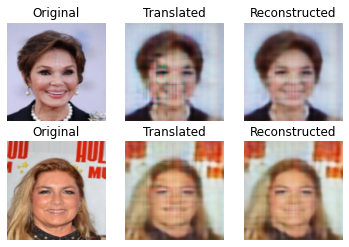

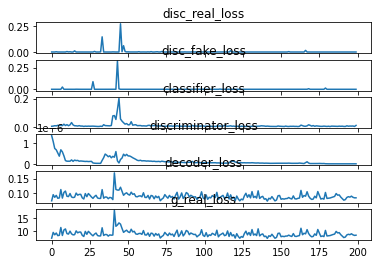

Train 0 / 100:   4%|▍         | 200/5086 [28:16<33:56:07, 25.00s/it]

Epoch 1/1
32/32 [==============================] - 0s 7ms/step - loss: 3.8069e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7385e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 9.8233 - classifier_loss: 0.0072 - discriminator_loss: 4.7976e-09 - decoder_loss: 0.0975


Train 0 / 100:   4%|▍         | 201/5086 [28:24<26:53:56, 19.82s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8697e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.3676 - classifier_loss: 0.0098 - discriminator_loss: 4.7826e-09 - decoder_loss: 0.0827


Train 0 / 100:   4%|▍         | 202/5086 [28:31<21:59:27, 16.21s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0557e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1615e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0439 - classifier_loss: 0.0102 - discriminator_loss: 4.2405e-09 - decoder_loss: 0.0794


Train 0 / 100:   4%|▍         | 203/5086 [28:39<18:34:50, 13.70s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8980e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2017e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.4227 - classifier_loss: 0.0070 - discriminator_loss: 4.6010e-09 - decoder_loss: 0.0935


Train 0 / 100:   4%|▍         | 204/5086 [28:47<16:05:54, 11.87s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1404e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6631e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.5028 - classifier_loss: 0.0061 - discriminator_loss: 6.0521e-09 - decoder_loss: 0.0844


Train 0 / 100:   4%|▍         | 205/5086 [28:54<14:21:01, 10.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.6809e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0615e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.0953 - classifier_loss: 0.0086 - discriminator_loss: 4.7879e-09 - decoder_loss: 0.0801


Train 0 / 100:   4%|▍         | 206/5086 [29:02<13:06:36,  9.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2900e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.9578e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.9909 - classifier_loss: 0.0055 - discriminator_loss: 5.7584e-09 - decoder_loss: 0.0894


Train 0 / 100:   4%|▍         | 207/5086 [29:09<12:15:55,  9.05s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5066e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3225e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8916 - classifier_loss: 0.0079 - discriminator_loss: 4.7683e-09 - decoder_loss: 0.0781


Train 0 / 100:   4%|▍         | 208/5086 [29:17<11:39:55,  8.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1500e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8750e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8925 - classifier_loss: 0.0068 - discriminator_loss: 4.4121e-09 - decoder_loss: 0.0782


Train 0 / 100:   4%|▍         | 209/5086 [29:25<11:14:33,  8.30s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1755e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9314e-08
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.3278 - classifier_loss: 0.0074 - discriminator_loss: 4.7430e-09 - decoder_loss: 0.0825


Train 0 / 100:   4%|▍         | 210/5086 [29:32<11:00:34,  8.13s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7250e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5835e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9780 - classifier_loss: 0.0058 - discriminator_loss: 4.5530e-09 - decoder_loss: 0.0792


Train 0 / 100:   4%|▍         | 211/5086 [29:40<10:46:45,  7.96s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2333e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7397e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7495 - classifier_loss: 0.0095 - discriminator_loss: 5.1329e-09 - decoder_loss: 0.0765


Train 0 / 100:   4%|▍         | 212/5086 [29:48<10:39:15,  7.87s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0747e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4223e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.4780 - classifier_loss: 0.0071 - discriminator_loss: 3.9626e-09 - decoder_loss: 0.0841


Train 0 / 100:   4%|▍         | 213/5086 [29:55<10:34:27,  7.81s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4650e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5011e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4412 - classifier_loss: 0.0073 - discriminator_loss: 4.1258e-09 - decoder_loss: 0.0837


Train 0 / 100:   4%|▍         | 214/5086 [30:03<10:28:41,  7.74s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0336e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7769e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7898 - classifier_loss: 0.0064 - discriminator_loss: 4.3295e-09 - decoder_loss: 0.0873


Train 0 / 100:   4%|▍         | 215/5086 [30:10<10:24:20,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2299e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6959e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5848 - classifier_loss: 0.0059 - discriminator_loss: 4.0336e-09 - decoder_loss: 0.0853


Train 0 / 100:   4%|▍         | 216/5086 [30:18<10:23:13,  7.68s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8502e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1640e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.5791 - classifier_loss: 0.0059 - discriminator_loss: 4.4784e-09 - decoder_loss: 0.1052


Train 0 / 100:   4%|▍         | 217/5086 [30:26<10:21:22,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5890e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6154e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.0102 - classifier_loss: 0.0072 - discriminator_loss: 4.7927e-09 - decoder_loss: 0.0894


Train 0 / 100:   4%|▍         | 218/5086 [30:33<10:20:03,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2348e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5143e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 11.3961 - classifier_loss: 0.0065 - discriminator_loss: 4.3936e-09 - decoder_loss: 0.1133


Train 0 / 100:   4%|▍         | 219/5086 [30:41<10:21:35,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4005e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9810e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2317 - classifier_loss: 0.0066 - discriminator_loss: 3.9494e-09 - decoder_loss: 0.0817


Train 0 / 100:   4%|▍         | 220/5086 [30:49<10:20:08,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2892e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 4.1729e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 11.7669 - classifier_loss: 0.0371 - discriminator_loss: 4.8399e-09 - decoder_loss: 0.1140


Train 0 / 100:   4%|▍         | 221/5086 [30:56<10:17:54,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8873e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3893e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.9585 - classifier_loss: 0.0155 - discriminator_loss: 4.4386e-09 - decoder_loss: 0.0980


Train 0 / 100:   4%|▍         | 222/5086 [31:04<10:16:40,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8885e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1748e-09
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.6172 - classifier_loss: 0.0158 - discriminator_loss: 3.7786e-09 - decoder_loss: 0.0846


Train 0 / 100:   4%|▍         | 223/5086 [31:11<10:18:26,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4312e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.5159e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4184 - classifier_loss: 0.0141 - discriminator_loss: 3.9352e-09 - decoder_loss: 0.0828


Train 0 / 100:   4%|▍         | 224/5086 [31:19<10:17:21,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7769e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2530e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.3357 - classifier_loss: 0.0096 - discriminator_loss: 4.3035e-09 - decoder_loss: 0.0924


Train 0 / 100:   4%|▍         | 225/5086 [31:27<10:16:29,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3152e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4004e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6307 - classifier_loss: 0.0099 - discriminator_loss: 4.3312e-09 - decoder_loss: 0.0853


Train 0 / 100:   4%|▍         | 226/5086 [31:34<10:16:18,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4904e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0948e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.7644 - classifier_loss: 0.0123 - discriminator_loss: 4.2907e-09 - decoder_loss: 0.0964


Train 0 / 100:   4%|▍         | 227/5086 [31:42<10:17:40,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3718e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3260e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7061 - classifier_loss: 0.0088 - discriminator_loss: 4.7599e-09 - decoder_loss: 0.0862


Train 0 / 100:   4%|▍         | 228/5086 [31:49<10:17:33,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8907e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4654e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4415 - classifier_loss: 0.0086 - discriminator_loss: 4.9141e-09 - decoder_loss: 0.0836


Train 0 / 100:   5%|▍         | 229/5086 [31:57<10:17:27,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7648e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5298e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.9839 - classifier_loss: 0.0084 - discriminator_loss: 5.3428e-09 - decoder_loss: 0.0890


Train 0 / 100:   5%|▍         | 230/5086 [32:05<10:16:39,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4653e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8911e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.8791 - classifier_loss: 0.0130 - discriminator_loss: 5.5156e-09 - decoder_loss: 0.0875


Train 0 / 100:   5%|▍         | 231/5086 [32:12<10:15:53,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8510e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9329e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.1545 - classifier_loss: 0.0122 - discriminator_loss: 5.1191e-09 - decoder_loss: 0.0803


Train 0 / 100:   5%|▍         | 232/5086 [32:20<10:16:07,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5839e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9678e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.9585 - classifier_loss: 0.0106 - discriminator_loss: 5.3488e-09 - decoder_loss: 0.0885


Train 0 / 100:   5%|▍         | 233/5086 [32:28<10:18:00,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0092e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2942e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2704 - classifier_loss: 0.0089 - discriminator_loss: 5.3289e-09 - decoder_loss: 0.0818


Train 0 / 100:   5%|▍         | 234/5086 [32:35<10:17:20,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0002e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6485e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4725 - classifier_loss: 0.0082 - discriminator_loss: 5.4645e-09 - decoder_loss: 0.0839


Train 0 / 100:   5%|▍         | 235/5086 [32:43<10:17:20,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3473e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8519e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6616 - classifier_loss: 0.0090 - discriminator_loss: 4.7902e-09 - decoder_loss: 0.0757


Train 0 / 100:   5%|▍         | 236/5086 [32:50<10:15:38,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5910e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6863e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.6702 - classifier_loss: 0.0084 - discriminator_loss: 4.9439e-09 - decoder_loss: 0.0959


Train 0 / 100:   5%|▍         | 237/5086 [32:58<10:15:42,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0153
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9589e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.0533 - classifier_loss: 0.0070 - discriminator_loss: 1.9582e-08 - decoder_loss: 0.0898


Train 0 / 100:   5%|▍         | 238/5086 [33:06<10:16:11,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2054e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.1340
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0398 - classifier_loss: 0.0071 - discriminator_loss: 7.1083e-09 - decoder_loss: 0.0797


Train 0 / 100:   5%|▍         | 239/5086 [33:13<10:15:13,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8006e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3189e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2226 - classifier_loss: 0.0056 - discriminator_loss: 5.2570e-09 - decoder_loss: 0.0817


Train 0 / 100:   5%|▍         | 240/5086 [33:21<10:15:50,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8495e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5223e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.3308 - classifier_loss: 0.0082 - discriminator_loss: 5.0415e-09 - decoder_loss: 0.0925


Train 0 / 100:   5%|▍         | 241/5086 [33:29<10:15:21,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8500e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2741e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0966 - classifier_loss: 0.0055 - discriminator_loss: 4.5468e-09 - decoder_loss: 0.0804


Train 0 / 100:   5%|▍         | 242/5086 [33:36<10:14:17,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1147e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7204e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7972 - classifier_loss: 0.0057 - discriminator_loss: 4.2679e-09 - decoder_loss: 0.0774


Train 0 / 100:   5%|▍         | 243/5086 [33:44<10:13:56,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3569e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2763e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.4031 - classifier_loss: 0.0082 - discriminator_loss: 5.1252e-09 - decoder_loss: 0.0932


Train 0 / 100:   5%|▍         | 244/5086 [33:51<10:14:23,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7910e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5184e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4794 - classifier_loss: 0.0070 - discriminator_loss: 5.3672e-09 - decoder_loss: 0.0741


Train 0 / 100:   5%|▍         | 245/5086 [33:59<10:14:16,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0079
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9099e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9866 - classifier_loss: 0.0060 - discriminator_loss: 6.1947e-09 - decoder_loss: 0.0793


Train 0 / 100:   5%|▍         | 246/5086 [34:07<10:13:38,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5996e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5451e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3716 - classifier_loss: 0.0066 - discriminator_loss: 5.6751e-09 - decoder_loss: 0.0831


Train 0 / 100:   5%|▍         | 247/5086 [34:14<10:13:04,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2743e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1393e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.9361 - classifier_loss: 0.0064 - discriminator_loss: 5.5205e-09 - decoder_loss: 0.0887


Train 0 / 100:   5%|▍         | 248/5086 [34:22<10:13:08,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0791e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4352e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3635 - classifier_loss: 0.0059 - discriminator_loss: 5.7098e-09 - decoder_loss: 0.0830


Train 0 / 100:   5%|▍         | 249/5086 [34:29<10:12:13,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7110e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1063e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.1460 - classifier_loss: 0.0057 - discriminator_loss: 5.9652e-09 - decoder_loss: 0.0809


Train 0 / 100:   5%|▍         | 250/5086 [34:37<10:13:33,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4152e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7962e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.1809 - classifier_loss: 0.0068 - discriminator_loss: 5.3251e-09 - decoder_loss: 0.1011


Train 0 / 100:   5%|▍         | 251/5086 [34:45<10:13:21,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3893e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6254e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0541 - classifier_loss: 0.0061 - discriminator_loss: 5.6507e-09 - decoder_loss: 0.0799


Train 0 / 100:   5%|▍         | 252/5086 [34:52<10:13:55,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0079
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7748e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.7934 - classifier_loss: 0.0069 - discriminator_loss: 6.5707e-09 - decoder_loss: 0.0972


Train 0 / 100:   5%|▍         | 253/5086 [35:00<10:14:08,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2600e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3592e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5458 - classifier_loss: 0.0059 - discriminator_loss: 6.5077e-09 - decoder_loss: 0.0849


Train 0 / 100:   5%|▍         | 254/5086 [35:08<10:14:14,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0653
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.5115 - classifier_loss: 0.0051 - discriminator_loss: 3.7946e-09 - decoder_loss: 0.0846


Train 0 / 100:   5%|▌         | 255/5086 [35:15<10:13:14,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1708e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0976e-09
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.7728 - classifier_loss: 0.0075 - discriminator_loss: 3.2273e-09 - decoder_loss: 0.0870


Train 0 / 100:   5%|▌         | 256/5086 [35:23<10:15:11,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8683e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4233e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6262 - classifier_loss: 0.0103 - discriminator_loss: 2.8842e-09 - decoder_loss: 0.0852


Train 0 / 100:   5%|▌         | 257/5086 [35:30<10:13:41,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8939e-09
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.4687 - classifier_loss: 0.0156 - discriminator_loss: 2.9198e-09 - decoder_loss: 0.0831


Train 0 / 100:   5%|▌         | 258/5086 [35:38<10:15:59,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3896e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2207e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.6059 - classifier_loss: 0.0082 - discriminator_loss: 3.9025e-09 - decoder_loss: 0.0952


Train 0 / 100:   5%|▌         | 259/5086 [35:46<10:14:07,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.6695e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7800e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.9187 - classifier_loss: 0.0091 - discriminator_loss: 4.2165e-09 - decoder_loss: 0.0883


Train 0 / 100:   5%|▌         | 260/5086 [35:53<10:13:18,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4168e-04
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.4336e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7861 - classifier_loss: 0.0104 - discriminator_loss: 3.8786e-09 - decoder_loss: 0.0868


Train 0 / 100:   5%|▌         | 261/5086 [36:01<10:12:20,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7660e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6502e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0091 - classifier_loss: 0.0091 - discriminator_loss: 3.8762e-09 - decoder_loss: 0.0792


Train 0 / 100:   5%|▌         | 262/5086 [36:09<10:11:38,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3458e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.3823e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.3212 - classifier_loss: 0.0070 - discriminator_loss: 4.0630e-09 - decoder_loss: 0.0825


Train 0 / 100:   5%|▌         | 263/5086 [36:16<10:12:26,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.9695e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1702e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.4353 - classifier_loss: 0.0074 - discriminator_loss: 4.1300e-09 - decoder_loss: 0.0936


Train 0 / 100:   5%|▌         | 264/5086 [36:24<10:12:11,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0534
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3404e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5656 - classifier_loss: 0.0062 - discriminator_loss: 1.2412e-08 - decoder_loss: 0.0750


Train 0 / 100:   5%|▌         | 265/5086 [36:31<10:11:38,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3557e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9080e-05
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.7706 - classifier_loss: 0.0072 - discriminator_loss: 2.4210e-08 - decoder_loss: 0.0870


Train 0 / 100:   5%|▌         | 266/5086 [36:39<10:13:02,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8732e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8597e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8969 - classifier_loss: 0.0060 - discriminator_loss: 1.6719e-08 - decoder_loss: 0.0784


Train 0 / 100:   5%|▌         | 267/5086 [36:47<10:12:37,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4106e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6203e-06
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.5685 - classifier_loss: 0.0059 - discriminator_loss: 1.4108e-08 - decoder_loss: 0.0851


Train 0 / 100:   5%|▌         | 268/5086 [36:54<10:14:05,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0447e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3998e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 10.3836 - classifier_loss: 0.0057 - discriminator_loss: 1.4887e-08 - decoder_loss: 0.1033


Train 0 / 100:   5%|▌         | 269/5086 [37:02<10:12:18,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9282e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0868e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.8782 - classifier_loss: 0.0108 - discriminator_loss: 1.7551e-08 - decoder_loss: 0.0777


Train 0 / 100:   5%|▌         | 270/5086 [37:10<10:13:01,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6877e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9133e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0125 - classifier_loss: 0.0062 - discriminator_loss: 1.8332e-08 - decoder_loss: 0.0795


Train 0 / 100:   5%|▌         | 271/5086 [37:17<10:12:30,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4591e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.1694e-05
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.4048 - classifier_loss: 0.0070 - discriminator_loss: 1.6801e-08 - decoder_loss: 0.0833


Train 0 / 100:   5%|▌         | 272/5086 [37:25<10:13:27,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7161e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 5.1446e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5472 - classifier_loss: 0.0066 - discriminator_loss: 1.8887e-08 - decoder_loss: 0.0848


Train 0 / 100:   5%|▌         | 273/5086 [37:33<10:13:26,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4330e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4207e-04
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 9.2151 - classifier_loss: 0.0120 - discriminator_loss: 1.7216e-08 - decoder_loss: 0.0909


Train 0 / 100:   5%|▌         | 274/5086 [37:40<10:14:39,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8813e-09
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4254e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8354 - classifier_loss: 0.0066 - discriminator_loss: 1.1910e-08 - decoder_loss: 0.0777


Train 0 / 100:   5%|▌         | 275/5086 [37:48<10:13:05,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4068e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1116e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.0064 - classifier_loss: 0.0088 - discriminator_loss: 1.2256e-08 - decoder_loss: 0.0892


Train 0 / 100:   5%|▌         | 276/5086 [37:56<10:12:59,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0134e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9124e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.2383 - classifier_loss: 0.0077 - discriminator_loss: 1.4740e-08 - decoder_loss: 0.0916


Train 0 / 100:   5%|▌         | 277/5086 [38:03<10:12:22,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4978e-09
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0539e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.4776 - classifier_loss: 0.0060 - discriminator_loss: 1.4687e-08 - decoder_loss: 0.0942


Train 0 / 100:   5%|▌         | 278/5086 [38:11<10:11:54,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1309e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0231e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8835 - classifier_loss: 0.0060 - discriminator_loss: 1.3959e-08 - decoder_loss: 0.0782


Train 0 / 100:   5%|▌         | 279/5086 [38:18<10:11:00,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6063e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2292e-04
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.2251 - classifier_loss: 0.0063 - discriminator_loss: 1.4374e-08 - decoder_loss: 0.0816


Train 0 / 100:   6%|▌         | 280/5086 [38:26<10:12:11,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5525e-09
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5737e-05
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.7262 - classifier_loss: 0.0068 - discriminator_loss: 1.5449e-08 - decoder_loss: 0.0766


Train 0 / 100:   6%|▌         | 281/5086 [38:34<10:10:11,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4383e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9046e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.6098 - classifier_loss: 0.0062 - discriminator_loss: 1.2486e-08 - decoder_loss: 0.0855


Train 0 / 100:   6%|▌         | 282/5086 [38:41<10:08:32,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9871e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8566e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.2453 - classifier_loss: 0.0052 - discriminator_loss: 1.1346e-08 - decoder_loss: 0.0719


Train 0 / 100:   6%|▌         | 283/5086 [38:49<10:09:35,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1588e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.5630e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2179 - classifier_loss: 0.0067 - discriminator_loss: 1.0515e-08 - decoder_loss: 0.0815


Train 0 / 100:   6%|▌         | 284/5086 [38:56<10:08:21,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5829e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1616e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0613 - classifier_loss: 0.0061 - discriminator_loss: 1.3840e-08 - decoder_loss: 0.0800


Train 0 / 100:   6%|▌         | 285/5086 [39:04<10:09:05,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8937e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7919e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8792 - classifier_loss: 0.0054 - discriminator_loss: 1.2737e-08 - decoder_loss: 0.0782


Train 0 / 100:   6%|▌         | 286/5086 [39:12<10:08:24,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3077e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1705e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1339 - classifier_loss: 0.0074 - discriminator_loss: 1.1695e-08 - decoder_loss: 0.0806


Train 0 / 100:   6%|▌         | 287/5086 [39:19<10:08:30,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9484e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1468e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9948 - classifier_loss: 0.0055 - discriminator_loss: 1.1303e-08 - decoder_loss: 0.0794


Train 0 / 100:   6%|▌         | 288/5086 [39:27<10:08:02,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5289e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 2.5468e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.7156 - classifier_loss: 0.0059 - discriminator_loss: 1.0739e-08 - decoder_loss: 0.0866


Train 0 / 100:   6%|▌         | 289/5086 [39:34<10:07:29,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0086
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.4827e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.6334 - classifier_loss: 0.0050 - discriminator_loss: 1.6633e-08 - decoder_loss: 0.0958


Train 0 / 100:   6%|▌         | 290/5086 [39:42<10:06:15,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0914e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4458e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.7155 - classifier_loss: 0.0072 - discriminator_loss: 2.2021e-08 - decoder_loss: 0.0864


Train 0 / 100:   6%|▌         | 291/5086 [39:50<10:06:48,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4258e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9470e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.6407 - classifier_loss: 0.0061 - discriminator_loss: 2.0549e-08 - decoder_loss: 0.0758


Train 0 / 100:   6%|▌         | 292/5086 [39:57<10:08:30,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0826e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 0.1605
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5033 - classifier_loss: 0.0057 - discriminator_loss: 9.6306e-09 - decoder_loss: 0.0845


Train 0 / 100:   6%|▌         | 293/5086 [40:05<10:08:56,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6238e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1288e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.0438 - classifier_loss: 0.0051 - discriminator_loss: 5.3007e-09 - decoder_loss: 0.0799


Train 0 / 100:   6%|▌         | 294/5086 [40:13<10:10:43,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6942e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8071e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9834 - classifier_loss: 0.0062 - discriminator_loss: 5.3889e-09 - decoder_loss: 0.0792


Train 0 / 100:   6%|▌         | 295/5086 [40:20<10:09:56,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6746e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.6919 - classifier_loss: 0.0049 - discriminator_loss: 6.3510e-09 - decoder_loss: 0.0764


Train 0 / 100:   6%|▌         | 296/5086 [40:28<10:10:38,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6586e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4811e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.2553 - classifier_loss: 0.0049 - discriminator_loss: 7.1727e-09 - decoder_loss: 0.0821


Train 0 / 100:   6%|▌         | 297/5086 [40:35<10:08:08,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0602e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4277e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9560 - classifier_loss: 0.0052 - discriminator_loss: 6.3762e-09 - decoder_loss: 0.0790


Train 0 / 100:   6%|▌         | 298/5086 [40:43<10:07:16,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3217e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8963e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.9439 - classifier_loss: 0.0056 - discriminator_loss: 7.3071e-09 - decoder_loss: 0.0889


Train 0 / 100:   6%|▌         | 299/5086 [40:51<10:07:22,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0243
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.7023 - classifier_loss: 0.0082 - discriminator_loss: 2.1017e-08 - decoder_loss: 0.0862
Epoch: 0 with batch: 299


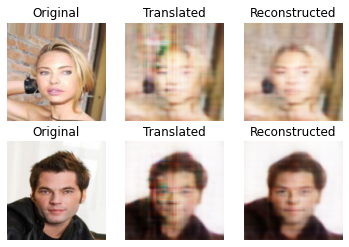

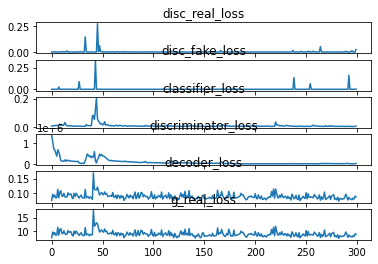

Train 0 / 100:   6%|▌         | 300/5086 [41:58<33:59:23, 25.57s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7866e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.6850 - classifier_loss: 0.0069 - discriminator_loss: 1.1650e-08 - decoder_loss: 0.0862


Train 0 / 100:   6%|▌         | 301/5086 [42:06<26:52:51, 20.22s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8700e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8007e-05
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.2413 - classifier_loss: 0.0050 - discriminator_loss: 7.8094e-09 - decoder_loss: 0.0819


Train 0 / 100:   6%|▌         | 302/5086 [42:13<21:48:44, 16.41s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0149
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6224e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3142 - classifier_loss: 0.0085 - discriminator_loss: 1.2417e-08 - decoder_loss: 0.0823


Train 0 / 100:   6%|▌         | 303/5086 [42:21<18:21:02, 13.81s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3615e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3519e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.5530 - classifier_loss: 0.0064 - discriminator_loss: 1.4102e-08 - decoder_loss: 0.0849


Train 0 / 100:   6%|▌         | 304/5086 [42:29<15:50:52, 11.93s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6511e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5996e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0958 - classifier_loss: 0.0072 - discriminator_loss: 1.6269e-08 - decoder_loss: 0.0802


Train 0 / 100:   6%|▌         | 305/5086 [42:36<14:05:44, 10.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3682e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0833e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2221 - classifier_loss: 0.0076 - discriminator_loss: 1.5843e-08 - decoder_loss: 0.0815


Train 0 / 100:   6%|▌         | 306/5086 [42:44<12:53:26,  9.71s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0170e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4999e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0603 - classifier_loss: 0.0062 - discriminator_loss: 1.8164e-08 - decoder_loss: 0.0800


Train 0 / 100:   6%|▌         | 307/5086 [42:51<12:04:24,  9.09s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6922e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5842e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6904 - classifier_loss: 0.0059 - discriminator_loss: 1.3144e-08 - decoder_loss: 0.0763


Train 0 / 100:   6%|▌         | 308/5086 [42:59<11:27:43,  8.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5347e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7515e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5897 - classifier_loss: 0.0057 - discriminator_loss: 2.2753e-08 - decoder_loss: 0.0753


Train 0 / 100:   6%|▌         | 309/5086 [43:07<11:02:06,  8.32s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0216e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3290e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2412 - classifier_loss: 0.0059 - discriminator_loss: 1.6227e-08 - decoder_loss: 0.0818


Train 0 / 100:   6%|▌         | 310/5086 [43:14<10:44:48,  8.10s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2841e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1885e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8712 - classifier_loss: 0.0063 - discriminator_loss: 1.4404e-08 - decoder_loss: 0.0781


Train 0 / 100:   6%|▌         | 311/5086 [43:22<10:32:15,  7.94s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0715e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8555e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9880 - classifier_loss: 0.0068 - discriminator_loss: 1.7182e-08 - decoder_loss: 0.0792


Train 0 / 100:   6%|▌         | 312/5086 [43:29<10:24:53,  7.85s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9179e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2454e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.6691 - classifier_loss: 0.0062 - discriminator_loss: 1.2930e-08 - decoder_loss: 0.0761


Train 0 / 100:   6%|▌         | 313/5086 [43:37<10:19:28,  7.79s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7569e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0780e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.1295 - classifier_loss: 0.0064 - discriminator_loss: 1.3293e-08 - decoder_loss: 0.0907


Train 0 / 100:   6%|▌         | 314/5086 [43:45<10:14:34,  7.73s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6015e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0386e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7322 - classifier_loss: 0.0057 - discriminator_loss: 1.4227e-08 - decoder_loss: 0.0868


Train 0 / 100:   6%|▌         | 315/5086 [43:52<10:11:24,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2273e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0573e-04
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.4212 - classifier_loss: 0.0065 - discriminator_loss: 1.1366e-08 - decoder_loss: 0.0836


Train 0 / 100:   6%|▌         | 316/5086 [44:00<10:09:07,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0265e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.8486 - classifier_loss: 0.0060 - discriminator_loss: 8.9271e-09 - decoder_loss: 0.0779


Train 0 / 100:   6%|▌         | 317/5086 [44:08<10:09:30,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3580e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5784e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.5969 - classifier_loss: 0.0064 - discriminator_loss: 5.6297e-09 - decoder_loss: 0.0853


Train 0 / 100:   6%|▋         | 318/5086 [44:15<10:08:06,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2198e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0441e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7462 - classifier_loss: 0.0074 - discriminator_loss: 5.0479e-09 - decoder_loss: 0.0767


Train 0 / 100:   6%|▋         | 319/5086 [44:23<10:06:59,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5502e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2701e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.2425 - classifier_loss: 0.0058 - discriminator_loss: 5.4228e-09 - decoder_loss: 0.0918


Train 0 / 100:   6%|▋         | 320/5086 [44:30<10:05:36,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1006e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4129e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7454 - classifier_loss: 0.0066 - discriminator_loss: 7.1334e-09 - decoder_loss: 0.0868


Train 0 / 100:   6%|▋         | 321/5086 [44:38<10:04:09,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5463e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9488e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7373 - classifier_loss: 0.0056 - discriminator_loss: 7.8214e-09 - decoder_loss: 0.0768


Train 0 / 100:   6%|▋         | 322/5086 [44:45<10:03:35,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0260e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2092e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.2762 - classifier_loss: 0.0074 - discriminator_loss: 6.1376e-09 - decoder_loss: 0.0820


Train 0 / 100:   6%|▋         | 323/5086 [44:53<10:05:04,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7744e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9359e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.3490 - classifier_loss: 0.0061 - discriminator_loss: 5.9256e-09 - decoder_loss: 0.0729


Train 0 / 100:   6%|▋         | 324/5086 [45:01<10:06:13,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9385e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4155e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3282 - classifier_loss: 0.0069 - discriminator_loss: 5.3127e-09 - decoder_loss: 0.0826


Train 0 / 100:   6%|▋         | 325/5086 [45:08<10:04:35,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1859e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6448e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2053 - classifier_loss: 0.0058 - discriminator_loss: 4.6754e-09 - decoder_loss: 0.0815


Train 0 / 100:   6%|▋         | 326/5086 [45:16<10:04:05,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3133e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8179e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9934 - classifier_loss: 0.0050 - discriminator_loss: 5.1604e-09 - decoder_loss: 0.0794


Train 0 / 100:   6%|▋         | 327/5086 [45:24<10:03:27,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4646e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9499e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.7486 - classifier_loss: 0.0066 - discriminator_loss: 5.3472e-09 - decoder_loss: 0.0768


Train 0 / 100:   6%|▋         | 328/5086 [45:31<10:04:41,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6563e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0071e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.4962 - classifier_loss: 0.0051 - discriminator_loss: 4.4982e-09 - decoder_loss: 0.0744


Train 0 / 100:   6%|▋         | 329/5086 [45:39<10:04:07,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2732e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8101e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.4134 - classifier_loss: 0.0065 - discriminator_loss: 4.5470e-09 - decoder_loss: 0.0735


Train 0 / 100:   6%|▋         | 330/5086 [45:47<10:04:48,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0134e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0335e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2909 - classifier_loss: 0.0070 - discriminator_loss: 4.7340e-09 - decoder_loss: 0.0822


Train 0 / 100:   7%|▋         | 331/5086 [45:54<10:04:26,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8797e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.6779 - classifier_loss: 0.0062 - discriminator_loss: 3.9633e-09 - decoder_loss: 0.0962


Train 0 / 100:   7%|▋         | 332/5086 [46:02<10:02:48,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3359e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3983e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.2329 - classifier_loss: 0.0059 - discriminator_loss: 3.8490e-09 - decoder_loss: 0.0917


Train 0 / 100:   7%|▋         | 333/5086 [46:09<10:03:30,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0861e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7791e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.8288 - classifier_loss: 0.0063 - discriminator_loss: 4.0794e-09 - decoder_loss: 0.0877


Train 0 / 100:   7%|▋         | 334/5086 [46:17<10:02:52,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9519e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.8489e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.9112 - classifier_loss: 0.0058 - discriminator_loss: 4.1168e-09 - decoder_loss: 0.0785


Train 0 / 100:   7%|▋         | 335/5086 [46:25<10:03:58,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0351e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2759e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.8333 - classifier_loss: 0.0057 - discriminator_loss: 4.2462e-09 - decoder_loss: 0.0778


Train 0 / 100:   7%|▋         | 336/5086 [46:32<10:04:54,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7411e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3566e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4689 - classifier_loss: 0.0050 - discriminator_loss: 3.3955e-09 - decoder_loss: 0.0742


Train 0 / 100:   7%|▋         | 337/5086 [46:40<10:03:15,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4347e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6714e-06
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 9.1388 - classifier_loss: 0.0066 - discriminator_loss: 4.6900e-09 - decoder_loss: 0.0907


Train 0 / 100:   7%|▋         | 338/5086 [46:48<10:05:24,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8028e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5646e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2170 - classifier_loss: 0.0077 - discriminator_loss: 4.1109e-09 - decoder_loss: 0.0814


Train 0 / 100:   7%|▋         | 339/5086 [46:55<10:03:18,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0197e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7739e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1213 - classifier_loss: 0.0075 - discriminator_loss: 3.7560e-09 - decoder_loss: 0.0805


Train 0 / 100:   7%|▋         | 340/5086 [47:03<10:02:49,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7029e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 11.0348 - classifier_loss: 0.0067 - discriminator_loss: 5.0542e-09 - decoder_loss: 0.1097


Train 0 / 100:   7%|▋         | 341/5086 [47:10<10:03:03,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1625e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7153e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6670 - classifier_loss: 0.0073 - discriminator_loss: 5.2728e-09 - decoder_loss: 0.0859


Train 0 / 100:   7%|▋         | 342/5086 [47:18<10:01:45,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4431e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5400e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1569 - classifier_loss: 0.0075 - discriminator_loss: 4.6188e-09 - decoder_loss: 0.0808


Train 0 / 100:   7%|▋         | 343/5086 [47:26<10:01:09,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8048e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6796e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2141 - classifier_loss: 0.0057 - discriminator_loss: 6.1603e-09 - decoder_loss: 0.0816


Train 0 / 100:   7%|▋         | 344/5086 [47:33<10:01:26,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4837e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6610e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.0484 - classifier_loss: 0.0064 - discriminator_loss: 4.9829e-09 - decoder_loss: 0.0898


Train 0 / 100:   7%|▋         | 345/5086 [47:41<10:02:03,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3281e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6828e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.1978 - classifier_loss: 0.0065 - discriminator_loss: 5.5108e-09 - decoder_loss: 0.0813


Train 0 / 100:   7%|▋         | 346/5086 [47:48<10:02:10,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5229e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5366e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8388 - classifier_loss: 0.0058 - discriminator_loss: 4.9592e-09 - decoder_loss: 0.0778


Train 0 / 100:   7%|▋         | 347/5086 [47:56<10:01:52,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2666e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9921e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.1555 - classifier_loss: 0.0063 - discriminator_loss: 4.8651e-09 - decoder_loss: 0.0809


Train 0 / 100:   7%|▋         | 348/5086 [48:04<10:01:49,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2508e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2388e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5909 - classifier_loss: 0.0049 - discriminator_loss: 5.1209e-09 - decoder_loss: 0.0754


Train 0 / 100:   7%|▋         | 349/5086 [48:11<10:00:43,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6120e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3005e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7576 - classifier_loss: 0.0072 - discriminator_loss: 5.0136e-09 - decoder_loss: 0.0869


Train 0 / 100:   7%|▋         | 350/5086 [48:19<10:00:12,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2520e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7835e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.5013 - classifier_loss: 0.0073 - discriminator_loss: 4.1412e-09 - decoder_loss: 0.0943


Train 0 / 100:   7%|▋         | 351/5086 [48:26<9:59:09,  7.59s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.1875e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7809e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8651 - classifier_loss: 0.0056 - discriminator_loss: 4.4335e-09 - decoder_loss: 0.0781


Train 0 / 100:   7%|▋         | 352/5086 [48:34<9:58:55,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0509e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1104e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8815 - classifier_loss: 0.0075 - discriminator_loss: 3.7962e-09 - decoder_loss: 0.0781


Train 0 / 100:   7%|▋         | 353/5086 [48:42<9:57:55,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7215e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5882e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.7485 - classifier_loss: 0.0057 - discriminator_loss: 4.3186e-09 - decoder_loss: 0.0769


Train 0 / 100:   7%|▋         | 354/5086 [48:49<9:59:46,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2418e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0168e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.9383 - classifier_loss: 0.0059 - discriminator_loss: 4.1760e-09 - decoder_loss: 0.0888


Train 0 / 100:   7%|▋         | 355/5086 [48:57<9:59:54,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0211e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5136e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.9273 - classifier_loss: 0.0069 - discriminator_loss: 5.6020e-09 - decoder_loss: 0.0886


Train 0 / 100:   7%|▋         | 356/5086 [49:04<10:00:21,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3280e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6911e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.6665 - classifier_loss: 0.0064 - discriminator_loss: 4.8870e-09 - decoder_loss: 0.0860


Train 0 / 100:   7%|▋         | 357/5086 [49:12<9:59:31,  7.61s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4072e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3741e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7901 - classifier_loss: 0.0060 - discriminator_loss: 4.8035e-09 - decoder_loss: 0.0873


Train 0 / 100:   7%|▋         | 358/5086 [49:20<9:58:41,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5759e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4614e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8270 - classifier_loss: 0.0063 - discriminator_loss: 3.6582e-09 - decoder_loss: 0.0776


Train 0 / 100:   7%|▋         | 359/5086 [49:27<10:00:17,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1169e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3878 - classifier_loss: 0.0070 - discriminator_loss: 3.5416e-09 - decoder_loss: 0.0832


Train 0 / 100:   7%|▋         | 360/5086 [49:35<9:59:22,  7.61s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0796e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0116e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2485 - classifier_loss: 0.0057 - discriminator_loss: 3.7392e-09 - decoder_loss: 0.0819


Train 0 / 100:   7%|▋         | 361/5086 [49:42<9:58:07,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.1547e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0985e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9273 - classifier_loss: 0.0060 - discriminator_loss: 3.2731e-09 - decoder_loss: 0.0787


Train 0 / 100:   7%|▋         | 362/5086 [49:50<9:57:04,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4952e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9222e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9946 - classifier_loss: 0.0063 - discriminator_loss: 3.1703e-09 - decoder_loss: 0.0793


Train 0 / 100:   7%|▋         | 363/5086 [49:58<9:57:46,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9136e-08
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.1887 - classifier_loss: 0.0058 - discriminator_loss: 4.6252e-09 - decoder_loss: 0.0813


Train 0 / 100:   7%|▋         | 364/5086 [50:05<10:00:51,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6342e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8711e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9825 - classifier_loss: 0.0062 - discriminator_loss: 4.6631e-09 - decoder_loss: 0.0792


Train 0 / 100:   7%|▋         | 365/5086 [50:13<10:00:33,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7746e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1845e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9215 - classifier_loss: 0.0052 - discriminator_loss: 4.9867e-09 - decoder_loss: 0.0687


Train 0 / 100:   7%|▋         | 366/5086 [50:21<9:58:36,  7.61s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9298e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9088e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.7780 - classifier_loss: 0.0062 - discriminator_loss: 4.7601e-09 - decoder_loss: 0.0772


Train 0 / 100:   7%|▋         | 367/5086 [50:28<9:58:53,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6134e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7648e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.1743 - classifier_loss: 0.0060 - discriminator_loss: 5.2977e-09 - decoder_loss: 0.0711


Train 0 / 100:   7%|▋         | 368/5086 [50:36<9:59:01,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9204e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3307e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.1252 - classifier_loss: 0.0063 - discriminator_loss: 3.7685e-09 - decoder_loss: 0.0706


Train 0 / 100:   7%|▋         | 369/5086 [50:43<9:58:42,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6649e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4756e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.5059 - classifier_loss: 0.0057 - discriminator_loss: 5.6946e-09 - decoder_loss: 0.0845


Train 0 / 100:   7%|▋         | 370/5086 [50:51<9:59:05,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8611e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1091e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5364 - classifier_loss: 0.0056 - discriminator_loss: 5.2130e-09 - decoder_loss: 0.0748


Train 0 / 100:   7%|▋         | 371/5086 [50:59<9:58:43,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1278e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4583e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6234 - classifier_loss: 0.0066 - discriminator_loss: 3.9739e-09 - decoder_loss: 0.0756


Train 0 / 100:   7%|▋         | 372/5086 [51:06<9:58:31,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0546e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4801e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8671 - classifier_loss: 0.0049 - discriminator_loss: 5.0073e-09 - decoder_loss: 0.0782


Train 0 / 100:   7%|▋         | 373/5086 [51:14<9:57:25,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9680e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6700e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6536 - classifier_loss: 0.0058 - discriminator_loss: 4.0690e-09 - decoder_loss: 0.0760


Train 0 / 100:   7%|▋         | 374/5086 [51:21<9:56:49,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5459e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3456e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6673 - classifier_loss: 0.0048 - discriminator_loss: 3.9051e-09 - decoder_loss: 0.0762


Train 0 / 100:   7%|▋         | 375/5086 [51:29<9:56:22,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4907e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6481e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.4913 - classifier_loss: 0.0061 - discriminator_loss: 5.6497e-09 - decoder_loss: 0.0843


Train 0 / 100:   7%|▋         | 376/5086 [51:37<9:56:40,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4349e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9390e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2634 - classifier_loss: 0.0050 - discriminator_loss: 4.6731e-09 - decoder_loss: 0.0821


Train 0 / 100:   7%|▋         | 377/5086 [51:44<9:55:23,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1381e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8851e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5236 - classifier_loss: 0.0280 - discriminator_loss: 5.9608e-09 - decoder_loss: 0.0724


Train 0 / 100:   7%|▋         | 378/5086 [51:52<9:55:33,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9763e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5733e-09
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.4590 - classifier_loss: 0.0806 - discriminator_loss: 2.3884e-09 - decoder_loss: 0.0765


Train 0 / 100:   7%|▋         | 379/5086 [52:00<9:58:58,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7122e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0143
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 19.0616 - classifier_loss: 0.8262 - discriminator_loss: 3.6052e-07 - decoder_loss: 0.1080


Train 0 / 100:   7%|▋         | 380/5086 [52:07<10:01:03,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9353e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2891e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 26.3582 - classifier_loss: 1.1838 - discriminator_loss: 1.3691e-05 - decoder_loss: 0.1452


Train 0 / 100:   7%|▋         | 381/5086 [52:15<9:58:47,  7.64s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1969e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.5446
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 17.1488 - classifier_loss: 0.5684 - discriminator_loss: 3.6622e-09 - decoder_loss: 0.1147


Train 0 / 100:   8%|▊         | 382/5086 [52:22<9:56:26,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.1211
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5503e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 17.4133 - classifier_loss: 0.5211 - discriminator_loss: 2.9085e-09 - decoder_loss: 0.1220


Train 0 / 100:   8%|▊         | 383/5086 [52:30<9:56:47,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0524
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6253e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 15.1978 - classifier_loss: 0.2927 - discriminator_loss: 6.3669e-09 - decoder_loss: 0.1227


Train 0 / 100:   8%|▊         | 384/5086 [52:38<9:55:39,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8383e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3668e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 13.4885 - classifier_loss: 0.2408 - discriminator_loss: 4.5211e-09 - decoder_loss: 0.1108


Train 0 / 100:   8%|▊         | 385/5086 [52:45<9:55:09,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5360e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 13.8764 - classifier_loss: 0.2431 - discriminator_loss: 2.4014e-09 - decoder_loss: 0.1145


Train 0 / 100:   8%|▊         | 386/5086 [52:53<9:54:24,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4138e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 11.3861 - classifier_loss: 0.1210 - discriminator_loss: 2.6629e-09 - decoder_loss: 0.1018


Train 0 / 100:   8%|▊         | 387/5086 [53:00<9:54:46,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0617
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4975e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 10.5898 - classifier_loss: 0.1360 - discriminator_loss: 2.9825e-06 - decoder_loss: 0.0923


Train 0 / 100:   8%|▊         | 388/5086 [53:08<9:56:56,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7735e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.7881e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.3137 - classifier_loss: 0.0645 - discriminator_loss: 3.6097e-07 - decoder_loss: 0.0867


Train 0 / 100:   8%|▊         | 389/5086 [53:16<9:55:39,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.6246e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0519e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.9122 - classifier_loss: 0.0724 - discriminator_loss: 8.8206e-07 - decoder_loss: 0.0919


Train 0 / 100:   8%|▊         | 390/5086 [53:23<9:55:33,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5340e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1776e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.1526 - classifier_loss: 0.0535 - discriminator_loss: 2.4978e-08 - decoder_loss: 0.0962


Train 0 / 100:   8%|▊         | 391/5086 [53:31<9:54:46,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9800e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4208e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.9303 - classifier_loss: 0.0334 - discriminator_loss: 2.7197e-08 - decoder_loss: 0.0860


Train 0 / 100:   8%|▊         | 392/5086 [53:38<9:54:51,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4734e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1014e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6989 - classifier_loss: 0.0284 - discriminator_loss: 3.0634e-08 - decoder_loss: 0.0841


Train 0 / 100:   8%|▊         | 393/5086 [53:46<9:55:03,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6158e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.1890e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.8713 - classifier_loss: 0.0293 - discriminator_loss: 7.1090e-08 - decoder_loss: 0.0958


Train 0 / 100:   8%|▊         | 394/5086 [53:54<9:54:49,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3911e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4964e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4896 - classifier_loss: 0.0201 - discriminator_loss: 1.5495e-08 - decoder_loss: 0.0829


Train 0 / 100:   8%|▊         | 395/5086 [54:01<9:53:56,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8861e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1162e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7689 - classifier_loss: 0.0179 - discriminator_loss: 2.6400e-08 - decoder_loss: 0.0859


Train 0 / 100:   8%|▊         | 396/5086 [54:09<9:52:50,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3368e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1502e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6799 - classifier_loss: 0.0140 - discriminator_loss: 2.8012e-08 - decoder_loss: 0.0754


Train 0 / 100:   8%|▊         | 397/5086 [54:16<9:53:13,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5537e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9526e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 10.2488 - classifier_loss: 0.0295 - discriminator_loss: 4.1342e-08 - decoder_loss: 0.0995


Train 0 / 100:   8%|▊         | 398/5086 [54:24<9:54:15,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2854e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.9820e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.7341 - classifier_loss: 0.0189 - discriminator_loss: 3.5136e-08 - decoder_loss: 0.0855


Train 0 / 100:   8%|▊         | 399/5086 [54:32<9:54:10,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3953e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8441e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.5444 - classifier_loss: 0.0184 - discriminator_loss: 2.2702e-08 - decoder_loss: 0.0936
Epoch: 0 with batch: 399


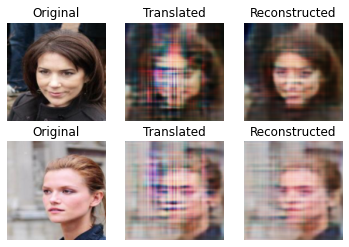

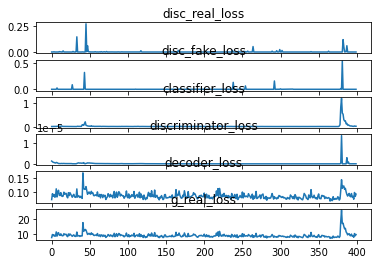

Train 0 / 100:   8%|▊         | 400/5086 [55:37<32:35:36, 25.04s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3929e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1869e-06
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.9533 - classifier_loss: 0.0166 - discriminator_loss: 3.3512e-08 - decoder_loss: 0.0779


Train 0 / 100:   8%|▊         | 401/5086 [55:49<27:12:56, 20.91s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7023e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0738e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 12.6287 - classifier_loss: 0.0153 - discriminator_loss: 7.2521e-09 - decoder_loss: 0.1248


Train 0 / 100:   8%|▊         | 402/5086 [55:56<22:04:16, 16.96s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2200e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5319e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.7248 - classifier_loss: 0.0194 - discriminator_loss: 9.0207e-09 - decoder_loss: 0.0853


Train 0 / 100:   8%|▊         | 403/5086 [56:04<18:25:08, 14.16s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1619e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9576e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.2077 - classifier_loss: 0.0176 - discriminator_loss: 2.3553e-08 - decoder_loss: 0.0803


Train 0 / 100:   8%|▊         | 404/5086 [56:12<15:50:12, 12.18s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4538e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5257e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2363 - classifier_loss: 0.0119 - discriminator_loss: 6.8360e-08 - decoder_loss: 0.0812


Train 0 / 100:   8%|▊         | 405/5086 [56:19<14:03:02, 10.81s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4058e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0210e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0236 - classifier_loss: 0.0179 - discriminator_loss: 2.7658e-08 - decoder_loss: 0.0784


Train 0 / 100:   8%|▊         | 406/5086 [56:27<12:47:04,  9.83s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6447e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1580e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.3910 - classifier_loss: 0.0143 - discriminator_loss: 2.0798e-08 - decoder_loss: 0.0825


Train 0 / 100:   8%|▊         | 407/5086 [56:34<11:57:57,  9.21s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7153e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 6.8575e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2352 - classifier_loss: 0.0154 - discriminator_loss: 1.7332e-08 - decoder_loss: 0.0808


Train 0 / 100:   8%|▊         | 408/5086 [56:42<11:19:23,  8.71s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3899e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1518e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 10.6564 - classifier_loss: 0.0137 - discriminator_loss: 1.3128e-08 - decoder_loss: 0.1052


Train 0 / 100:   8%|▊         | 409/5086 [56:50<10:54:11,  8.39s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0227
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3137 - classifier_loss: 0.0108 - discriminator_loss: 1.6921e-07 - decoder_loss: 0.0821


Train 0 / 100:   8%|▊         | 410/5086 [56:57<10:35:06,  8.15s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1839e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7084e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7109 - classifier_loss: 0.0115 - discriminator_loss: 1.4186e-06 - decoder_loss: 0.0860


Train 0 / 100:   8%|▊         | 411/5086 [57:05<10:23:26,  8.00s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5836e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8955 - classifier_loss: 0.0131 - discriminator_loss: 2.6996e-08 - decoder_loss: 0.0776


Train 0 / 100:   8%|▊         | 412/5086 [57:12<10:13:07,  7.87s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5550e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1130e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7225 - classifier_loss: 0.0110 - discriminator_loss: 2.6239e-08 - decoder_loss: 0.0761


Train 0 / 100:   8%|▊         | 413/5086 [57:20<10:06:31,  7.79s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0078e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5377e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.7435 - classifier_loss: 0.0136 - discriminator_loss: 1.0278e-08 - decoder_loss: 0.0861


Train 0 / 100:   8%|▊         | 414/5086 [57:28<10:02:33,  7.74s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0847e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9474e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1600 - classifier_loss: 0.0104 - discriminator_loss: 3.9511e-09 - decoder_loss: 0.0806


Train 0 / 100:   8%|▊         | 415/5086 [57:35<10:00:04,  7.71s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7399e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1856e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 9.3135 - classifier_loss: 0.0156 - discriminator_loss: 1.0018e-08 - decoder_loss: 0.0916


Train 0 / 100:   8%|▊         | 416/5086 [57:43<9:59:30,  7.70s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8579e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0759e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.8190 - classifier_loss: 0.0099 - discriminator_loss: 6.4834e-09 - decoder_loss: 0.0872


Train 0 / 100:   8%|▊         | 417/5086 [57:51<9:58:19,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0546e-09
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9509e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3051 - classifier_loss: 0.0182 - discriminator_loss: 1.2148e-08 - decoder_loss: 0.0812


Train 0 / 100:   8%|▊         | 418/5086 [57:58<9:55:44,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7528e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6698e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.1985 - classifier_loss: 0.0185 - discriminator_loss: 2.6800e-09 - decoder_loss: 0.0901


Train 0 / 100:   8%|▊         | 419/5086 [58:06<9:55:23,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3191e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2370e-07
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 7.7537 - classifier_loss: 0.0125 - discriminator_loss: 5.5712e-09 - decoder_loss: 0.0763


Train 0 / 100:   8%|▊         | 420/5086 [58:14<9:56:57,  7.68s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7797e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7577e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 10.1297 - classifier_loss: 0.0126 - discriminator_loss: 3.1132e-09 - decoder_loss: 0.1000


Train 0 / 100:   8%|▊         | 421/5086 [58:21<9:56:47,  7.68s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3814e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2419e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.7531 - classifier_loss: 0.0098 - discriminator_loss: 2.9626e-09 - decoder_loss: 0.0866


Train 0 / 100:   8%|▊         | 422/5086 [58:29<9:53:50,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3865e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3695e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.3351 - classifier_loss: 0.0121 - discriminator_loss: 6.0495e-09 - decoder_loss: 0.0921


Train 0 / 100:   8%|▊         | 423/5086 [58:37<9:54:53,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6896e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0569e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2680 - classifier_loss: 0.0095 - discriminator_loss: 1.7643e-08 - decoder_loss: 0.0817


Train 0 / 100:   8%|▊         | 424/5086 [58:44<9:53:00,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8230e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0407
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.9069 - classifier_loss: 0.0105 - discriminator_loss: 7.3730e-10 - decoder_loss: 0.1080


Train 0 / 100:   8%|▊         | 425/5086 [58:52<9:52:56,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4449e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5144e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.3481 - classifier_loss: 0.0097 - discriminator_loss: 5.6648e-10 - decoder_loss: 0.0825


Train 0 / 100:   8%|▊         | 426/5086 [58:59<9:52:34,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5100e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7426e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.0670 - classifier_loss: 0.0110 - discriminator_loss: 5.8977e-10 - decoder_loss: 0.0896


Train 0 / 100:   8%|▊         | 427/5086 [59:07<9:52:51,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6556e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0396e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.6198 - classifier_loss: 0.0094 - discriminator_loss: 4.7001e-10 - decoder_loss: 0.0853


Train 0 / 100:   8%|▊         | 428/5086 [59:15<9:52:07,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5270e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7353e-09
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 9.1430 - classifier_loss: 0.0134 - discriminator_loss: 5.0002e-10 - decoder_loss: 0.0901


Train 0 / 100:   8%|▊         | 429/5086 [59:22<9:55:12,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6378e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1958e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7647 - classifier_loss: 0.0091 - discriminator_loss: 4.5563e-10 - decoder_loss: 0.0867


Train 0 / 100:   8%|▊         | 430/5086 [59:30<9:53:16,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2876e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3480e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.6970 - classifier_loss: 0.0088 - discriminator_loss: 4.7164e-10 - decoder_loss: 0.0961


Train 0 / 100:   8%|▊         | 431/5086 [59:38<9:53:33,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8442e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1242e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.5782 - classifier_loss: 0.0112 - discriminator_loss: 3.7525e-10 - decoder_loss: 0.0847


Train 0 / 100:   8%|▊         | 432/5086 [59:45<9:52:38,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5663e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1553e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0916 - classifier_loss: 0.0117 - discriminator_loss: 4.1189e-10 - decoder_loss: 0.0797


Train 0 / 100:   9%|▊         | 433/5086 [59:53<9:53:12,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2282e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5458e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.8111 - classifier_loss: 0.0099 - discriminator_loss: 5.0274e-10 - decoder_loss: 0.0771


Train 0 / 100:   9%|▊         | 434/5086 [1:00:01<9:52:54,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0859e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8269e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0121 - classifier_loss: 0.0087 - discriminator_loss: 4.9801e-10 - decoder_loss: 0.0793


Train 0 / 100:   9%|▊         | 435/5086 [1:00:08<9:52:00,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1491e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.7147 - classifier_loss: 0.0093 - discriminator_loss: 4.4394e-10 - decoder_loss: 0.0862


Train 0 / 100:   9%|▊         | 436/5086 [1:00:16<9:49:57,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4945e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8119e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.1165 - classifier_loss: 0.0093 - discriminator_loss: 4.1390e-10 - decoder_loss: 0.0802


Train 0 / 100:   9%|▊         | 437/5086 [1:00:23<9:52:06,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2946e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3193e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8180 - classifier_loss: 0.0116 - discriminator_loss: 4.1199e-10 - decoder_loss: 0.0770


Train 0 / 100:   9%|▊         | 438/5086 [1:00:31<9:50:56,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5643e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4396e-09
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.7653 - classifier_loss: 0.0081 - discriminator_loss: 4.9421e-10 - decoder_loss: 0.0868


Train 0 / 100:   9%|▊         | 439/5086 [1:00:39<9:53:32,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1934e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6996e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4416 - classifier_loss: 0.0099 - discriminator_loss: 5.7944e-10 - decoder_loss: 0.0734


Train 0 / 100:   9%|▊         | 440/5086 [1:00:46<9:52:11,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2129e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0610e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.3301 - classifier_loss: 0.0108 - discriminator_loss: 4.5524e-10 - decoder_loss: 0.0822


Train 0 / 100:   9%|▊         | 441/5086 [1:00:54<9:52:24,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1593e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1302e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4879 - classifier_loss: 0.0077 - discriminator_loss: 4.3201e-10 - decoder_loss: 0.0841


Train 0 / 100:   9%|▊         | 442/5086 [1:01:02<9:50:08,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.6492e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4543e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.3392 - classifier_loss: 0.0089 - discriminator_loss: 4.8604e-10 - decoder_loss: 0.0825


Train 0 / 100:   9%|▊         | 443/5086 [1:01:09<9:51:40,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5881e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8469e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6898 - classifier_loss: 0.0082 - discriminator_loss: 5.8488e-10 - decoder_loss: 0.0761


Train 0 / 100:   9%|▊         | 444/5086 [1:01:17<9:49:59,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4412e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8188e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5979 - classifier_loss: 0.0086 - discriminator_loss: 6.2720e-10 - decoder_loss: 0.0751


Train 0 / 100:   9%|▊         | 445/5086 [1:01:25<9:50:46,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1561e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1703e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9838 - classifier_loss: 0.0142 - discriminator_loss: 9.1840e-10 - decoder_loss: 0.0784


Train 0 / 100:   9%|▉         | 446/5086 [1:01:32<9:49:15,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5885e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4558e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2376 - classifier_loss: 0.0103 - discriminator_loss: 4.9150e-10 - decoder_loss: 0.0814


Train 0 / 100:   9%|▉         | 447/5086 [1:01:40<9:50:30,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8694e-04
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 4.6947e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.1500 - classifier_loss: 0.0081 - discriminator_loss: 3.7211e-10 - decoder_loss: 0.0807


Train 0 / 100:   9%|▉         | 448/5086 [1:01:47<9:48:47,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5196e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3313e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.6094 - classifier_loss: 0.0101 - discriminator_loss: 4.2534e-10 - decoder_loss: 0.0851


Train 0 / 100:   9%|▉         | 449/5086 [1:01:55<9:49:54,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0074
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7181e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.3510 - classifier_loss: 0.0078 - discriminator_loss: 4.9080e-10 - decoder_loss: 0.0727


Train 0 / 100:   9%|▉         | 450/5086 [1:02:03<9:49:36,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3829e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5743e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6812 - classifier_loss: 0.0079 - discriminator_loss: 4.0551e-10 - decoder_loss: 0.0760


Train 0 / 100:   9%|▉         | 451/5086 [1:02:10<9:49:21,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2135e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3645e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3783 - classifier_loss: 0.0087 - discriminator_loss: 4.7466e-10 - decoder_loss: 0.0829


Train 0 / 100:   9%|▉         | 452/5086 [1:02:18<9:48:25,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5012e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6941e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.6228 - classifier_loss: 0.0085 - discriminator_loss: 3.9900e-10 - decoder_loss: 0.0954


Train 0 / 100:   9%|▉         | 453/5086 [1:02:26<9:49:24,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2480e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6906e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5871 - classifier_loss: 0.0074 - discriminator_loss: 5.8410e-10 - decoder_loss: 0.0851


Train 0 / 100:   9%|▉         | 454/5086 [1:02:33<9:49:21,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1927e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2833e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.0159 - classifier_loss: 0.0072 - discriminator_loss: 4.7795e-10 - decoder_loss: 0.0894


Train 0 / 100:   9%|▉         | 455/5086 [1:02:41<9:48:32,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7384e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.6520 - classifier_loss: 0.0080 - discriminator_loss: 4.4071e-10 - decoder_loss: 0.0857


Train 0 / 100:   9%|▉         | 456/5086 [1:02:48<9:48:54,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6417e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5145e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.8367 - classifier_loss: 0.0071 - discriminator_loss: 4.3560e-10 - decoder_loss: 0.0877


Train 0 / 100:   9%|▉         | 457/5086 [1:02:56<9:48:38,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0114e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2091e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.3796 - classifier_loss: 0.0078 - discriminator_loss: 3.9616e-10 - decoder_loss: 0.0830


Train 0 / 100:   9%|▉         | 458/5086 [1:03:04<9:48:40,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.1203e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7948e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 9.2371 - classifier_loss: 0.0073 - discriminator_loss: 5.7347e-10 - decoder_loss: 0.0916


Train 0 / 100:   9%|▉         | 459/5086 [1:03:11<9:51:20,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3329e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5647e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.2184 - classifier_loss: 0.0129 - discriminator_loss: 6.8705e-10 - decoder_loss: 0.0909


Train 0 / 100:   9%|▉         | 460/5086 [1:03:19<9:49:44,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0926e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5856e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5183 - classifier_loss: 0.0084 - discriminator_loss: 3.4399e-10 - decoder_loss: 0.0743


Train 0 / 100:   9%|▉         | 461/5086 [1:03:27<9:49:52,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2216e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4987e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.5481 - classifier_loss: 0.0069 - discriminator_loss: 3.8226e-10 - decoder_loss: 0.0748


Train 0 / 100:   9%|▉         | 462/5086 [1:03:34<9:46:53,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4022e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1122e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5464 - classifier_loss: 0.0063 - discriminator_loss: 4.8029e-10 - decoder_loss: 0.0748


Train 0 / 100:   9%|▉         | 463/5086 [1:03:42<9:47:11,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2096e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0506e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.3779 - classifier_loss: 0.0078 - discriminator_loss: 5.2281e-10 - decoder_loss: 0.0730


Train 0 / 100:   9%|▉         | 464/5086 [1:03:50<9:47:03,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7382e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9009e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2855 - classifier_loss: 0.0069 - discriminator_loss: 4.3702e-10 - decoder_loss: 0.0822


Train 0 / 100:   9%|▉         | 465/5086 [1:03:57<9:47:45,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7591e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5082 - classifier_loss: 0.0075 - discriminator_loss: 4.9961e-10 - decoder_loss: 0.0843


Train 0 / 100:   9%|▉         | 466/5086 [1:04:05<9:47:23,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4957e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3540e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3795 - classifier_loss: 0.0080 - discriminator_loss: 4.2645e-10 - decoder_loss: 0.0830


Train 0 / 100:   9%|▉         | 467/5086 [1:04:12<9:47:20,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7571e-09
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.9977e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4167 - classifier_loss: 0.0068 - discriminator_loss: 4.2132e-10 - decoder_loss: 0.0735


Train 0 / 100:   9%|▉         | 468/5086 [1:04:20<9:45:49,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.6226e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3409e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6332 - classifier_loss: 0.0067 - discriminator_loss: 5.6623e-10 - decoder_loss: 0.0757


Train 0 / 100:   9%|▉         | 469/5086 [1:04:28<9:47:03,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3325e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1342e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.3089 - classifier_loss: 0.0066 - discriminator_loss: 5.2665e-10 - decoder_loss: 0.0724


Train 0 / 100:   9%|▉         | 470/5086 [1:04:35<9:48:33,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0887e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5532e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.4905 - classifier_loss: 0.0088 - discriminator_loss: 5.1143e-10 - decoder_loss: 0.0840


Train 0 / 100:   9%|▉         | 471/5086 [1:04:43<9:48:56,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1118e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2691e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.5963 - classifier_loss: 0.0074 - discriminator_loss: 4.6748e-10 - decoder_loss: 0.0852


Train 0 / 100:   9%|▉         | 472/5086 [1:04:51<9:48:10,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.1584
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.1423
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4293 - classifier_loss: 0.0069 - discriminator_loss: 1.1645e-08 - decoder_loss: 0.0736


Train 0 / 100:   9%|▉         | 473/5086 [1:04:58<9:48:34,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3290e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9623e-06
Epoch 1/1
32/32 [==============================] - 6s 186ms/step - loss: 8.0474 - classifier_loss: 0.0085 - discriminator_loss: 1.1944e-08 - decoder_loss: 0.0796


Train 0 / 100:   9%|▉         | 474/5086 [1:05:06<9:51:00,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1655e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1676e-04
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0819 - classifier_loss: 0.0092 - discriminator_loss: 1.5686e-08 - decoder_loss: 0.0799


Train 0 / 100:   9%|▉         | 475/5086 [1:05:14<9:50:26,  7.68s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5628e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.6777e-06
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.6332 - classifier_loss: 0.0091 - discriminator_loss: 9.9468e-09 - decoder_loss: 0.0754


Train 0 / 100:   9%|▉         | 476/5086 [1:05:21<9:50:42,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0365
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.1116 - classifier_loss: 0.0075 - discriminator_loss: 1.1509e-07 - decoder_loss: 0.0904


Train 0 / 100:   9%|▉         | 477/5086 [1:05:29<9:49:26,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8601e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0316
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0224 - classifier_loss: 0.0066 - discriminator_loss: 1.3705e-08 - decoder_loss: 0.0796


Train 0 / 100:   9%|▉         | 478/5086 [1:05:37<9:48:14,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0039e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7078e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.7984 - classifier_loss: 0.0065 - discriminator_loss: 3.7143e-09 - decoder_loss: 0.0773


Train 0 / 100:   9%|▉         | 479/5086 [1:05:44<9:48:41,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.7799e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.9518 - classifier_loss: 0.0069 - discriminator_loss: 4.3190e-09 - decoder_loss: 0.0788


Train 0 / 100:   9%|▉         | 480/5086 [1:05:52<9:48:15,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0460
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9633e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5944 - classifier_loss: 0.0087 - discriminator_loss: 4.2031e-09 - decoder_loss: 0.0751


Train 0 / 100:   9%|▉         | 481/5086 [1:06:00<9:47:54,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8469e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5561e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7821 - classifier_loss: 0.0072 - discriminator_loss: 1.3734e-08 - decoder_loss: 0.0771


Train 0 / 100:   9%|▉         | 482/5086 [1:06:07<9:46:42,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6652e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1309e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5525 - classifier_loss: 0.0068 - discriminator_loss: 9.0184e-09 - decoder_loss: 0.0748


Train 0 / 100:   9%|▉         | 483/5086 [1:06:15<9:45:50,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6253e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4731 - classifier_loss: 0.0065 - discriminator_loss: 6.5618e-09 - decoder_loss: 0.0841


Train 0 / 100:  10%|▉         | 484/5086 [1:06:23<9:45:11,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4812e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7540e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3567 - classifier_loss: 0.0081 - discriminator_loss: 5.1579e-09 - decoder_loss: 0.0728


Train 0 / 100:  10%|▉         | 485/5086 [1:06:30<9:45:30,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5310e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0694e-04
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 9.9068 - classifier_loss: 0.0072 - discriminator_loss: 6.1562e-09 - decoder_loss: 0.0983


Train 0 / 100:  10%|▉         | 486/5086 [1:06:38<9:46:59,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1761e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6402e-04
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.6647 - classifier_loss: 0.0083 - discriminator_loss: 1.2114e-08 - decoder_loss: 0.0858


Train 0 / 100:  10%|▉         | 487/5086 [1:06:46<9:47:41,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3869e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1440e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8488 - classifier_loss: 0.0061 - discriminator_loss: 7.5721e-09 - decoder_loss: 0.0779


Train 0 / 100:  10%|▉         | 488/5086 [1:06:53<9:46:27,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0671e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.8528 - classifier_loss: 0.0069 - discriminator_loss: 4.0739e-09 - decoder_loss: 0.0878


Train 0 / 100:  10%|▉         | 489/5086 [1:07:01<9:46:29,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0775e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2520e-06
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.8320 - classifier_loss: 0.0057 - discriminator_loss: 5.3818e-09 - decoder_loss: 0.0877


Train 0 / 100:  10%|▉         | 490/5086 [1:07:09<9:47:57,  7.68s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1947e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7222e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 10.4357 - classifier_loss: 0.0062 - discriminator_loss: 5.1570e-09 - decoder_loss: 0.1037


Train 0 / 100:  10%|▉         | 491/5086 [1:07:16<9:46:27,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3609e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3984e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.8416 - classifier_loss: 0.0077 - discriminator_loss: 5.3395e-09 - decoder_loss: 0.0876


Train 0 / 100:  10%|▉         | 492/5086 [1:07:24<9:45:49,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6453e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8745e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.4063 - classifier_loss: 0.0081 - discriminator_loss: 4.7641e-09 - decoder_loss: 0.0833


Train 0 / 100:  10%|▉         | 493/5086 [1:07:32<9:46:22,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3329e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.5618 - classifier_loss: 0.0074 - discriminator_loss: 4.3835e-09 - decoder_loss: 0.0849


Train 0 / 100:  10%|▉         | 494/5086 [1:07:39<9:44:23,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4266e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9957e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9637 - classifier_loss: 0.0064 - discriminator_loss: 3.2320e-09 - decoder_loss: 0.0790


Train 0 / 100:  10%|▉         | 495/5086 [1:07:47<9:44:24,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0781e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0934e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.5210 - classifier_loss: 0.0070 - discriminator_loss: 4.7819e-09 - decoder_loss: 0.0845


Train 0 / 100:  10%|▉         | 496/5086 [1:07:54<9:44:16,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0415e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9957e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6881 - classifier_loss: 0.0154 - discriminator_loss: 8.6754e-09 - decoder_loss: 0.0853


Train 0 / 100:  10%|▉         | 497/5086 [1:08:02<9:44:00,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5720e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6469e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2097 - classifier_loss: 0.0084 - discriminator_loss: 3.5048e-09 - decoder_loss: 0.0813


Train 0 / 100:  10%|▉         | 498/5086 [1:08:10<9:43:46,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5806e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9194 - classifier_loss: 0.0057 - discriminator_loss: 3.6407e-09 - decoder_loss: 0.0786


Train 0 / 100:  10%|▉         | 499/5086 [1:08:17<9:44:49,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0385e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3722e-04
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.6714 - classifier_loss: 0.0128 - discriminator_loss: 6.4072e-09 - decoder_loss: 0.0754
Epoch: 0 with batch: 499


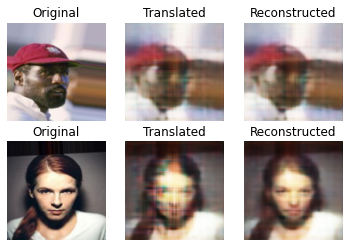

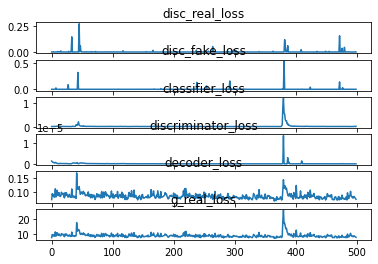

Train 0 / 100:  10%|▉         | 500/5086 [1:09:26<33:07:27, 26.00s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5773e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1857e-06
Epoch 1/1
32/32 [==============================] - 6s 178ms/step - loss: 8.0532 - classifier_loss: 0.0078 - discriminator_loss: 2.8901e-09 - decoder_loss: 0.0798


Train 0 / 100:  10%|▉         | 501/5086 [1:09:34<26:07:33, 20.51s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8520e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2868e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3436 - classifier_loss: 0.0074 - discriminator_loss: 3.1639e-09 - decoder_loss: 0.0727


Train 0 / 100:  10%|▉         | 502/5086 [1:09:42<21:17:06, 16.72s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2935e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0170e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5955 - classifier_loss: 0.0084 - discriminator_loss: 3.5061e-09 - decoder_loss: 0.0751


Train 0 / 100:  10%|▉         | 503/5086 [1:09:49<17:47:17, 13.97s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8292e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2455e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.3779 - classifier_loss: 0.0089 - discriminator_loss: 2.6515e-09 - decoder_loss: 0.0729


Train 0 / 100:  10%|▉         | 504/5086 [1:09:57<15:21:42, 12.07s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8991e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1274e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4482 - classifier_loss: 0.0081 - discriminator_loss: 3.4454e-09 - decoder_loss: 0.0737


Train 0 / 100:  10%|▉         | 505/5086 [1:10:05<13:39:17, 10.73s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.9905e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5636e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1528 - classifier_loss: 0.0072 - discriminator_loss: 3.5056e-09 - decoder_loss: 0.0708


Train 0 / 100:  10%|▉         | 506/5086 [1:10:12<12:27:41,  9.80s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2298e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4527e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0652 - classifier_loss: 0.0064 - discriminator_loss: 2.7504e-09 - decoder_loss: 0.0800


Train 0 / 100:  10%|▉         | 507/5086 [1:10:20<11:37:57,  9.15s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6800e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2579e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.2635 - classifier_loss: 0.0078 - discriminator_loss: 3.0717e-09 - decoder_loss: 0.0819


Train 0 / 100:  10%|▉         | 508/5086 [1:10:27<11:03:17,  8.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0117
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4472e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.4768 - classifier_loss: 0.0075 - discriminator_loss: 9.3912e-09 - decoder_loss: 0.0940


Train 0 / 100:  10%|█         | 509/5086 [1:10:35<10:37:17,  8.35s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2128e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0081
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9397 - classifier_loss: 0.0086 - discriminator_loss: 4.2321e-09 - decoder_loss: 0.0785


Train 0 / 100:  10%|█         | 510/5086 [1:10:43<10:20:10,  8.13s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5044e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3273e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6818 - classifier_loss: 0.0059 - discriminator_loss: 2.1699e-09 - decoder_loss: 0.0762


Train 0 / 100:  10%|█         | 511/5086 [1:10:50<10:08:31,  7.98s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0036e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4799e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4705 - classifier_loss: 0.0070 - discriminator_loss: 2.3041e-09 - decoder_loss: 0.0840


Train 0 / 100:  10%|█         | 512/5086 [1:10:58<9:59:03,  7.86s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4067e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8086e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8958 - classifier_loss: 0.0066 - discriminator_loss: 2.2426e-09 - decoder_loss: 0.0783


Train 0 / 100:  10%|█         | 513/5086 [1:11:05<9:52:36,  7.78s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8256e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6138 - classifier_loss: 0.0054 - discriminator_loss: 2.8861e-09 - decoder_loss: 0.0756


Train 0 / 100:  10%|█         | 514/5086 [1:11:13<9:48:16,  7.72s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4909e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.7370 - classifier_loss: 0.0071 - discriminator_loss: 1.4534e-09 - decoder_loss: 0.0767


Train 0 / 100:  10%|█         | 515/5086 [1:11:21<9:47:39,  7.71s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9873e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 4.3708e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9493 - classifier_loss: 0.0100 - discriminator_loss: 1.2569e-09 - decoder_loss: 0.0785


Train 0 / 100:  10%|█         | 516/5086 [1:11:28<9:45:26,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8815e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5156e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3047 - classifier_loss: 0.0066 - discriminator_loss: 1.0872e-09 - decoder_loss: 0.0824


Train 0 / 100:  10%|█         | 517/5086 [1:11:36<9:42:32,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1483e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.9116e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.3339 - classifier_loss: 0.0080 - discriminator_loss: 1.3703e-09 - decoder_loss: 0.0825


Train 0 / 100:  10%|█         | 518/5086 [1:11:43<9:41:25,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1515e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4084e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.4283 - classifier_loss: 0.0070 - discriminator_loss: 9.8934e-10 - decoder_loss: 0.0836


Train 0 / 100:  10%|█         | 519/5086 [1:11:51<9:40:42,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1073e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5897e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.5497 - classifier_loss: 0.0081 - discriminator_loss: 1.0168e-09 - decoder_loss: 0.0847


Train 0 / 100:  10%|█         | 520/5086 [1:11:59<9:40:27,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4390e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1646e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8339 - classifier_loss: 0.0069 - discriminator_loss: 9.5119e-10 - decoder_loss: 0.0776


Train 0 / 100:  10%|█         | 521/5086 [1:12:06<9:39:05,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5007e-05
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.1683e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.8229 - classifier_loss: 0.0058 - discriminator_loss: 8.8721e-10 - decoder_loss: 0.0876


Train 0 / 100:  10%|█         | 522/5086 [1:12:14<9:37:49,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8012e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.6691e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.3502 - classifier_loss: 0.0054 - discriminator_loss: 1.1513e-09 - decoder_loss: 0.0830


Train 0 / 100:  10%|█         | 523/5086 [1:12:22<9:39:59,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3867e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9800e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.6989 - classifier_loss: 0.0075 - discriminator_loss: 1.0720e-09 - decoder_loss: 0.0862


Train 0 / 100:  10%|█         | 524/5086 [1:12:29<9:39:16,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4496e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1005e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.4864 - classifier_loss: 0.0074 - discriminator_loss: 1.4216e-09 - decoder_loss: 0.0741


Train 0 / 100:  10%|█         | 525/5086 [1:12:37<9:39:52,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0596e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6066e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0210 - classifier_loss: 0.0066 - discriminator_loss: 1.1987e-09 - decoder_loss: 0.0796


Train 0 / 100:  10%|█         | 526/5086 [1:12:44<9:37:29,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.6035e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7082e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.2250 - classifier_loss: 0.0064 - discriminator_loss: 9.4744e-10 - decoder_loss: 0.1016


Train 0 / 100:  10%|█         | 527/5086 [1:12:52<9:37:07,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7357e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4011e-08
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 9.9004 - classifier_loss: 0.0064 - discriminator_loss: 8.7773e-10 - decoder_loss: 0.0984


Train 0 / 100:  10%|█         | 528/5086 [1:13:00<9:40:09,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7939e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0536e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.5918 - classifier_loss: 0.0074 - discriminator_loss: 1.0501e-09 - decoder_loss: 0.0952


Train 0 / 100:  10%|█         | 529/5086 [1:13:07<9:39:29,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4232e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5347e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9639 - classifier_loss: 0.0082 - discriminator_loss: 9.2045e-10 - decoder_loss: 0.0788


Train 0 / 100:  10%|█         | 530/5086 [1:13:15<9:38:29,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3286e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1877e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.8638 - classifier_loss: 0.0081 - discriminator_loss: 1.0794e-09 - decoder_loss: 0.1078


Train 0 / 100:  10%|█         | 531/5086 [1:13:23<9:39:36,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9160e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9154e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.3873 - classifier_loss: 0.0080 - discriminator_loss: 1.2705e-09 - decoder_loss: 0.0931


Train 0 / 100:  10%|█         | 532/5086 [1:13:30<9:39:57,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1687e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0533e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.9823 - classifier_loss: 0.0079 - discriminator_loss: 8.5974e-10 - decoder_loss: 0.0890


Train 0 / 100:  10%|█         | 533/5086 [1:13:38<9:41:30,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2052e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5349e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4709 - classifier_loss: 0.0061 - discriminator_loss: 7.6966e-10 - decoder_loss: 0.0741


Train 0 / 100:  10%|█         | 534/5086 [1:13:46<9:40:30,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4039e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7550e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5592 - classifier_loss: 0.0062 - discriminator_loss: 1.0325e-09 - decoder_loss: 0.0750


Train 0 / 100:  11%|█         | 535/5086 [1:13:53<9:38:26,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6995e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8808e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.9590 - classifier_loss: 0.0053 - discriminator_loss: 8.4210e-10 - decoder_loss: 0.0791


Train 0 / 100:  11%|█         | 536/5086 [1:14:01<9:40:13,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0145e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0194e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8710 - classifier_loss: 0.0057 - discriminator_loss: 8.9959e-10 - decoder_loss: 0.0781


Train 0 / 100:  11%|█         | 537/5086 [1:14:08<9:39:04,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4961e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7763e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.7791 - classifier_loss: 0.0057 - discriminator_loss: 7.9772e-10 - decoder_loss: 0.0772


Train 0 / 100:  11%|█         | 538/5086 [1:14:16<9:38:54,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0066
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8278e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0826 - classifier_loss: 0.0060 - discriminator_loss: 1.1160e-09 - decoder_loss: 0.0702


Train 0 / 100:  11%|█         | 539/5086 [1:14:24<9:38:26,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2055e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.3510e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9180 - classifier_loss: 0.0055 - discriminator_loss: 8.0274e-10 - decoder_loss: 0.0786


Train 0 / 100:  11%|█         | 540/5086 [1:14:31<9:36:45,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1132e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1255e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.5654 - classifier_loss: 0.0068 - discriminator_loss: 8.3540e-10 - decoder_loss: 0.0950


Train 0 / 100:  11%|█         | 541/5086 [1:14:39<9:36:50,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1898e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.3270e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.8692 - classifier_loss: 0.0069 - discriminator_loss: 1.0552e-09 - decoder_loss: 0.0780


Train 0 / 100:  11%|█         | 542/5086 [1:14:47<9:37:54,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.2402e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4248e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8271 - classifier_loss: 0.0063 - discriminator_loss: 1.0680e-09 - decoder_loss: 0.0776


Train 0 / 100:  11%|█         | 543/5086 [1:14:54<9:37:29,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1841e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.4382 - classifier_loss: 0.0069 - discriminator_loss: 1.0928e-09 - decoder_loss: 0.0737


Train 0 / 100:  11%|█         | 544/5086 [1:15:02<9:35:50,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3169e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8590e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5889 - classifier_loss: 0.0054 - discriminator_loss: 9.6735e-10 - decoder_loss: 0.0753


Train 0 / 100:  11%|█         | 545/5086 [1:15:09<9:35:42,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9831e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4336e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7601 - classifier_loss: 0.0066 - discriminator_loss: 8.1811e-10 - decoder_loss: 0.0769


Train 0 / 100:  11%|█         | 546/5086 [1:15:17<9:36:05,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2917e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4963e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8108 - classifier_loss: 0.0073 - discriminator_loss: 8.1973e-10 - decoder_loss: 0.0774


Train 0 / 100:  11%|█         | 547/5086 [1:15:25<9:35:49,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5306e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7682e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1418 - classifier_loss: 0.0074 - discriminator_loss: 1.1657e-09 - decoder_loss: 0.0707


Train 0 / 100:  11%|█         | 548/5086 [1:15:32<9:34:18,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3485e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0137
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 7.4975 - classifier_loss: 0.0073 - discriminator_loss: 5.4245e-10 - decoder_loss: 0.0742


Train 0 / 100:  11%|█         | 549/5086 [1:15:40<9:37:20,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3828e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0747e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.4927 - classifier_loss: 0.0058 - discriminator_loss: 3.3469e-10 - decoder_loss: 0.0943


Train 0 / 100:  11%|█         | 550/5086 [1:15:47<9:37:17,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0081
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9547e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.5346 - classifier_loss: 0.0056 - discriminator_loss: 4.8308e-10 - decoder_loss: 0.0948


Train 0 / 100:  11%|█         | 551/5086 [1:15:55<9:36:27,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3336e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6692e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3172 - classifier_loss: 0.0062 - discriminator_loss: 4.2806e-10 - decoder_loss: 0.0725


Train 0 / 100:  11%|█         | 552/5086 [1:16:03<9:35:36,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8099e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5671e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3917 - classifier_loss: 0.0071 - discriminator_loss: 3.5583e-10 - decoder_loss: 0.0832


Train 0 / 100:  11%|█         | 553/5086 [1:16:10<9:35:14,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9427e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9082e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5416 - classifier_loss: 0.0061 - discriminator_loss: 3.5287e-10 - decoder_loss: 0.0748


Train 0 / 100:  11%|█         | 554/5086 [1:16:18<9:35:26,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5043e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8795e-09
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.1223 - classifier_loss: 0.0061 - discriminator_loss: 3.9826e-10 - decoder_loss: 0.0706


Train 0 / 100:  11%|█         | 555/5086 [1:16:26<9:37:37,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2222e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0823e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9195 - classifier_loss: 0.0064 - discriminator_loss: 4.1955e-10 - decoder_loss: 0.0786


Train 0 / 100:  11%|█         | 556/5086 [1:16:33<9:36:19,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7772e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8913e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.6751 - classifier_loss: 0.0063 - discriminator_loss: 3.8191e-10 - decoder_loss: 0.0861


Train 0 / 100:  11%|█         | 557/5086 [1:16:41<9:35:59,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3907e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8392e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1256 - classifier_loss: 0.0065 - discriminator_loss: 3.5610e-10 - decoder_loss: 0.0806


Train 0 / 100:  11%|█         | 558/5086 [1:16:48<9:34:48,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.0991e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.8050 - classifier_loss: 0.0052 - discriminator_loss: 4.4545e-10 - decoder_loss: 0.0875


Train 0 / 100:  11%|█         | 559/5086 [1:16:56<9:33:38,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9893e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4381e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1721 - classifier_loss: 0.0061 - discriminator_loss: 3.8718e-10 - decoder_loss: 0.0811


Train 0 / 100:  11%|█         | 560/5086 [1:17:04<9:33:24,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2377e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2492e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.5610 - classifier_loss: 0.0067 - discriminator_loss: 4.9524e-10 - decoder_loss: 0.0749


Train 0 / 100:  11%|█         | 561/5086 [1:17:11<9:35:04,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1880e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.3275e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5526 - classifier_loss: 0.0057 - discriminator_loss: 4.7033e-10 - decoder_loss: 0.0750


Train 0 / 100:  11%|█         | 562/5086 [1:17:19<9:34:41,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1240e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7476e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6215 - classifier_loss: 0.0062 - discriminator_loss: 4.6279e-10 - decoder_loss: 0.0756


Train 0 / 100:  11%|█         | 563/5086 [1:17:27<9:34:20,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3530e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8540e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.5808 - classifier_loss: 0.0062 - discriminator_loss: 3.9421e-10 - decoder_loss: 0.0752


Train 0 / 100:  11%|█         | 564/5086 [1:17:34<9:34:42,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1931e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6360e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4620 - classifier_loss: 0.0058 - discriminator_loss: 4.7861e-10 - decoder_loss: 0.0740


Train 0 / 100:  11%|█         | 565/5086 [1:17:42<9:33:05,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6208e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9054e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0131 - classifier_loss: 0.0063 - discriminator_loss: 4.1423e-10 - decoder_loss: 0.0795


Train 0 / 100:  11%|█         | 566/5086 [1:17:49<9:33:27,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3678e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3985e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5263 - classifier_loss: 0.0062 - discriminator_loss: 6.3220e-10 - decoder_loss: 0.0746


Train 0 / 100:  11%|█         | 567/5086 [1:17:57<9:32:56,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4006e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2096e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3156 - classifier_loss: 0.0068 - discriminator_loss: 3.7355e-10 - decoder_loss: 0.0725


Train 0 / 100:  11%|█         | 568/5086 [1:18:04<9:31:49,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0642e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5730e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5106 - classifier_loss: 0.0066 - discriminator_loss: 4.2784e-10 - decoder_loss: 0.0744


Train 0 / 100:  11%|█         | 569/5086 [1:18:12<9:31:52,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4803e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0371e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6968 - classifier_loss: 0.0065 - discriminator_loss: 4.0361e-10 - decoder_loss: 0.0763


Train 0 / 100:  11%|█         | 570/5086 [1:18:20<9:31:59,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2940e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0905e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9622 - classifier_loss: 0.0064 - discriminator_loss: 4.2862e-10 - decoder_loss: 0.0790


Train 0 / 100:  11%|█         | 571/5086 [1:18:27<9:32:43,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0762
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1852e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1886 - classifier_loss: 0.0085 - discriminator_loss: 5.9802e-09 - decoder_loss: 0.0710


Train 0 / 100:  11%|█         | 572/5086 [1:18:35<9:31:20,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0266e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4103 - classifier_loss: 0.0054 - discriminator_loss: 6.6250e-09 - decoder_loss: 0.0736


Train 0 / 100:  11%|█▏        | 573/5086 [1:18:42<9:31:06,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4973e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.8800 - classifier_loss: 0.0057 - discriminator_loss: 2.7726e-09 - decoder_loss: 0.0782


Train 0 / 100:  11%|█▏        | 574/5086 [1:18:50<9:33:24,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1979e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3192e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.5074 - classifier_loss: 0.0062 - discriminator_loss: 1.5211e-09 - decoder_loss: 0.0745


Train 0 / 100:  11%|█▏        | 575/5086 [1:18:58<9:34:29,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9966e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0239e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2186 - classifier_loss: 0.0068 - discriminator_loss: 1.4274e-09 - decoder_loss: 0.0815


Train 0 / 100:  11%|█▏        | 576/5086 [1:19:05<9:32:54,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5537e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4217e-06
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.2026 - classifier_loss: 0.0048 - discriminator_loss: 1.6535e-09 - decoder_loss: 0.0815


Train 0 / 100:  11%|█▏        | 577/5086 [1:19:13<9:34:37,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5698e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0712e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5822 - classifier_loss: 0.0057 - discriminator_loss: 1.7106e-09 - decoder_loss: 0.0753


Train 0 / 100:  11%|█▏        | 578/5086 [1:19:21<9:33:17,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.9435e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7896e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8544 - classifier_loss: 0.0062 - discriminator_loss: 1.6304e-09 - decoder_loss: 0.0779


Train 0 / 100:  11%|█▏        | 579/5086 [1:19:28<9:32:45,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1783e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7173 - classifier_loss: 0.0054 - discriminator_loss: 1.3654e-09 - decoder_loss: 0.0766


Train 0 / 100:  11%|█▏        | 580/5086 [1:19:36<9:31:16,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9571e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0491e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4101 - classifier_loss: 0.0052 - discriminator_loss: 1.0534e-09 - decoder_loss: 0.0736


Train 0 / 100:  11%|█▏        | 581/5086 [1:19:43<9:30:22,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0905e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.3767e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9283 - classifier_loss: 0.0059 - discriminator_loss: 1.1794e-09 - decoder_loss: 0.0787


Train 0 / 100:  11%|█▏        | 582/5086 [1:19:51<9:29:38,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1352e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0400e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6476 - classifier_loss: 0.0056 - discriminator_loss: 1.2029e-09 - decoder_loss: 0.0759


Train 0 / 100:  11%|█▏        | 583/5086 [1:19:59<9:29:46,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1758e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1568e-05
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.5404 - classifier_loss: 0.0054 - discriminator_loss: 1.1793e-09 - decoder_loss: 0.0749


Train 0 / 100:  11%|█▏        | 584/5086 [1:20:06<9:28:21,  7.57s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0122e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.1795e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9952 - classifier_loss: 0.0060 - discriminator_loss: 8.1839e-10 - decoder_loss: 0.0694


Train 0 / 100:  12%|█▏        | 585/5086 [1:20:14<9:29:25,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8745e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5614e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5674 - classifier_loss: 0.0052 - discriminator_loss: 1.2016e-09 - decoder_loss: 0.0752


Train 0 / 100:  12%|█▏        | 586/5086 [1:20:21<9:29:02,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7081e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3947e-06
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.2279 - classifier_loss: 0.0054 - discriminator_loss: 9.7088e-10 - decoder_loss: 0.0717


Train 0 / 100:  12%|█▏        | 587/5086 [1:20:29<9:31:27,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5693e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.7442 - classifier_loss: 0.0064 - discriminator_loss: 1.0477e-09 - decoder_loss: 0.0768


Train 0 / 100:  12%|█▏        | 588/5086 [1:20:37<9:32:41,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6398e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0707e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.4040 - classifier_loss: 0.0063 - discriminator_loss: 8.0224e-10 - decoder_loss: 0.0834


Train 0 / 100:  12%|█▏        | 589/5086 [1:20:44<9:33:17,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8598e-09
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4159e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1632 - classifier_loss: 0.0060 - discriminator_loss: 8.6192e-10 - decoder_loss: 0.0710


Train 0 / 100:  12%|█▏        | 590/5086 [1:20:52<9:31:53,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8124e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0346
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.6550 - classifier_loss: 0.0060 - discriminator_loss: 3.6497e-10 - decoder_loss: 0.0760


Train 0 / 100:  12%|█▏        | 591/5086 [1:21:00<9:32:40,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1433e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7697e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8746 - classifier_loss: 0.0083 - discriminator_loss: 1.9177e-10 - decoder_loss: 0.0779


Train 0 / 100:  12%|█▏        | 592/5086 [1:21:07<9:31:23,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4404e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8288e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.7676 - classifier_loss: 0.0087 - discriminator_loss: 1.6256e-10 - decoder_loss: 0.0768


Train 0 / 100:  12%|█▏        | 593/5086 [1:21:15<9:30:59,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3394e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3463e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2090 - classifier_loss: 0.0059 - discriminator_loss: 1.7241e-10 - decoder_loss: 0.0815


Train 0 / 100:  12%|█▏        | 594/5086 [1:21:23<9:30:42,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0165e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0777e-10
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.6834 - classifier_loss: 0.0064 - discriminator_loss: 1.5716e-10 - decoder_loss: 0.0862


Train 0 / 100:  12%|█▏        | 595/5086 [1:21:30<9:31:14,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1187e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4469e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3322 - classifier_loss: 0.0063 - discriminator_loss: 1.8359e-10 - decoder_loss: 0.0727


Train 0 / 100:  12%|█▏        | 596/5086 [1:21:38<9:30:49,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3698e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7649e-10
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 6.9762 - classifier_loss: 0.0071 - discriminator_loss: 1.8075e-10 - decoder_loss: 0.0691


Train 0 / 100:  12%|█▏        | 597/5086 [1:21:45<9:31:24,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2584e-10
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 6.6972 - classifier_loss: 0.0055 - discriminator_loss: 1.7742e-10 - decoder_loss: 0.0664


Train 0 / 100:  12%|█▏        | 598/5086 [1:21:53<9:32:10,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6385e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2270e-09
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.0534 - classifier_loss: 0.0075 - discriminator_loss: 1.9671e-10 - decoder_loss: 0.0798


Train 0 / 100:  12%|█▏        | 599/5086 [1:22:01<9:33:38,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2849e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 6.0096e-10
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.2062 - classifier_loss: 0.0069 - discriminator_loss: 1.7168e-10 - decoder_loss: 0.0814
Epoch: 0 with batch: 599


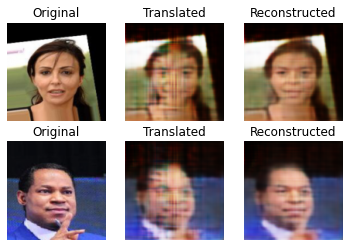

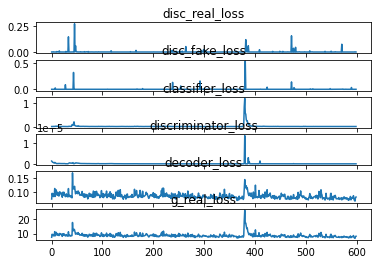

Train 0 / 100:  12%|█▏        | 600/5086 [1:23:09<32:18:13, 25.92s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2827e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3563e-10
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.5906 - classifier_loss: 0.0052 - discriminator_loss: 1.7561e-10 - decoder_loss: 0.0754


Train 0 / 100:  12%|█▏        | 601/5086 [1:23:17<25:32:42, 20.50s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0248
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 2.8083e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8615 - classifier_loss: 0.0085 - discriminator_loss: 3.0020e-10 - decoder_loss: 0.0778


Train 0 / 100:  12%|█▏        | 602/5086 [1:23:25<20:46:29, 16.68s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8109e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2158e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4124 - classifier_loss: 0.0058 - discriminator_loss: 3.8544e-10 - decoder_loss: 0.0835


Train 0 / 100:  12%|█▏        | 603/5086 [1:23:33<17:28:00, 14.03s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0560e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.6977e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4430 - classifier_loss: 0.0048 - discriminator_loss: 3.5461e-10 - decoder_loss: 0.0740


Train 0 / 100:  12%|█▏        | 604/5086 [1:23:40<15:03:49, 12.10s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7251e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5753e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8023 - classifier_loss: 0.0054 - discriminator_loss: 3.8959e-10 - decoder_loss: 0.0775


Train 0 / 100:  12%|█▏        | 605/5086 [1:23:48<13:22:58, 10.75s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0283e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9641e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3623 - classifier_loss: 0.0049 - discriminator_loss: 4.2184e-10 - decoder_loss: 0.0831


Train 0 / 100:  12%|█▏        | 606/5086 [1:23:56<12:10:52,  9.79s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1644e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8789e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6086 - classifier_loss: 0.0060 - discriminator_loss: 3.7422e-10 - decoder_loss: 0.0755


Train 0 / 100:  12%|█▏        | 607/5086 [1:24:03<11:21:33,  9.13s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1248e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0164e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.2402 - classifier_loss: 0.0058 - discriminator_loss: 4.4078e-10 - decoder_loss: 0.0818


Train 0 / 100:  12%|█▏        | 608/5086 [1:24:11<10:48:35,  8.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3673e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4002e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3264 - classifier_loss: 0.0061 - discriminator_loss: 3.7264e-10 - decoder_loss: 0.0727


Train 0 / 100:  12%|█▏        | 609/5086 [1:24:18<10:24:04,  8.36s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7542e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1852e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.2770 - classifier_loss: 0.0067 - discriminator_loss: 4.4430e-10 - decoder_loss: 0.0921


Train 0 / 100:  12%|█▏        | 610/5086 [1:24:26<10:07:28,  8.14s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9895e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6867e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3400 - classifier_loss: 0.0055 - discriminator_loss: 4.9946e-10 - decoder_loss: 0.0828


Train 0 / 100:  12%|█▏        | 611/5086 [1:24:34<9:55:30,  7.98s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0304e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2678e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 9.2512 - classifier_loss: 0.0055 - discriminator_loss: 4.4235e-10 - decoder_loss: 0.0920


Train 0 / 100:  12%|█▏        | 612/5086 [1:24:41<9:48:08,  7.89s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9471e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2366e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6659 - classifier_loss: 0.0057 - discriminator_loss: 4.7060e-10 - decoder_loss: 0.0761


Train 0 / 100:  12%|█▏        | 613/5086 [1:24:49<9:41:25,  7.80s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8858e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2010e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.6612 - classifier_loss: 0.0068 - discriminator_loss: 3.9044e-10 - decoder_loss: 0.0759


Train 0 / 100:  12%|█▏        | 614/5086 [1:24:57<9:38:40,  7.76s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0695e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1187e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6093 - classifier_loss: 0.0055 - discriminator_loss: 4.5822e-10 - decoder_loss: 0.0755


Train 0 / 100:  12%|█▏        | 615/5086 [1:25:04<9:34:18,  7.71s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1210e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0477e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7389 - classifier_loss: 0.0073 - discriminator_loss: 3.9766e-10 - decoder_loss: 0.0767


Train 0 / 100:  12%|█▏        | 616/5086 [1:25:12<9:30:58,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8857e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9533e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 6.7828 - classifier_loss: 0.0056 - discriminator_loss: 4.5165e-10 - decoder_loss: 0.0673


Train 0 / 100:  12%|█▏        | 617/5086 [1:25:19<9:30:53,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6251e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4813e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2898 - classifier_loss: 0.0051 - discriminator_loss: 4.2167e-10 - decoder_loss: 0.0724


Train 0 / 100:  12%|█▏        | 618/5086 [1:25:27<9:30:19,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0285e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9444e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.7135 - classifier_loss: 0.0062 - discriminator_loss: 4.8256e-10 - decoder_loss: 0.0765


Train 0 / 100:  12%|█▏        | 619/5086 [1:25:35<9:30:01,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7130e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0396e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.4121 - classifier_loss: 0.0063 - discriminator_loss: 4.7035e-10 - decoder_loss: 0.0735


Train 0 / 100:  12%|█▏        | 620/5086 [1:25:42<9:30:19,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2329e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7012e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0992 - classifier_loss: 0.0060 - discriminator_loss: 3.6789e-10 - decoder_loss: 0.0804


Train 0 / 100:  12%|█▏        | 621/5086 [1:25:50<9:29:19,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2746e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7507e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.7782 - classifier_loss: 0.0064 - discriminator_loss: 4.8520e-10 - decoder_loss: 0.0771


Train 0 / 100:  12%|█▏        | 622/5086 [1:25:58<9:29:35,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2907e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5139e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.5433 - classifier_loss: 0.0067 - discriminator_loss: 4.0693e-10 - decoder_loss: 0.0748


Train 0 / 100:  12%|█▏        | 623/5086 [1:26:05<9:29:37,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5730e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4268e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.2387 - classifier_loss: 0.0063 - discriminator_loss: 4.3765e-10 - decoder_loss: 0.0718


Train 0 / 100:  12%|█▏        | 624/5086 [1:26:13<9:30:03,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7590e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1502e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.7037 - classifier_loss: 0.0068 - discriminator_loss: 4.3791e-10 - decoder_loss: 0.0764


Train 0 / 100:  12%|█▏        | 625/5086 [1:26:21<9:28:53,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8518e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1155e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.5253 - classifier_loss: 0.0056 - discriminator_loss: 4.6004e-10 - decoder_loss: 0.0747


Train 0 / 100:  12%|█▏        | 626/5086 [1:26:28<9:29:57,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6059e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3279e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4422 - classifier_loss: 0.0067 - discriminator_loss: 3.2952e-10 - decoder_loss: 0.0737


Train 0 / 100:  12%|█▏        | 627/5086 [1:26:36<9:28:25,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2143e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8728e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7324 - classifier_loss: 0.0063 - discriminator_loss: 5.1495e-10 - decoder_loss: 0.0767


Train 0 / 100:  12%|█▏        | 628/5086 [1:26:44<9:26:51,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3331e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0328e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.1245 - classifier_loss: 0.0072 - discriminator_loss: 6.9657e-10 - decoder_loss: 0.0805


Train 0 / 100:  12%|█▏        | 629/5086 [1:26:51<9:26:13,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3104e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5538e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.1975 - classifier_loss: 0.0051 - discriminator_loss: 4.0521e-10 - decoder_loss: 0.0815


Train 0 / 100:  12%|█▏        | 630/5086 [1:26:59<9:26:39,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4892e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1698e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5331 - classifier_loss: 0.0056 - discriminator_loss: 4.2862e-10 - decoder_loss: 0.0748


Train 0 / 100:  12%|█▏        | 631/5086 [1:27:06<9:25:03,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4016e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3135e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5976 - classifier_loss: 0.0059 - discriminator_loss: 4.4729e-10 - decoder_loss: 0.0754


Train 0 / 100:  12%|█▏        | 632/5086 [1:27:14<9:24:37,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5848e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.9556e-10
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.7588 - classifier_loss: 0.0064 - discriminator_loss: 3.5391e-10 - decoder_loss: 0.0769


Train 0 / 100:  12%|█▏        | 633/5086 [1:27:22<9:25:26,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2118e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7537e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3792 - classifier_loss: 0.0070 - discriminator_loss: 4.0850e-10 - decoder_loss: 0.0831


Train 0 / 100:  12%|█▏        | 634/5086 [1:27:29<9:24:12,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9186e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8553e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.4653 - classifier_loss: 0.0054 - discriminator_loss: 4.0839e-10 - decoder_loss: 0.0741


Train 0 / 100:  12%|█▏        | 635/5086 [1:27:37<9:25:17,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5127e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7347e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2672 - classifier_loss: 0.0058 - discriminator_loss: 3.6759e-10 - decoder_loss: 0.0721


Train 0 / 100:  13%|█▎        | 636/5086 [1:27:44<9:24:00,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5076e-09
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 6.5644 - classifier_loss: 0.0067 - discriminator_loss: 2.9732e-10 - decoder_loss: 0.0650


Train 0 / 100:  13%|█▎        | 637/5086 [1:27:52<9:25:04,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3178e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1374e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.8296 - classifier_loss: 0.0064 - discriminator_loss: 3.2046e-10 - decoder_loss: 0.0677


Train 0 / 100:  13%|█▎        | 638/5086 [1:28:00<9:24:55,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6667e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6123e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4723 - classifier_loss: 0.0054 - discriminator_loss: 3.6062e-10 - decoder_loss: 0.0842


Train 0 / 100:  13%|█▎        | 639/5086 [1:28:07<9:25:12,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7130e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2666e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8585 - classifier_loss: 0.0055 - discriminator_loss: 3.1544e-10 - decoder_loss: 0.0780


Train 0 / 100:  13%|█▎        | 640/5086 [1:28:15<9:25:02,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6435e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0693e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 11.9843 - classifier_loss: 0.0074 - discriminator_loss: 3.5974e-10 - decoder_loss: 0.1191


Train 0 / 100:  13%|█▎        | 641/5086 [1:28:23<9:26:46,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1509e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 2.3619e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.5325 - classifier_loss: 0.0071 - discriminator_loss: 3.0865e-10 - decoder_loss: 0.0846


Train 0 / 100:  13%|█▎        | 642/5086 [1:28:30<9:24:23,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.1664
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.2036
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5795 - classifier_loss: 0.0070 - discriminator_loss: 2.8482e-09 - decoder_loss: 0.0751


Train 0 / 100:  13%|█▎        | 643/5086 [1:28:38<9:25:20,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3000e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3840e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2036 - classifier_loss: 0.0082 - discriminator_loss: 1.6700e-09 - decoder_loss: 0.0712


Train 0 / 100:  13%|█▎        | 644/5086 [1:28:45<9:24:18,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3846e-09
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.8277 - classifier_loss: 0.0064 - discriminator_loss: 1.9713e-09 - decoder_loss: 0.0776


Train 0 / 100:  13%|█▎        | 645/5086 [1:28:53<9:25:50,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7498e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4593e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5915 - classifier_loss: 0.0062 - discriminator_loss: 2.0904e-09 - decoder_loss: 0.0853


Train 0 / 100:  13%|█▎        | 646/5086 [1:29:01<9:25:21,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3729e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7881e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9012 - classifier_loss: 0.0070 - discriminator_loss: 2.0969e-09 - decoder_loss: 0.0783


Train 0 / 100:  13%|█▎        | 647/5086 [1:29:08<9:25:08,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3396e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1301e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.8230 - classifier_loss: 0.0056 - discriminator_loss: 2.4783e-09 - decoder_loss: 0.0777


Train 0 / 100:  13%|█▎        | 648/5086 [1:29:16<9:25:31,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2172e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.4762 - classifier_loss: 0.0053 - discriminator_loss: 3.9281e-09 - decoder_loss: 0.0742


Train 0 / 100:  13%|█▎        | 649/5086 [1:29:24<9:25:55,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1960e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0354e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.6280 - classifier_loss: 0.0071 - discriminator_loss: 5.4618e-09 - decoder_loss: 0.0756


Train 0 / 100:  13%|█▎        | 650/5086 [1:29:31<9:25:47,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4942e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9513e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0801 - classifier_loss: 0.0070 - discriminator_loss: 4.9741e-09 - decoder_loss: 0.0701


Train 0 / 100:  13%|█▎        | 651/5086 [1:29:39<9:24:20,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7285e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0037e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9197 - classifier_loss: 0.0088 - discriminator_loss: 7.0591e-09 - decoder_loss: 0.0783


Train 0 / 100:  13%|█▎        | 652/5086 [1:29:47<9:24:09,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5543e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3988e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4753 - classifier_loss: 0.0069 - discriminator_loss: 5.1014e-09 - decoder_loss: 0.0741


Train 0 / 100:  13%|█▎        | 653/5086 [1:29:54<9:23:14,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4180e-04
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.2153e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7023 - classifier_loss: 0.0075 - discriminator_loss: 7.2265e-09 - decoder_loss: 0.0763


Train 0 / 100:  13%|█▎        | 654/5086 [1:30:02<9:21:46,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3642e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0872e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5987 - classifier_loss: 0.0085 - discriminator_loss: 4.7091e-09 - decoder_loss: 0.0751


Train 0 / 100:  13%|█▎        | 655/5086 [1:30:09<9:22:38,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6917e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0872e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.2001 - classifier_loss: 0.0060 - discriminator_loss: 8.1632e-09 - decoder_loss: 0.0714


Train 0 / 100:  13%|█▎        | 656/5086 [1:30:17<9:24:25,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4399e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5292e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2241 - classifier_loss: 0.0063 - discriminator_loss: 4.2200e-09 - decoder_loss: 0.0816


Train 0 / 100:  13%|█▎        | 657/5086 [1:30:25<9:22:26,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0802e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0373e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1482 - classifier_loss: 0.0061 - discriminator_loss: 4.4676e-09 - decoder_loss: 0.0809


Train 0 / 100:  13%|█▎        | 658/5086 [1:30:32<9:21:17,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6056e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0278
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6926 - classifier_loss: 0.0071 - discriminator_loss: 2.7938e-09 - decoder_loss: 0.0862


Train 0 / 100:  13%|█▎        | 659/5086 [1:30:40<9:20:42,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9533e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3928e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2875 - classifier_loss: 0.0056 - discriminator_loss: 2.4014e-09 - decoder_loss: 0.0823


Train 0 / 100:  13%|█▎        | 660/5086 [1:30:47<9:20:43,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2042e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1647e-09
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.8285 - classifier_loss: 0.0056 - discriminator_loss: 2.2384e-09 - decoder_loss: 0.0877


Train 0 / 100:  13%|█▎        | 661/5086 [1:30:55<9:23:39,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9549e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3863e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5704 - classifier_loss: 0.0063 - discriminator_loss: 1.6380e-09 - decoder_loss: 0.0851


Train 0 / 100:  13%|█▎        | 662/5086 [1:31:03<9:23:15,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2541e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2966e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6035 - classifier_loss: 0.0061 - discriminator_loss: 1.6602e-09 - decoder_loss: 0.0754


Train 0 / 100:  13%|█▎        | 663/5086 [1:31:10<9:21:50,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4924e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0635e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2507 - classifier_loss: 0.0056 - discriminator_loss: 1.7306e-09 - decoder_loss: 0.0719


Train 0 / 100:  13%|█▎        | 664/5086 [1:31:18<9:21:10,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6582e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7656e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0472 - classifier_loss: 0.0065 - discriminator_loss: 1.7969e-09 - decoder_loss: 0.0798


Train 0 / 100:  13%|█▎        | 665/5086 [1:31:26<9:21:39,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8917e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5843e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8661 - classifier_loss: 0.0064 - discriminator_loss: 1.8045e-09 - decoder_loss: 0.0780


Train 0 / 100:  13%|█▎        | 666/5086 [1:31:33<9:21:27,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7603e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0512 - classifier_loss: 0.0060 - discriminator_loss: 1.8723e-09 - decoder_loss: 0.0799


Train 0 / 100:  13%|█▎        | 667/5086 [1:31:41<9:20:23,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6977e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4774e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.1506 - classifier_loss: 0.0054 - discriminator_loss: 1.6400e-09 - decoder_loss: 0.0710


Train 0 / 100:  13%|█▎        | 668/5086 [1:31:49<9:21:48,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2668e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0432e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8183 - classifier_loss: 0.0060 - discriminator_loss: 1.8786e-09 - decoder_loss: 0.0776


Train 0 / 100:  13%|█▎        | 669/5086 [1:31:56<9:20:17,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2154e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2234e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6721 - classifier_loss: 0.0049 - discriminator_loss: 2.1223e-09 - decoder_loss: 0.0762


Train 0 / 100:  13%|█▎        | 670/5086 [1:32:04<9:20:35,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0053e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8328e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.6038 - classifier_loss: 0.0089 - discriminator_loss: 1.8511e-09 - decoder_loss: 0.0751


Train 0 / 100:  13%|█▎        | 671/5086 [1:32:11<9:20:46,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4119e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2658 - classifier_loss: 0.0050 - discriminator_loss: 2.0556e-09 - decoder_loss: 0.0822


Train 0 / 100:  13%|█▎        | 672/5086 [1:32:19<9:21:05,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0781e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9800e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0685 - classifier_loss: 0.0061 - discriminator_loss: 1.8012e-09 - decoder_loss: 0.0801


Train 0 / 100:  13%|█▎        | 673/5086 [1:32:27<9:22:58,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0111
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0330e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1817 - classifier_loss: 0.0057 - discriminator_loss: 3.0423e-09 - decoder_loss: 0.0712


Train 0 / 100:  13%|█▎        | 674/5086 [1:32:34<9:21:06,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4679e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5610e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7913 - classifier_loss: 0.0097 - discriminator_loss: 3.9963e-09 - decoder_loss: 0.0769


Train 0 / 100:  13%|█▎        | 675/5086 [1:32:42<9:20:05,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3156e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7587e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0155 - classifier_loss: 0.0057 - discriminator_loss: 2.7668e-09 - decoder_loss: 0.0696


Train 0 / 100:  13%|█▎        | 676/5086 [1:32:50<9:19:43,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3532e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0799e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.1291 - classifier_loss: 0.0060 - discriminator_loss: 2.9693e-09 - decoder_loss: 0.0707


Train 0 / 100:  13%|█▎        | 677/5086 [1:32:57<9:21:12,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1298e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9545e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.6791 - classifier_loss: 0.0067 - discriminator_loss: 2.5628e-09 - decoder_loss: 0.0661


Train 0 / 100:  13%|█▎        | 678/5086 [1:33:05<9:20:03,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8914e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4832e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 6.9833 - classifier_loss: 0.0055 - discriminator_loss: 2.9547e-09 - decoder_loss: 0.0693


Train 0 / 100:  13%|█▎        | 679/5086 [1:33:12<9:21:16,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3177e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3522e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1395 - classifier_loss: 0.0047 - discriminator_loss: 2.7629e-09 - decoder_loss: 0.0809


Train 0 / 100:  13%|█▎        | 680/5086 [1:33:20<9:20:17,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7122e-04
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.7984e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8928 - classifier_loss: 0.0064 - discriminator_loss: 3.3959e-09 - decoder_loss: 0.0783


Train 0 / 100:  13%|█▎        | 681/5086 [1:33:28<9:19:42,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6335e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0763e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.7852 - classifier_loss: 0.0056 - discriminator_loss: 2.3323e-09 - decoder_loss: 0.0873


Train 0 / 100:  13%|█▎        | 682/5086 [1:33:35<9:19:15,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4413e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3157e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.5773 - classifier_loss: 0.0056 - discriminator_loss: 3.3156e-09 - decoder_loss: 0.0952


Train 0 / 100:  13%|█▎        | 683/5086 [1:33:43<9:18:05,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2599e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3600e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 9.8614 - classifier_loss: 0.0054 - discriminator_loss: 3.6631e-09 - decoder_loss: 0.0981


Train 0 / 100:  13%|█▎        | 684/5086 [1:33:50<9:16:50,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2342e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0760e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2714 - classifier_loss: 0.0051 - discriminator_loss: 3.0655e-09 - decoder_loss: 0.0822


Train 0 / 100:  13%|█▎        | 685/5086 [1:33:58<9:17:21,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3348e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3771e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0909 - classifier_loss: 0.0062 - discriminator_loss: 3.9703e-09 - decoder_loss: 0.0803


Train 0 / 100:  13%|█▎        | 686/5086 [1:34:06<9:17:26,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4332e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3535e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7442 - classifier_loss: 0.0053 - discriminator_loss: 3.0209e-09 - decoder_loss: 0.0769


Train 0 / 100:  14%|█▎        | 687/5086 [1:34:13<9:16:18,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9102e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1874e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7563 - classifier_loss: 0.0063 - discriminator_loss: 2.9294e-09 - decoder_loss: 0.0769


Train 0 / 100:  14%|█▎        | 688/5086 [1:34:21<9:16:01,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0161e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4001e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0619 - classifier_loss: 0.0049 - discriminator_loss: 2.7234e-09 - decoder_loss: 0.0801


Train 0 / 100:  14%|█▎        | 689/5086 [1:34:28<9:17:01,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2553e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8360e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8728 - classifier_loss: 0.0055 - discriminator_loss: 2.9368e-09 - decoder_loss: 0.0782


Train 0 / 100:  14%|█▎        | 690/5086 [1:34:36<9:16:54,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5351e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8089e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.8362 - classifier_loss: 0.0063 - discriminator_loss: 3.0166e-09 - decoder_loss: 0.0877


Train 0 / 100:  14%|█▎        | 691/5086 [1:34:44<9:17:00,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6112e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9677e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.4169 - classifier_loss: 0.0063 - discriminator_loss: 2.7868e-09 - decoder_loss: 0.0835


Train 0 / 100:  14%|█▎        | 692/5086 [1:34:51<9:17:41,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3365e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5218e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0513 - classifier_loss: 0.0063 - discriminator_loss: 2.6910e-09 - decoder_loss: 0.0799


Train 0 / 100:  14%|█▎        | 693/5086 [1:34:59<9:18:02,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3994e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4985 - classifier_loss: 0.0057 - discriminator_loss: 4.1881e-09 - decoder_loss: 0.0744


Train 0 / 100:  14%|█▎        | 694/5086 [1:35:07<9:17:37,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0995e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.0006e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2588 - classifier_loss: 0.0058 - discriminator_loss: 3.9042e-09 - decoder_loss: 0.0720


Train 0 / 100:  14%|█▎        | 695/5086 [1:35:14<9:17:43,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5915e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3054e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.4278 - classifier_loss: 0.0064 - discriminator_loss: 3.9567e-09 - decoder_loss: 0.0936


Train 0 / 100:  14%|█▎        | 696/5086 [1:35:22<9:17:48,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9308e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9986e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.2636 - classifier_loss: 0.0062 - discriminator_loss: 5.7126e-09 - decoder_loss: 0.0920


Train 0 / 100:  14%|█▎        | 697/5086 [1:35:29<9:16:26,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1816e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8653e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1424 - classifier_loss: 0.0053 - discriminator_loss: 3.4622e-09 - decoder_loss: 0.0709


Train 0 / 100:  14%|█▎        | 698/5086 [1:35:37<9:16:42,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8984e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2010e-07
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 7.9035 - classifier_loss: 0.0052 - discriminator_loss: 3.1520e-09 - decoder_loss: 0.0785


Train 0 / 100:  14%|█▎        | 699/5086 [1:35:45<9:18:58,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9308e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7323e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4550 - classifier_loss: 0.0059 - discriminator_loss: 3.7578e-09 - decoder_loss: 0.0840
Epoch: 0 with batch: 699


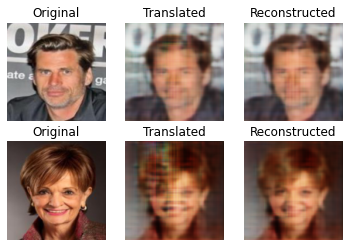

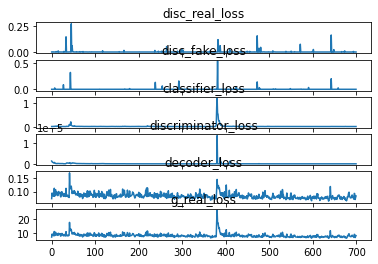

Train 0 / 100:  14%|█▍        | 700/5086 [1:36:50<30:18:20, 24.87s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0255e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9248e-05
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.2040 - classifier_loss: 0.0064 - discriminator_loss: 4.1165e-09 - decoder_loss: 0.0714


Train 0 / 100:  14%|█▍        | 701/5086 [1:36:58<24:02:07, 19.73s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1238e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0788e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.8092 - classifier_loss: 0.0079 - discriminator_loss: 3.1981e-09 - decoder_loss: 0.0773


Train 0 / 100:  14%|█▍        | 702/5086 [1:37:05<19:34:57, 16.08s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1007e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4865e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.2346 - classifier_loss: 0.0080 - discriminator_loss: 3.7458e-09 - decoder_loss: 0.0715


Train 0 / 100:  14%|█▍        | 703/5086 [1:37:13<16:32:48, 13.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5104e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0629e-06
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.7504 - classifier_loss: 0.0069 - discriminator_loss: 3.3330e-09 - decoder_loss: 0.0768


Train 0 / 100:  14%|█▍        | 704/5086 [1:37:20<14:19:50, 11.77s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1451e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 6.2166e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.1938 - classifier_loss: 0.0057 - discriminator_loss: 3.5572e-09 - decoder_loss: 0.0714


Train 0 / 100:  14%|█▍        | 705/5086 [1:37:28<12:47:05, 10.51s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8511e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5137e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.2051 - classifier_loss: 0.0084 - discriminator_loss: 3.6114e-09 - decoder_loss: 0.0912


Train 0 / 100:  14%|█▍        | 706/5086 [1:37:36<11:42:59,  9.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4463e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1155e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.5749 - classifier_loss: 0.0075 - discriminator_loss: 3.6079e-09 - decoder_loss: 0.0850


Train 0 / 100:  14%|█▍        | 707/5086 [1:37:43<10:57:38,  9.01s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2555e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8733e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2441 - classifier_loss: 0.0062 - discriminator_loss: 3.1573e-09 - decoder_loss: 0.0818


Train 0 / 100:  14%|█▍        | 708/5086 [1:37:51<10:27:25,  8.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4686e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0682e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6088 - classifier_loss: 0.0068 - discriminator_loss: 2.3295e-09 - decoder_loss: 0.0754


Train 0 / 100:  14%|█▍        | 709/5086 [1:37:58<10:05:14,  8.30s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1374e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3164e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9562 - classifier_loss: 0.0070 - discriminator_loss: 3.5526e-09 - decoder_loss: 0.0789


Train 0 / 100:  14%|█▍        | 710/5086 [1:38:06<9:50:04,  8.09s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9560e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9437e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6305 - classifier_loss: 0.0051 - discriminator_loss: 2.6075e-09 - decoder_loss: 0.0758


Train 0 / 100:  14%|█▍        | 711/5086 [1:38:13<9:38:35,  7.93s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6800e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8070e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.7710 - classifier_loss: 0.0058 - discriminator_loss: 2.8013e-09 - decoder_loss: 0.0871


Train 0 / 100:  14%|█▍        | 712/5086 [1:38:21<9:32:48,  7.86s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3186e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.7686e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3489 - classifier_loss: 0.0062 - discriminator_loss: 3.0806e-09 - decoder_loss: 0.0829


Train 0 / 100:  14%|█▍        | 713/5086 [1:38:29<9:26:04,  7.77s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7483e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3395e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.3343 - classifier_loss: 0.0060 - discriminator_loss: 3.2848e-09 - decoder_loss: 0.0927


Train 0 / 100:  14%|█▍        | 714/5086 [1:38:36<9:23:06,  7.73s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1533e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8753e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9731 - classifier_loss: 0.0063 - discriminator_loss: 3.6174e-09 - decoder_loss: 0.0791


Train 0 / 100:  14%|█▍        | 715/5086 [1:38:44<9:20:32,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.6506e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5368e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.1509 - classifier_loss: 0.0074 - discriminator_loss: 6.5832e-09 - decoder_loss: 0.0808


Train 0 / 100:  14%|█▍        | 716/5086 [1:38:52<9:17:40,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6575e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7969e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6392 - classifier_loss: 0.0063 - discriminator_loss: 3.2898e-09 - decoder_loss: 0.0758


Train 0 / 100:  14%|█▍        | 717/5086 [1:38:59<9:15:55,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5322e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4360e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.6299 - classifier_loss: 0.0063 - discriminator_loss: 3.9877e-09 - decoder_loss: 0.0757


Train 0 / 100:  14%|█▍        | 718/5086 [1:39:07<9:17:50,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1492e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6830e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.7925 - classifier_loss: 0.0137 - discriminator_loss: 4.1651e-09 - decoder_loss: 0.0766


Train 0 / 100:  14%|█▍        | 719/5086 [1:39:15<9:17:59,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9450e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1477e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2337 - classifier_loss: 0.0106 - discriminator_loss: 3.7340e-09 - decoder_loss: 0.0813


Train 0 / 100:  14%|█▍        | 720/5086 [1:39:22<9:17:21,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1500e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2810e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1957 - classifier_loss: 0.0071 - discriminator_loss: 4.2792e-09 - decoder_loss: 0.0812


Train 0 / 100:  14%|█▍        | 721/5086 [1:39:30<9:16:01,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0529e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5209e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0296 - classifier_loss: 0.0108 - discriminator_loss: 3.9188e-09 - decoder_loss: 0.0692


Train 0 / 100:  14%|█▍        | 722/5086 [1:39:37<9:15:56,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2949e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1107e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0467 - classifier_loss: 0.0091 - discriminator_loss: 3.8362e-09 - decoder_loss: 0.0796


Train 0 / 100:  14%|█▍        | 723/5086 [1:39:45<9:15:40,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6109e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3887e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.8669 - classifier_loss: 0.0086 - discriminator_loss: 3.7135e-09 - decoder_loss: 0.0878


Train 0 / 100:  14%|█▍        | 724/5086 [1:39:53<9:16:37,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4532e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1908e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2745 - classifier_loss: 0.0059 - discriminator_loss: 3.9439e-09 - decoder_loss: 0.0822


Train 0 / 100:  14%|█▍        | 725/5086 [1:40:00<9:14:51,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3452e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5594e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8580 - classifier_loss: 0.0065 - discriminator_loss: 3.4800e-09 - decoder_loss: 0.0779


Train 0 / 100:  14%|█▍        | 726/5086 [1:40:08<9:14:21,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8085e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1746e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7157 - classifier_loss: 0.0071 - discriminator_loss: 5.5877e-09 - decoder_loss: 0.0765


Train 0 / 100:  14%|█▍        | 727/5086 [1:40:16<9:14:17,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2619e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0931 - classifier_loss: 0.0060 - discriminator_loss: 3.4451e-09 - decoder_loss: 0.0703


Train 0 / 100:  14%|█▍        | 728/5086 [1:40:23<9:14:09,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3466e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9859e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3124 - classifier_loss: 0.0066 - discriminator_loss: 5.4144e-09 - decoder_loss: 0.0825


Train 0 / 100:  14%|█▍        | 729/5086 [1:40:31<9:12:53,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.7757e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2331e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.7269 - classifier_loss: 0.0082 - discriminator_loss: 4.4783e-09 - decoder_loss: 0.0865


Train 0 / 100:  14%|█▍        | 730/5086 [1:40:38<9:12:30,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1687e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7600e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2901 - classifier_loss: 0.0059 - discriminator_loss: 3.5307e-09 - decoder_loss: 0.0723


Train 0 / 100:  14%|█▍        | 731/5086 [1:40:46<9:11:03,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5211e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7160e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4545 - classifier_loss: 0.0060 - discriminator_loss: 4.1983e-09 - decoder_loss: 0.0739


Train 0 / 100:  14%|█▍        | 732/5086 [1:40:54<9:11:33,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2599e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6266e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3727 - classifier_loss: 0.0051 - discriminator_loss: 4.6136e-09 - decoder_loss: 0.0732


Train 0 / 100:  14%|█▍        | 733/5086 [1:41:01<9:11:49,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7678e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2765 - classifier_loss: 0.0057 - discriminator_loss: 3.4450e-09 - decoder_loss: 0.0822


Train 0 / 100:  14%|█▍        | 734/5086 [1:41:09<9:12:05,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0738e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0543e-08
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.9670 - classifier_loss: 0.0055 - discriminator_loss: 2.4353e-09 - decoder_loss: 0.0891


Train 0 / 100:  14%|█▍        | 735/5086 [1:41:17<9:14:38,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9919e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6440e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.6081 - classifier_loss: 0.0061 - discriminator_loss: 3.3562e-09 - decoder_loss: 0.0755


Train 0 / 100:  14%|█▍        | 736/5086 [1:41:24<9:13:38,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3958e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4589e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3795 - classifier_loss: 0.0071 - discriminator_loss: 2.0751e-09 - decoder_loss: 0.0731


Train 0 / 100:  14%|█▍        | 737/5086 [1:41:32<9:12:49,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2147e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0237e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4563 - classifier_loss: 0.0058 - discriminator_loss: 1.8191e-09 - decoder_loss: 0.0840


Train 0 / 100:  15%|█▍        | 738/5086 [1:41:39<9:11:59,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9709e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1228e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.6479 - classifier_loss: 0.0066 - discriminator_loss: 1.6573e-09 - decoder_loss: 0.0758


Train 0 / 100:  15%|█▍        | 739/5086 [1:41:47<9:11:51,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4137e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2493e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.8069 - classifier_loss: 0.0052 - discriminator_loss: 1.9891e-09 - decoder_loss: 0.0876


Train 0 / 100:  15%|█▍        | 740/5086 [1:41:55<9:12:16,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8641e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1128e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0500 - classifier_loss: 0.0056 - discriminator_loss: 2.6222e-09 - decoder_loss: 0.0799


Train 0 / 100:  15%|█▍        | 741/5086 [1:42:02<9:10:44,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0683e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0759e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9153 - classifier_loss: 0.0074 - discriminator_loss: 3.1165e-09 - decoder_loss: 0.0784


Train 0 / 100:  15%|█▍        | 742/5086 [1:42:10<9:10:45,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6969e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2846e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.5826 - classifier_loss: 0.0052 - discriminator_loss: 1.9144e-09 - decoder_loss: 0.0853


Train 0 / 100:  15%|█▍        | 743/5086 [1:42:17<9:09:49,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0710e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4297e-09
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.5290 - classifier_loss: 0.0063 - discriminator_loss: 1.7639e-09 - decoder_loss: 0.0847


Train 0 / 100:  15%|█▍        | 744/5086 [1:42:25<9:12:16,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2476e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6277e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1859 - classifier_loss: 0.0062 - discriminator_loss: 1.6538e-09 - decoder_loss: 0.0812


Train 0 / 100:  15%|█▍        | 745/5086 [1:42:33<9:11:33,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8716e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0166e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6738 - classifier_loss: 0.0047 - discriminator_loss: 2.0180e-09 - decoder_loss: 0.0763


Train 0 / 100:  15%|█▍        | 746/5086 [1:42:40<9:10:15,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6187e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8195e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4419 - classifier_loss: 0.0169 - discriminator_loss: 2.5234e-09 - decoder_loss: 0.0727


Train 0 / 100:  15%|█▍        | 747/5086 [1:42:48<9:09:28,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8229e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7279e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3957 - classifier_loss: 0.0079 - discriminator_loss: 1.9224e-09 - decoder_loss: 0.0832


Train 0 / 100:  15%|█▍        | 748/5086 [1:42:55<9:09:43,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0051e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3402e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1407 - classifier_loss: 0.0074 - discriminator_loss: 1.7399e-09 - decoder_loss: 0.0807


Train 0 / 100:  15%|█▍        | 749/5086 [1:43:03<9:09:23,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5627e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7158e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5123 - classifier_loss: 0.0065 - discriminator_loss: 2.3089e-09 - decoder_loss: 0.0745


Train 0 / 100:  15%|█▍        | 750/5086 [1:43:11<9:09:12,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3174e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0766e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5718 - classifier_loss: 0.0055 - discriminator_loss: 2.5002e-09 - decoder_loss: 0.0752


Train 0 / 100:  15%|█▍        | 751/5086 [1:43:18<9:09:03,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0477e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1669e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1755 - classifier_loss: 0.0066 - discriminator_loss: 1.8471e-09 - decoder_loss: 0.0811


Train 0 / 100:  15%|█▍        | 752/5086 [1:43:26<9:08:30,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0216e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 5.0450e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4335 - classifier_loss: 0.0057 - discriminator_loss: 1.7561e-09 - decoder_loss: 0.0738


Train 0 / 100:  15%|█▍        | 753/5086 [1:43:33<9:07:15,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0120e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0257e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.3591 - classifier_loss: 0.0069 - discriminator_loss: 1.8245e-09 - decoder_loss: 0.0829


Train 0 / 100:  15%|█▍        | 754/5086 [1:43:41<9:09:40,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3983e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6838e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1974 - classifier_loss: 0.0049 - discriminator_loss: 1.9332e-09 - decoder_loss: 0.0815


Train 0 / 100:  15%|█▍        | 755/5086 [1:43:49<9:08:51,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9067e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5376e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.5751 - classifier_loss: 0.0078 - discriminator_loss: 3.4248e-09 - decoder_loss: 0.0750


Train 0 / 100:  15%|█▍        | 756/5086 [1:43:56<9:11:17,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2051e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3394e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7180 - classifier_loss: 0.0061 - discriminator_loss: 2.1730e-09 - decoder_loss: 0.0766


Train 0 / 100:  15%|█▍        | 757/5086 [1:44:04<9:09:18,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2965e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2177e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7467 - classifier_loss: 0.0068 - discriminator_loss: 1.7909e-09 - decoder_loss: 0.0768


Train 0 / 100:  15%|█▍        | 758/5086 [1:44:12<9:09:31,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8110e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1364e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.1066 - classifier_loss: 0.0052 - discriminator_loss: 1.4973e-09 - decoder_loss: 0.0705


Train 0 / 100:  15%|█▍        | 759/5086 [1:44:19<9:07:43,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8048e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7771e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.5076 - classifier_loss: 0.0065 - discriminator_loss: 1.9349e-09 - decoder_loss: 0.0844


Train 0 / 100:  15%|█▍        | 760/5086 [1:44:27<9:06:55,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6498e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7596e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9270 - classifier_loss: 0.0059 - discriminator_loss: 1.9059e-09 - decoder_loss: 0.0787


Train 0 / 100:  15%|█▍        | 761/5086 [1:44:34<9:06:56,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3569e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7282e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5357 - classifier_loss: 0.0055 - discriminator_loss: 1.5280e-09 - decoder_loss: 0.0748


Train 0 / 100:  15%|█▍        | 762/5086 [1:44:42<9:07:52,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5859e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6178e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5868 - classifier_loss: 0.0049 - discriminator_loss: 1.6800e-09 - decoder_loss: 0.0754


Train 0 / 100:  15%|█▌        | 763/5086 [1:44:49<9:08:26,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2004e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2541e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8512 - classifier_loss: 0.0064 - discriminator_loss: 1.6550e-09 - decoder_loss: 0.0779


Train 0 / 100:  15%|█▌        | 764/5086 [1:44:57<9:08:43,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4742e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.9905e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2585 - classifier_loss: 0.0053 - discriminator_loss: 2.1278e-09 - decoder_loss: 0.0721


Train 0 / 100:  15%|█▌        | 765/5086 [1:45:05<9:08:56,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7773e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8044e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.4574 - classifier_loss: 0.0061 - discriminator_loss: 1.8544e-09 - decoder_loss: 0.0740


Train 0 / 100:  15%|█▌        | 766/5086 [1:45:12<9:09:30,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4775e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4654e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8474 - classifier_loss: 0.0053 - discriminator_loss: 1.6352e-09 - decoder_loss: 0.0779


Train 0 / 100:  15%|█▌        | 767/5086 [1:45:20<9:08:37,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2212e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4188e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8836 - classifier_loss: 0.0069 - discriminator_loss: 1.7007e-09 - decoder_loss: 0.0781


Train 0 / 100:  15%|█▌        | 768/5086 [1:45:28<9:07:08,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0800e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1383e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8310 - classifier_loss: 0.0055 - discriminator_loss: 1.5213e-09 - decoder_loss: 0.0778


Train 0 / 100:  15%|█▌        | 769/5086 [1:45:35<9:06:30,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7615e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6664e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6489 - classifier_loss: 0.0058 - discriminator_loss: 1.5341e-09 - decoder_loss: 0.0759


Train 0 / 100:  15%|█▌        | 770/5086 [1:45:43<9:06:25,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1226e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7829e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1169 - classifier_loss: 0.0061 - discriminator_loss: 1.8667e-09 - decoder_loss: 0.0706


Train 0 / 100:  15%|█▌        | 771/5086 [1:45:50<9:06:08,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8038e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9123e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 6.9406 - classifier_loss: 0.0060 - discriminator_loss: 1.6256e-09 - decoder_loss: 0.0688


Train 0 / 100:  15%|█▌        | 772/5086 [1:45:58<9:08:30,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5191e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2736 - classifier_loss: 0.0049 - discriminator_loss: 1.6339e-09 - decoder_loss: 0.0723


Train 0 / 100:  15%|█▌        | 773/5086 [1:46:06<9:07:58,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9348e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1642e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 6.7541 - classifier_loss: 0.0061 - discriminator_loss: 1.6263e-09 - decoder_loss: 0.0669


Train 0 / 100:  15%|█▌        | 774/5086 [1:46:13<9:09:30,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1352e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0465e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2202 - classifier_loss: 0.0057 - discriminator_loss: 1.5486e-09 - decoder_loss: 0.0716


Train 0 / 100:  15%|█▌        | 775/5086 [1:46:21<9:08:44,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0412e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3507e-07
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 7.1286 - classifier_loss: 0.0063 - discriminator_loss: 1.6256e-09 - decoder_loss: 0.0707


Train 0 / 100:  15%|█▌        | 776/5086 [1:46:29<9:11:10,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3237e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5173e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5617 - classifier_loss: 0.0053 - discriminator_loss: 1.5749e-09 - decoder_loss: 0.0751


Train 0 / 100:  15%|█▌        | 777/5086 [1:46:36<9:09:34,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6284e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 4.7079e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9462 - classifier_loss: 0.0055 - discriminator_loss: 1.6328e-09 - decoder_loss: 0.0789


Train 0 / 100:  15%|█▌        | 778/5086 [1:46:44<9:07:55,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1725e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0583e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2076 - classifier_loss: 0.0049 - discriminator_loss: 1.7967e-09 - decoder_loss: 0.0716


Train 0 / 100:  15%|█▌        | 779/5086 [1:46:52<9:07:58,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2407e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8963e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4836 - classifier_loss: 0.0047 - discriminator_loss: 1.9506e-09 - decoder_loss: 0.0744


Train 0 / 100:  15%|█▌        | 780/5086 [1:46:59<9:07:23,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6618e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5043e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.6623 - classifier_loss: 0.0049 - discriminator_loss: 1.8785e-09 - decoder_loss: 0.0761


Train 0 / 100:  15%|█▌        | 781/5086 [1:47:07<9:07:17,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3692e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4834e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2429 - classifier_loss: 0.0054 - discriminator_loss: 2.1047e-09 - decoder_loss: 0.0819


Train 0 / 100:  15%|█▌        | 782/5086 [1:47:14<9:06:50,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3640e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2502e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9552 - classifier_loss: 0.0049 - discriminator_loss: 1.9297e-09 - decoder_loss: 0.0791


Train 0 / 100:  15%|█▌        | 783/5086 [1:47:22<9:05:46,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9929e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7842e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2116 - classifier_loss: 0.0051 - discriminator_loss: 2.1587e-09 - decoder_loss: 0.0716


Train 0 / 100:  15%|█▌        | 784/5086 [1:47:30<9:06:05,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3316e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3506e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8671 - classifier_loss: 0.0044 - discriminator_loss: 2.1158e-09 - decoder_loss: 0.0782


Train 0 / 100:  15%|█▌        | 785/5086 [1:47:37<9:05:49,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7670e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6413e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7246 - classifier_loss: 0.0059 - discriminator_loss: 2.2968e-09 - decoder_loss: 0.0767


Train 0 / 100:  15%|█▌        | 786/5086 [1:47:45<9:06:10,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9028e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2992e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.4968 - classifier_loss: 0.0053 - discriminator_loss: 2.1532e-09 - decoder_loss: 0.0844


Train 0 / 100:  15%|█▌        | 787/5086 [1:47:52<9:06:21,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3320e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0751e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2126 - classifier_loss: 0.0056 - discriminator_loss: 1.9661e-09 - decoder_loss: 0.0716


Train 0 / 100:  15%|█▌        | 788/5086 [1:48:00<9:06:01,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3222e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6514e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1151 - classifier_loss: 0.0043 - discriminator_loss: 2.0099e-09 - decoder_loss: 0.0807


Train 0 / 100:  16%|█▌        | 789/5086 [1:48:08<9:05:29,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1366e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4884e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.8196 - classifier_loss: 0.0060 - discriminator_loss: 2.0829e-09 - decoder_loss: 0.0876


Train 0 / 100:  16%|█▌        | 790/5086 [1:48:15<9:03:55,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0846e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2529e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6827 - classifier_loss: 0.0063 - discriminator_loss: 2.2680e-09 - decoder_loss: 0.0862


Train 0 / 100:  16%|█▌        | 791/5086 [1:48:23<9:04:16,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5487e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8792e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9039 - classifier_loss: 0.0059 - discriminator_loss: 2.0359e-09 - decoder_loss: 0.0785


Train 0 / 100:  16%|█▌        | 792/5086 [1:48:30<9:03:46,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2169e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9380e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9722 - classifier_loss: 0.0058 - discriminator_loss: 2.5860e-09 - decoder_loss: 0.0791


Train 0 / 100:  16%|█▌        | 793/5086 [1:48:38<9:03:43,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7844e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6137e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.1372 - classifier_loss: 0.0064 - discriminator_loss: 2.2875e-09 - decoder_loss: 0.0807


Train 0 / 100:  16%|█▌        | 794/5086 [1:48:46<9:05:42,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8198e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7895e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9687 - classifier_loss: 0.0053 - discriminator_loss: 1.8937e-09 - decoder_loss: 0.0792


Train 0 / 100:  16%|█▌        | 795/5086 [1:48:53<9:04:21,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9601e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7625e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7630 - classifier_loss: 0.0055 - discriminator_loss: 1.7668e-09 - decoder_loss: 0.0771


Train 0 / 100:  16%|█▌        | 796/5086 [1:49:01<9:04:31,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1314e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7915e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3379 - classifier_loss: 0.0053 - discriminator_loss: 1.6872e-09 - decoder_loss: 0.0828


Train 0 / 100:  16%|█▌        | 797/5086 [1:49:09<9:04:36,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8968e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6056e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7175 - classifier_loss: 0.0052 - discriminator_loss: 2.3574e-09 - decoder_loss: 0.0767


Train 0 / 100:  16%|█▌        | 798/5086 [1:49:16<9:03:29,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8897e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2705e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3915 - classifier_loss: 0.0060 - discriminator_loss: 2.1704e-09 - decoder_loss: 0.0733


Train 0 / 100:  16%|█▌        | 799/5086 [1:49:24<9:03:16,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0443e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3465e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4343 - classifier_loss: 0.0056 - discriminator_loss: 2.3206e-09 - decoder_loss: 0.0738
Epoch: 0 with batch: 799


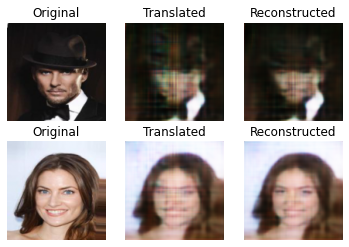

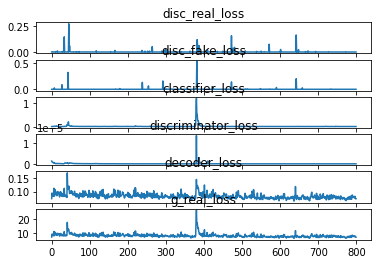

Train 0 / 100:  16%|█▌        | 800/5086 [1:50:32<30:41:13, 25.78s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3294e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2743e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3290 - classifier_loss: 0.0062 - discriminator_loss: 2.7700e-09 - decoder_loss: 0.0827


Train 0 / 100:  16%|█▌        | 801/5086 [1:50:40<24:14:37, 20.37s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8902e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0216e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.4526 - classifier_loss: 0.0050 - discriminator_loss: 2.8540e-09 - decoder_loss: 0.0840


Train 0 / 100:  16%|█▌        | 802/5086 [1:50:47<19:44:37, 16.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4384e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5855e-08
Epoch 1/1
32/32 [==============================] - 6s 178ms/step - loss: 8.5098 - classifier_loss: 0.0053 - discriminator_loss: 1.7186e-09 - decoder_loss: 0.0846


Train 0 / 100:  16%|█▌        | 803/5086 [1:50:55<16:30:52, 13.88s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0457e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9940e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.4280 - classifier_loss: 0.0049 - discriminator_loss: 1.7553e-09 - decoder_loss: 0.0738


Train 0 / 100:  16%|█▌        | 804/5086 [1:51:03<14:15:23, 11.99s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1020e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4011e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4947 - classifier_loss: 0.0053 - discriminator_loss: 2.1829e-09 - decoder_loss: 0.0744


Train 0 / 100:  16%|█▌        | 805/5086 [1:51:10<12:41:49, 10.68s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6453e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4137e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4484 - classifier_loss: 0.0049 - discriminator_loss: 1.8931e-09 - decoder_loss: 0.0740


Train 0 / 100:  16%|█▌        | 806/5086 [1:51:18<11:34:52,  9.74s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0369e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2831e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7167 - classifier_loss: 0.0058 - discriminator_loss: 2.3512e-09 - decoder_loss: 0.0766


Train 0 / 100:  16%|█▌        | 807/5086 [1:51:25<10:49:32,  9.11s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1619e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3304e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.5431 - classifier_loss: 0.0071 - discriminator_loss: 2.0325e-09 - decoder_loss: 0.0747


Train 0 / 100:  16%|█▌        | 808/5086 [1:51:33<10:16:07,  8.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4004e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4774e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2174 - classifier_loss: 0.0093 - discriminator_loss: 1.7025e-09 - decoder_loss: 0.0712


Train 0 / 100:  16%|█▌        | 809/5086 [1:51:41<9:56:01,  8.36s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6939e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9677e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2833 - classifier_loss: 0.0054 - discriminator_loss: 3.2751e-09 - decoder_loss: 0.0723


Train 0 / 100:  16%|█▌        | 810/5086 [1:51:48<9:39:13,  8.13s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7895e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2430e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6180 - classifier_loss: 0.0063 - discriminator_loss: 1.5960e-09 - decoder_loss: 0.0756


Train 0 / 100:  16%|█▌        | 811/5086 [1:51:56<9:28:00,  7.97s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8711e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7915e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3589 - classifier_loss: 0.0045 - discriminator_loss: 1.8675e-09 - decoder_loss: 0.0731


Train 0 / 100:  16%|█▌        | 812/5086 [1:52:03<9:20:10,  7.86s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8123e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7671e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6033 - classifier_loss: 0.0062 - discriminator_loss: 1.6219e-09 - decoder_loss: 0.0754


Train 0 / 100:  16%|█▌        | 813/5086 [1:52:11<9:15:31,  7.80s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9486e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7352e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.0255 - classifier_loss: 0.0052 - discriminator_loss: 1.7167e-09 - decoder_loss: 0.0697


Train 0 / 100:  16%|█▌        | 814/5086 [1:52:19<9:11:33,  7.75s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4392e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.1239e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3743 - classifier_loss: 0.0056 - discriminator_loss: 1.6644e-09 - decoder_loss: 0.0832


Train 0 / 100:  16%|█▌        | 815/5086 [1:52:26<9:08:35,  7.71s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3996e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8161e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0021 - classifier_loss: 0.0058 - discriminator_loss: 2.0053e-09 - decoder_loss: 0.0794


Train 0 / 100:  16%|█▌        | 816/5086 [1:52:34<9:07:23,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7560e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1054e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.7288 - classifier_loss: 0.0065 - discriminator_loss: 1.9105e-09 - decoder_loss: 0.0766


Train 0 / 100:  16%|█▌        | 817/5086 [1:52:42<9:06:55,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1819e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6557e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1819 - classifier_loss: 0.0044 - discriminator_loss: 2.2450e-09 - decoder_loss: 0.0714


Train 0 / 100:  16%|█▌        | 818/5086 [1:52:49<9:05:17,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3224e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5799e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2307 - classifier_loss: 0.0059 - discriminator_loss: 2.3725e-09 - decoder_loss: 0.0717


Train 0 / 100:  16%|█▌        | 819/5086 [1:52:57<9:05:22,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8394e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4368e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2799 - classifier_loss: 0.0059 - discriminator_loss: 1.6028e-09 - decoder_loss: 0.0722


Train 0 / 100:  16%|█▌        | 820/5086 [1:53:05<9:02:51,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2045e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0995e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7071 - classifier_loss: 0.0056 - discriminator_loss: 1.6302e-09 - decoder_loss: 0.0765


Train 0 / 100:  16%|█▌        | 821/5086 [1:53:12<9:01:44,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0389e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1890e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5475 - classifier_loss: 0.0059 - discriminator_loss: 2.3596e-09 - decoder_loss: 0.0749


Train 0 / 100:  16%|█▌        | 822/5086 [1:53:20<9:00:59,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8725e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5224e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.5193 - classifier_loss: 0.0063 - discriminator_loss: 2.0032e-09 - decoder_loss: 0.0846


Train 0 / 100:  16%|█▌        | 823/5086 [1:53:27<9:01:21,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5717e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0708e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8948 - classifier_loss: 0.0057 - discriminator_loss: 1.6208e-09 - decoder_loss: 0.0784


Train 0 / 100:  16%|█▌        | 824/5086 [1:53:35<9:00:41,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7146e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1861e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2301 - classifier_loss: 0.0051 - discriminator_loss: 1.7098e-09 - decoder_loss: 0.0718


Train 0 / 100:  16%|█▌        | 825/5086 [1:53:43<9:01:28,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4522e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5794e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5591 - classifier_loss: 0.0061 - discriminator_loss: 1.7692e-09 - decoder_loss: 0.0750


Train 0 / 100:  16%|█▌        | 826/5086 [1:53:50<9:00:19,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9731e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0004e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9006 - classifier_loss: 0.0051 - discriminator_loss: 1.9800e-09 - decoder_loss: 0.0785


Train 0 / 100:  16%|█▋        | 827/5086 [1:53:58<9:00:16,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4052e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8848e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1908 - classifier_loss: 0.0072 - discriminator_loss: 2.6800e-09 - decoder_loss: 0.0812


Train 0 / 100:  16%|█▋        | 828/5086 [1:54:05<9:00:34,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7335e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4468e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8340 - classifier_loss: 0.0064 - discriminator_loss: 1.6998e-09 - decoder_loss: 0.0777


Train 0 / 100:  16%|█▋        | 829/5086 [1:54:13<8:59:57,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4768e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4829e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.1139 - classifier_loss: 0.0065 - discriminator_loss: 1.5483e-09 - decoder_loss: 0.0805


Train 0 / 100:  16%|█▋        | 830/5086 [1:54:21<8:59:45,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2277e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9485e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.2076 - classifier_loss: 0.0064 - discriminator_loss: 1.7915e-09 - decoder_loss: 0.0914


Train 0 / 100:  16%|█▋        | 831/5086 [1:54:28<9:00:47,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7604e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4888e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.3600 - classifier_loss: 0.0065 - discriminator_loss: 2.0477e-09 - decoder_loss: 0.0729


Train 0 / 100:  16%|█▋        | 832/5086 [1:54:36<9:00:48,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9804e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7168e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.2471 - classifier_loss: 0.0054 - discriminator_loss: 1.4985e-09 - decoder_loss: 0.0819


Train 0 / 100:  16%|█▋        | 833/5086 [1:54:44<9:02:34,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3247e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9447e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.1556 - classifier_loss: 0.0058 - discriminator_loss: 1.4211e-09 - decoder_loss: 0.0710


Train 0 / 100:  16%|█▋        | 834/5086 [1:54:51<9:02:14,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7188e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5438e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.0267 - classifier_loss: 0.0060 - discriminator_loss: 1.5380e-09 - decoder_loss: 0.0897


Train 0 / 100:  16%|█▋        | 835/5086 [1:54:59<9:02:14,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2893e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8976e-09
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 9.0335 - classifier_loss: 0.0055 - discriminator_loss: 1.5838e-09 - decoder_loss: 0.0898


Train 0 / 100:  16%|█▋        | 836/5086 [1:55:07<9:03:19,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6749e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9107e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2147 - classifier_loss: 0.0048 - discriminator_loss: 2.1363e-09 - decoder_loss: 0.0817


Train 0 / 100:  16%|█▋        | 837/5086 [1:55:14<9:02:52,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0251e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.2717e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2743 - classifier_loss: 0.0046 - discriminator_loss: 2.0426e-09 - decoder_loss: 0.0823


Train 0 / 100:  16%|█▋        | 838/5086 [1:55:22<9:01:58,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3183e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4344e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2743 - classifier_loss: 0.0058 - discriminator_loss: 1.6142e-09 - decoder_loss: 0.0822


Train 0 / 100:  16%|█▋        | 839/5086 [1:55:30<9:01:31,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9449e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3312e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.4297 - classifier_loss: 0.0109 - discriminator_loss: 1.7726e-09 - decoder_loss: 0.0932


Train 0 / 100:  17%|█▋        | 840/5086 [1:55:37<9:00:49,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0573e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4018e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.0315 - classifier_loss: 0.0066 - discriminator_loss: 1.7294e-09 - decoder_loss: 0.0997


Train 0 / 100:  17%|█▋        | 841/5086 [1:55:45<8:59:56,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6900e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4698e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6735 - classifier_loss: 0.0058 - discriminator_loss: 1.6594e-09 - decoder_loss: 0.0862


Train 0 / 100:  17%|█▋        | 842/5086 [1:55:52<8:58:46,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6071e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3295e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6808 - classifier_loss: 0.0054 - discriminator_loss: 2.2397e-09 - decoder_loss: 0.0763


Train 0 / 100:  17%|█▋        | 843/5086 [1:56:00<8:59:04,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8605e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3622e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.2726 - classifier_loss: 0.0054 - discriminator_loss: 1.7077e-09 - decoder_loss: 0.0822


Train 0 / 100:  17%|█▋        | 844/5086 [1:56:08<8:58:19,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1809e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3918e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7992 - classifier_loss: 0.0064 - discriminator_loss: 1.4297e-09 - decoder_loss: 0.0774


Train 0 / 100:  17%|█▋        | 845/5086 [1:56:15<8:57:57,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0245e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6679e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.4687 - classifier_loss: 0.0055 - discriminator_loss: 1.5062e-09 - decoder_loss: 0.0841


Train 0 / 100:  17%|█▋        | 846/5086 [1:56:23<8:59:13,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.9601e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1930e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7319 - classifier_loss: 0.0064 - discriminator_loss: 1.8546e-09 - decoder_loss: 0.0867


Train 0 / 100:  17%|█▋        | 847/5086 [1:56:31<8:59:23,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1469e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4857e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0284 - classifier_loss: 0.0078 - discriminator_loss: 1.2781e-09 - decoder_loss: 0.0795


Train 0 / 100:  17%|█▋        | 848/5086 [1:56:38<8:59:47,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3019e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6244e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.5494 - classifier_loss: 0.0069 - discriminator_loss: 1.3063e-09 - decoder_loss: 0.0848


Train 0 / 100:  17%|█▋        | 849/5086 [1:56:46<9:00:24,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5269e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4087e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.8546 - classifier_loss: 0.0066 - discriminator_loss: 1.5250e-09 - decoder_loss: 0.0879


Train 0 / 100:  17%|█▋        | 850/5086 [1:56:54<9:01:35,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4758e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3751e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2968 - classifier_loss: 0.0077 - discriminator_loss: 2.5662e-09 - decoder_loss: 0.0822


Train 0 / 100:  17%|█▋        | 851/5086 [1:57:01<9:01:01,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6699e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9124e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1175 - classifier_loss: 0.0059 - discriminator_loss: 1.7867e-09 - decoder_loss: 0.0806


Train 0 / 100:  17%|█▋        | 852/5086 [1:57:09<8:59:25,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5883e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.1973e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.8754 - classifier_loss: 0.0064 - discriminator_loss: 1.8142e-09 - decoder_loss: 0.0881


Train 0 / 100:  17%|█▋        | 853/5086 [1:57:16<8:58:55,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2529e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8143e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0273 - classifier_loss: 0.0068 - discriminator_loss: 1.3333e-09 - decoder_loss: 0.0796


Train 0 / 100:  17%|█▋        | 854/5086 [1:57:24<8:58:03,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6919e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8114e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.7824 - classifier_loss: 0.0051 - discriminator_loss: 1.5118e-09 - decoder_loss: 0.0773


Train 0 / 100:  17%|█▋        | 855/5086 [1:57:32<8:59:55,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0429
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0713e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8249 - classifier_loss: 0.0068 - discriminator_loss: 7.4329e-09 - decoder_loss: 0.0776


Train 0 / 100:  17%|█▋        | 856/5086 [1:57:39<8:59:13,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2458e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0496e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2876 - classifier_loss: 0.0066 - discriminator_loss: 7.9591e-09 - decoder_loss: 0.0822


Train 0 / 100:  17%|█▋        | 857/5086 [1:57:47<8:58:01,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7454e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3424e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3401 - classifier_loss: 0.0052 - discriminator_loss: 2.1381e-08 - decoder_loss: 0.0729


Train 0 / 100:  17%|█▋        | 858/5086 [1:57:55<8:57:01,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2630e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5330 - classifier_loss: 0.0054 - discriminator_loss: 7.1101e-09 - decoder_loss: 0.0748


Train 0 / 100:  17%|█▋        | 859/5086 [1:58:02<8:57:10,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3876e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.1287
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7970 - classifier_loss: 0.0051 - discriminator_loss: 2.0206e-09 - decoder_loss: 0.0775


Train 0 / 100:  17%|█▋        | 860/5086 [1:58:10<8:55:24,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5878e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3563e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0077 - classifier_loss: 0.0061 - discriminator_loss: 8.2309e-10 - decoder_loss: 0.0795


Train 0 / 100:  17%|█▋        | 861/5086 [1:58:17<8:57:12,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0338
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4387e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.6087 - classifier_loss: 0.0049 - discriminator_loss: 5.0692e-09 - decoder_loss: 0.0756


Train 0 / 100:  17%|█▋        | 862/5086 [1:58:25<8:58:36,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6553e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7149e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5937 - classifier_loss: 0.0058 - discriminator_loss: 1.6703e-08 - decoder_loss: 0.0754


Train 0 / 100:  17%|█▋        | 863/5086 [1:58:33<8:58:09,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0227e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9662e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6170 - classifier_loss: 0.0054 - discriminator_loss: 2.2477e-08 - decoder_loss: 0.0756


Train 0 / 100:  17%|█▋        | 864/5086 [1:58:40<8:56:49,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2928e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2644e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.7526 - classifier_loss: 0.0047 - discriminator_loss: 1.0237e-08 - decoder_loss: 0.0671


Train 0 / 100:  17%|█▋        | 865/5086 [1:58:48<8:56:31,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0436e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5331e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2277 - classifier_loss: 0.0057 - discriminator_loss: 1.1335e-08 - decoder_loss: 0.0717


Train 0 / 100:  17%|█▋        | 866/5086 [1:58:56<8:56:02,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1183e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8704e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4791 - classifier_loss: 0.0050 - discriminator_loss: 1.2259e-08 - decoder_loss: 0.0743


Train 0 / 100:  17%|█▋        | 867/5086 [1:59:03<8:56:54,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7488e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2877e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7857 - classifier_loss: 0.0049 - discriminator_loss: 1.4411e-08 - decoder_loss: 0.0774


Train 0 / 100:  17%|█▋        | 868/5086 [1:59:11<8:57:05,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1733e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.7819 - classifier_loss: 0.0045 - discriminator_loss: 1.1425e-08 - decoder_loss: 0.0874


Train 0 / 100:  17%|█▋        | 869/5086 [1:59:19<8:57:22,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6967e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5993e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6154 - classifier_loss: 0.0081 - discriminator_loss: 1.1933e-08 - decoder_loss: 0.0853


Train 0 / 100:  17%|█▋        | 870/5086 [1:59:26<8:56:15,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6467e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2440e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9274 - classifier_loss: 0.0073 - discriminator_loss: 6.8376e-09 - decoder_loss: 0.0685


Train 0 / 100:  17%|█▋        | 871/5086 [1:59:34<8:55:29,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3040e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7644e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4441 - classifier_loss: 0.0210 - discriminator_loss: 5.8362e-09 - decoder_loss: 0.0723


Train 0 / 100:  17%|█▋        | 872/5086 [1:59:41<8:54:00,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2096e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8637e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.0268 - classifier_loss: 0.1745 - discriminator_loss: 5.7912e-09 - decoder_loss: 0.0728


Train 0 / 100:  17%|█▋        | 873/5086 [1:59:49<8:55:07,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8703e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 18.9418 - classifier_loss: 1.0497 - discriminator_loss: 1.5720e-08 - decoder_loss: 0.0844


Train 0 / 100:  17%|█▋        | 874/5086 [1:59:57<8:54:48,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3842e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4308e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 16.2198 - classifier_loss: 0.5869 - discriminator_loss: 3.9581e-06 - decoder_loss: 0.1035


Train 0 / 100:  17%|█▋        | 875/5086 [2:00:04<8:54:31,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0140
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2346e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 14.5389 - classifier_loss: 0.3921 - discriminator_loss: 4.6448e-06 - decoder_loss: 0.1062


Train 0 / 100:  17%|█▋        | 876/5086 [2:00:12<8:54:52,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8751e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3646e-04
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 11.8601 - classifier_loss: 0.1939 - discriminator_loss: 6.6284e-05 - decoder_loss: 0.0992


Train 0 / 100:  17%|█▋        | 877/5086 [2:00:20<8:55:09,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0563e-06
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 11.9297 - classifier_loss: 0.1839 - discriminator_loss: 2.6729e-08 - decoder_loss: 0.1009


Train 0 / 100:  17%|█▋        | 878/5086 [2:00:27<8:56:20,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5157e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.7808 - classifier_loss: 0.1141 - discriminator_loss: 3.7511e-09 - decoder_loss: 0.0864


Train 0 / 100:  17%|█▋        | 879/5086 [2:00:35<8:56:15,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0296e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1075e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.2688 - classifier_loss: 0.0660 - discriminator_loss: 8.8051e-10 - decoder_loss: 0.0861


Train 0 / 100:  17%|█▋        | 880/5086 [2:00:43<8:56:07,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8183e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3034e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.7127 - classifier_loss: 0.0836 - discriminator_loss: 5.7532e-10 - decoder_loss: 0.0988


Train 0 / 100:  17%|█▋        | 881/5086 [2:00:50<8:56:13,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6003e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7409e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4210 - classifier_loss: 0.0409 - discriminator_loss: 3.9332e-10 - decoder_loss: 0.0801


Train 0 / 100:  17%|█▋        | 882/5086 [2:00:58<8:54:57,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0370
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8254e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.5350 - classifier_loss: 0.0444 - discriminator_loss: 1.0631e-07 - decoder_loss: 0.0909


Train 0 / 100:  17%|█▋        | 883/5086 [2:01:05<8:54:46,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8674e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6296e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.5289 - classifier_loss: 0.0337 - discriminator_loss: 6.6970e-08 - decoder_loss: 0.0819


Train 0 / 100:  17%|█▋        | 884/5086 [2:01:13<8:53:06,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4619e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0259
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.2885 - classifier_loss: 0.0267 - discriminator_loss: 2.8899e-09 - decoder_loss: 0.0902


Train 0 / 100:  17%|█▋        | 885/5086 [2:01:21<8:53:02,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7971e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9003e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6029 - classifier_loss: 0.0323 - discriminator_loss: 2.2848e-10 - decoder_loss: 0.0828


Train 0 / 100:  17%|█▋        | 886/5086 [2:01:28<8:52:19,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5383e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3616e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.6298 - classifier_loss: 0.0277 - discriminator_loss: 2.4388e-10 - decoder_loss: 0.0835


Train 0 / 100:  17%|█▋        | 887/5086 [2:01:36<8:52:04,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0247e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1557e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.0932 - classifier_loss: 0.0225 - discriminator_loss: 2.1526e-10 - decoder_loss: 0.0887


Train 0 / 100:  17%|█▋        | 888/5086 [2:01:43<8:51:04,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3457e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3052e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5573 - classifier_loss: 0.0237 - discriminator_loss: 1.5056e-10 - decoder_loss: 0.0732


Train 0 / 100:  17%|█▋        | 889/5086 [2:01:51<8:50:47,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2021e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7744e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1813 - classifier_loss: 0.0168 - discriminator_loss: 2.8522e-10 - decoder_loss: 0.0801


Train 0 / 100:  17%|█▋        | 890/5086 [2:01:59<8:51:59,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3273e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5557e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4575 - classifier_loss: 0.0288 - discriminator_loss: 1.2118e-10 - decoder_loss: 0.0817


Train 0 / 100:  18%|█▊        | 891/5086 [2:02:06<8:52:35,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7390e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5367e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7160 - classifier_loss: 0.0175 - discriminator_loss: 1.0959e-10 - decoder_loss: 0.0754


Train 0 / 100:  18%|█▊        | 892/5086 [2:02:14<8:52:34,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5502e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3569e-10
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.5747 - classifier_loss: 0.0122 - discriminator_loss: 1.2665e-10 - decoder_loss: 0.0745


Train 0 / 100:  18%|█▊        | 893/5086 [2:02:22<8:54:18,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8934e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9268e-10
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.4349 - classifier_loss: 0.0173 - discriminator_loss: 1.1786e-10 - decoder_loss: 0.0726


Train 0 / 100:  18%|█▊        | 894/5086 [2:02:29<8:54:58,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1909e-10
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0751 - classifier_loss: 0.0144 - discriminator_loss: 1.0812e-10 - decoder_loss: 0.0793


Train 0 / 100:  18%|█▊        | 895/5086 [2:02:37<8:53:29,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4354e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0397e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.2161 - classifier_loss: 0.0160 - discriminator_loss: 1.7192e-10 - decoder_loss: 0.0706


Train 0 / 100:  18%|█▊        | 896/5086 [2:02:44<8:51:00,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7614e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8898e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1631 - classifier_loss: 0.0151 - discriminator_loss: 1.9871e-10 - decoder_loss: 0.0701


Train 0 / 100:  18%|█▊        | 897/5086 [2:02:52<8:50:24,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7342e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.9969e-10
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2995 - classifier_loss: 0.0151 - discriminator_loss: 1.0111e-10 - decoder_loss: 0.0715


Train 0 / 100:  18%|█▊        | 898/5086 [2:03:00<8:49:51,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0123e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0565e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0089 - classifier_loss: 0.0136 - discriminator_loss: 2.0222e-10 - decoder_loss: 0.0787


Train 0 / 100:  18%|█▊        | 899/5086 [2:03:07<8:50:41,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.6503e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0389e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.5219 - classifier_loss: 0.0131 - discriminator_loss: 1.7479e-10 - decoder_loss: 0.0839
Epoch: 0 with batch: 899


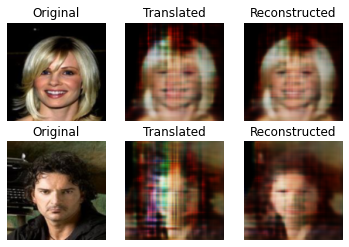

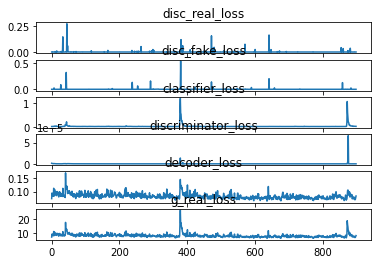

Train 0 / 100:  18%|█▊        | 900/5086 [2:04:14<29:26:19, 25.32s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9534e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1169e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8410 - classifier_loss: 0.0120 - discriminator_loss: 1.1705e-10 - decoder_loss: 0.0772


Train 0 / 100:  18%|█▊        | 901/5086 [2:04:22<23:17:33, 20.04s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0692e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9412e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.0660 - classifier_loss: 0.0142 - discriminator_loss: 1.0264e-10 - decoder_loss: 0.0792


Train 0 / 100:  18%|█▊        | 902/5086 [2:04:29<18:58:01, 16.32s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0717e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4704e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.8061 - classifier_loss: 0.0097 - discriminator_loss: 1.1078e-10 - decoder_loss: 0.0771


Train 0 / 100:  18%|█▊        | 903/5086 [2:04:37<15:59:00, 13.76s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2681e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4112e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.0572 - classifier_loss: 0.0107 - discriminator_loss: 1.3851e-10 - decoder_loss: 0.0795


Train 0 / 100:  18%|█▊        | 904/5086 [2:04:44<13:49:02, 11.89s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8513e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8355e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.3823 - classifier_loss: 0.0129 - discriminator_loss: 1.9744e-10 - decoder_loss: 0.0725


Train 0 / 100:  18%|█▊        | 905/5086 [2:04:52<12:17:16, 10.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0156e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0436e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7134 - classifier_loss: 0.0116 - discriminator_loss: 1.4564e-10 - decoder_loss: 0.0860


Train 0 / 100:  18%|█▊        | 906/5086 [2:05:00<11:15:38,  9.70s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1076e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2223e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5919 - classifier_loss: 0.0091 - discriminator_loss: 1.3834e-10 - decoder_loss: 0.0750


Train 0 / 100:  18%|█▊        | 907/5086 [2:05:07<10:32:11,  9.08s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8239e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0066e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.1337 - classifier_loss: 0.0110 - discriminator_loss: 8.8060e-11 - decoder_loss: 0.0702


Train 0 / 100:  18%|█▊        | 908/5086 [2:05:15<10:00:06,  8.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8559e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3615e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9235 - classifier_loss: 0.0118 - discriminator_loss: 1.1621e-10 - decoder_loss: 0.0781


Train 0 / 100:  18%|█▊        | 909/5086 [2:05:22<9:39:12,  8.32s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.7797e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4195e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2538 - classifier_loss: 0.0092 - discriminator_loss: 8.8425e-11 - decoder_loss: 0.0816


Train 0 / 100:  18%|█▊        | 910/5086 [2:05:30<9:24:30,  8.11s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9928e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9747e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.9341 - classifier_loss: 0.0115 - discriminator_loss: 1.2246e-10 - decoder_loss: 0.0782


Train 0 / 100:  18%|█▊        | 911/5086 [2:05:38<9:15:22,  7.98s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1928e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5960e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0175 - classifier_loss: 0.0092 - discriminator_loss: 1.0957e-10 - decoder_loss: 0.0793


Train 0 / 100:  18%|█▊        | 912/5086 [2:05:45<9:07:16,  7.87s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1797e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4493e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5821 - classifier_loss: 0.0101 - discriminator_loss: 1.2280e-10 - decoder_loss: 0.0748


Train 0 / 100:  18%|█▊        | 913/5086 [2:05:53<9:01:00,  7.78s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3702e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8568e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5436 - classifier_loss: 0.0099 - discriminator_loss: 1.2211e-10 - decoder_loss: 0.0744


Train 0 / 100:  18%|█▊        | 914/5086 [2:06:01<8:57:06,  7.72s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2005e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.5404e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6542 - classifier_loss: 0.0175 - discriminator_loss: 1.0485e-10 - decoder_loss: 0.0748


Train 0 / 100:  18%|█▊        | 915/5086 [2:06:08<8:53:15,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7372e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4377e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.4354 - classifier_loss: 0.0123 - discriminator_loss: 7.8342e-11 - decoder_loss: 0.0831


Train 0 / 100:  18%|█▊        | 916/5086 [2:06:16<8:51:58,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0020e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7120e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0772 - classifier_loss: 0.0156 - discriminator_loss: 9.6743e-11 - decoder_loss: 0.0692


Train 0 / 100:  18%|█▊        | 917/5086 [2:06:23<8:50:24,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4001e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1659e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3597 - classifier_loss: 0.0099 - discriminator_loss: 1.4323e-10 - decoder_loss: 0.0826


Train 0 / 100:  18%|█▊        | 918/5086 [2:06:31<8:50:13,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0632e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1194e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5471 - classifier_loss: 0.0151 - discriminator_loss: 1.0059e-10 - decoder_loss: 0.0740


Train 0 / 100:  18%|█▊        | 919/5086 [2:06:39<8:49:56,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0562e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7905e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3453 - classifier_loss: 0.0125 - discriminator_loss: 7.8554e-11 - decoder_loss: 0.0722


Train 0 / 100:  18%|█▊        | 920/5086 [2:06:46<8:49:07,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6030e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0362e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7818 - classifier_loss: 0.0096 - discriminator_loss: 6.8045e-11 - decoder_loss: 0.0769


Train 0 / 100:  18%|█▊        | 921/5086 [2:06:54<8:48:07,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2581e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0070e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0337 - classifier_loss: 0.0212 - discriminator_loss: 7.0425e-11 - decoder_loss: 0.0782


Train 0 / 100:  18%|█▊        | 922/5086 [2:07:01<8:47:18,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2387e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5227e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4436 - classifier_loss: 0.0111 - discriminator_loss: 8.7590e-11 - decoder_loss: 0.0733


Train 0 / 100:  18%|█▊        | 923/5086 [2:07:09<8:48:17,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6504e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6373e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4820 - classifier_loss: 0.0119 - discriminator_loss: 7.9746e-11 - decoder_loss: 0.0736


Train 0 / 100:  18%|█▊        | 924/5086 [2:07:17<8:48:29,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6848e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5429e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.3201 - classifier_loss: 0.0122 - discriminator_loss: 7.5608e-11 - decoder_loss: 0.0720


Train 0 / 100:  18%|█▊        | 925/5086 [2:07:24<8:49:10,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.2315e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9466e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4582 - classifier_loss: 0.0101 - discriminator_loss: 1.0264e-10 - decoder_loss: 0.0736


Train 0 / 100:  18%|█▊        | 926/5086 [2:07:32<8:49:01,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9270e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2555e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5114 - classifier_loss: 0.0100 - discriminator_loss: 7.4199e-11 - decoder_loss: 0.0741


Train 0 / 100:  18%|█▊        | 927/5086 [2:07:39<8:49:12,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8246e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4077e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.7880 - classifier_loss: 0.0101 - discriminator_loss: 8.8706e-11 - decoder_loss: 0.0869


Train 0 / 100:  18%|█▊        | 928/5086 [2:07:47<8:48:14,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1762e-05
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.2405e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.3341 - classifier_loss: 0.0096 - discriminator_loss: 6.7635e-11 - decoder_loss: 0.0724


Train 0 / 100:  18%|█▊        | 929/5086 [2:07:55<8:49:04,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0348e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0750e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.6562 - classifier_loss: 0.0109 - discriminator_loss: 5.2855e-11 - decoder_loss: 0.0855


Train 0 / 100:  18%|█▊        | 930/5086 [2:08:02<8:49:32,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5444e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2245e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5149 - classifier_loss: 0.0085 - discriminator_loss: 5.5296e-11 - decoder_loss: 0.0743


Train 0 / 100:  18%|█▊        | 931/5086 [2:08:10<8:47:54,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3242e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1899e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4722 - classifier_loss: 0.0100 - discriminator_loss: 9.5593e-11 - decoder_loss: 0.0837


Train 0 / 100:  18%|█▊        | 932/5086 [2:08:18<8:48:07,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5284e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8167e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0012 - classifier_loss: 0.0102 - discriminator_loss: 9.0699e-11 - decoder_loss: 0.0690


Train 0 / 100:  18%|█▊        | 933/5086 [2:08:25<8:47:25,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9595e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6316e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3944 - classifier_loss: 0.0081 - discriminator_loss: 7.2499e-11 - decoder_loss: 0.0831


Train 0 / 100:  18%|█▊        | 934/5086 [2:08:33<8:46:21,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2323e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9642e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5882 - classifier_loss: 0.0092 - discriminator_loss: 5.2292e-11 - decoder_loss: 0.0750


Train 0 / 100:  18%|█▊        | 935/5086 [2:08:40<8:46:21,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6334e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1896e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4090 - classifier_loss: 0.0100 - discriminator_loss: 4.8033e-11 - decoder_loss: 0.0731


Train 0 / 100:  18%|█▊        | 936/5086 [2:08:48<8:46:22,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8149e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6304e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4453 - classifier_loss: 0.0072 - discriminator_loss: 6.6564e-11 - decoder_loss: 0.0737


Train 0 / 100:  18%|█▊        | 937/5086 [2:08:56<8:45:25,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3505e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4328e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6296 - classifier_loss: 0.0095 - discriminator_loss: 6.8662e-11 - decoder_loss: 0.0753


Train 0 / 100:  18%|█▊        | 938/5086 [2:09:03<8:45:37,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0808e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1299e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8818 - classifier_loss: 0.0083 - discriminator_loss: 8.4584e-11 - decoder_loss: 0.0780


Train 0 / 100:  18%|█▊        | 939/5086 [2:09:11<8:45:50,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3832e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.1866 - classifier_loss: 0.0085 - discriminator_loss: 9.4162e-11 - decoder_loss: 0.0710


Train 0 / 100:  18%|█▊        | 940/5086 [2:09:18<8:46:56,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5403e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4086e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9371 - classifier_loss: 0.0090 - discriminator_loss: 1.1831e-10 - decoder_loss: 0.0685


Train 0 / 100:  19%|█▊        | 941/5086 [2:09:26<8:46:44,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1560e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1557e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5923 - classifier_loss: 0.0083 - discriminator_loss: 1.1794e-10 - decoder_loss: 0.0751


Train 0 / 100:  19%|█▊        | 942/5086 [2:09:34<8:46:39,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1724e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9693e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3954 - classifier_loss: 0.0083 - discriminator_loss: 1.0110e-10 - decoder_loss: 0.0731


Train 0 / 100:  19%|█▊        | 943/5086 [2:09:41<8:46:25,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6997e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1779e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4916 - classifier_loss: 0.0089 - discriminator_loss: 1.5202e-10 - decoder_loss: 0.0740


Train 0 / 100:  19%|█▊        | 944/5086 [2:09:49<8:45:38,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2463e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9761e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8449 - classifier_loss: 0.0071 - discriminator_loss: 9.8517e-11 - decoder_loss: 0.0777


Train 0 / 100:  19%|█▊        | 945/5086 [2:09:57<8:45:18,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2629e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0428e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.1211 - classifier_loss: 0.0064 - discriminator_loss: 9.0798e-11 - decoder_loss: 0.0806


Train 0 / 100:  19%|█▊        | 946/5086 [2:10:04<8:45:57,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0495e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2485e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4447 - classifier_loss: 0.0070 - discriminator_loss: 9.2399e-11 - decoder_loss: 0.0837


Train 0 / 100:  19%|█▊        | 947/5086 [2:10:12<8:45:27,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1284e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6897e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5521 - classifier_loss: 0.0072 - discriminator_loss: 1.0310e-10 - decoder_loss: 0.0848


Train 0 / 100:  19%|█▊        | 948/5086 [2:10:19<8:45:22,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5138e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9159e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3905 - classifier_loss: 0.0061 - discriminator_loss: 1.1305e-10 - decoder_loss: 0.0833


Train 0 / 100:  19%|█▊        | 949/5086 [2:10:27<8:44:44,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4485e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4625e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6596 - classifier_loss: 0.0128 - discriminator_loss: 1.4951e-10 - decoder_loss: 0.0753


Train 0 / 100:  19%|█▊        | 950/5086 [2:10:35<8:44:15,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7886e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0527e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3689 - classifier_loss: 0.0081 - discriminator_loss: 9.8424e-11 - decoder_loss: 0.0729


Train 0 / 100:  19%|█▊        | 951/5086 [2:10:42<8:44:23,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9236e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3677e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5025 - classifier_loss: 0.0078 - discriminator_loss: 1.0522e-10 - decoder_loss: 0.0742


Train 0 / 100:  19%|█▊        | 952/5086 [2:10:50<8:43:29,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0480e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8031e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9244 - classifier_loss: 0.0074 - discriminator_loss: 1.1015e-10 - decoder_loss: 0.0685


Train 0 / 100:  19%|█▊        | 953/5086 [2:10:57<8:43:50,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.6475e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9679e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0252 - classifier_loss: 0.0080 - discriminator_loss: 1.0836e-10 - decoder_loss: 0.0694


Train 0 / 100:  19%|█▉        | 954/5086 [2:11:05<8:43:35,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2967e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6270e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.9288 - classifier_loss: 0.0086 - discriminator_loss: 1.0027e-10 - decoder_loss: 0.0684


Train 0 / 100:  19%|█▉        | 955/5086 [2:11:13<8:44:34,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3849e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4762e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9849 - classifier_loss: 0.0088 - discriminator_loss: 9.7999e-11 - decoder_loss: 0.0790


Train 0 / 100:  19%|█▉        | 956/5086 [2:11:20<8:44:30,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5567e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8614e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2655 - classifier_loss: 0.0088 - discriminator_loss: 1.1239e-10 - decoder_loss: 0.0718


Train 0 / 100:  19%|█▉        | 957/5086 [2:11:28<8:44:10,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7967e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2287e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0923 - classifier_loss: 0.0103 - discriminator_loss: 1.4302e-10 - decoder_loss: 0.0699


Train 0 / 100:  19%|█▉        | 958/5086 [2:11:36<8:44:00,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.1531e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6520e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0651 - classifier_loss: 0.0068 - discriminator_loss: 7.9375e-11 - decoder_loss: 0.0800


Train 0 / 100:  19%|█▉        | 959/5086 [2:11:43<8:43:36,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4560e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1791e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5585 - classifier_loss: 0.0074 - discriminator_loss: 9.2949e-11 - decoder_loss: 0.0748


Train 0 / 100:  19%|█▉        | 960/5086 [2:11:51<8:43:46,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3610e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6397e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4238 - classifier_loss: 0.0061 - discriminator_loss: 6.7575e-11 - decoder_loss: 0.0736


Train 0 / 100:  19%|█▉        | 961/5086 [2:11:58<8:43:35,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1120e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6985e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6887 - classifier_loss: 0.0081 - discriminator_loss: 7.3786e-11 - decoder_loss: 0.0761


Train 0 / 100:  19%|█▉        | 962/5086 [2:12:06<8:42:13,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6484e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1570e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.1526 - classifier_loss: 0.0070 - discriminator_loss: 8.1289e-11 - decoder_loss: 0.0708


Train 0 / 100:  19%|█▉        | 963/5086 [2:12:14<8:43:47,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3455e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2489e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.7306 - classifier_loss: 0.0069 - discriminator_loss: 6.7146e-11 - decoder_loss: 0.0766


Train 0 / 100:  19%|█▉        | 964/5086 [2:12:21<8:44:32,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3299e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4028e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2349 - classifier_loss: 0.0097 - discriminator_loss: 9.1324e-11 - decoder_loss: 0.0814


Train 0 / 100:  19%|█▉        | 965/5086 [2:12:29<8:44:15,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2262e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5513e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7442 - classifier_loss: 0.0064 - discriminator_loss: 9.3434e-11 - decoder_loss: 0.0768


Train 0 / 100:  19%|█▉        | 966/5086 [2:12:36<8:43:11,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0683e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6960e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2744 - classifier_loss: 0.0059 - discriminator_loss: 9.0959e-11 - decoder_loss: 0.0722


Train 0 / 100:  19%|█▉        | 967/5086 [2:12:44<8:41:46,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4703e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0965e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0853 - classifier_loss: 0.0072 - discriminator_loss: 9.2820e-11 - decoder_loss: 0.0701


Train 0 / 100:  19%|█▉        | 968/5086 [2:12:52<8:40:49,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5515e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5940e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8529 - classifier_loss: 0.0062 - discriminator_loss: 8.5234e-11 - decoder_loss: 0.0679


Train 0 / 100:  19%|█▉        | 969/5086 [2:12:59<8:40:24,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5363e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8867e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3166 - classifier_loss: 0.0058 - discriminator_loss: 1.1429e-10 - decoder_loss: 0.0726


Train 0 / 100:  19%|█▉        | 970/5086 [2:13:07<8:40:36,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9631e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5377e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.6215 - classifier_loss: 0.0086 - discriminator_loss: 8.6028e-11 - decoder_loss: 0.0654


Train 0 / 100:  19%|█▉        | 971/5086 [2:13:14<8:40:54,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5676e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8353e-04
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5107 - classifier_loss: 0.0059 - discriminator_loss: 9.2635e-11 - decoder_loss: 0.0745


Train 0 / 100:  19%|█▉        | 972/5086 [2:13:22<8:41:04,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1615e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9097e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.3524 - classifier_loss: 0.0065 - discriminator_loss: 6.6493e-11 - decoder_loss: 0.0629


Train 0 / 100:  19%|█▉        | 973/5086 [2:13:30<8:41:53,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2139e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1212e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2931 - classifier_loss: 0.0081 - discriminator_loss: 6.6092e-11 - decoder_loss: 0.0721


Train 0 / 100:  19%|█▉        | 974/5086 [2:13:37<8:41:45,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8946e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2903e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3890 - classifier_loss: 0.0069 - discriminator_loss: 6.9479e-11 - decoder_loss: 0.0732


Train 0 / 100:  19%|█▉        | 975/5086 [2:13:45<8:41:07,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0895e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4937e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1638 - classifier_loss: 0.0076 - discriminator_loss: 7.1260e-11 - decoder_loss: 0.0709


Train 0 / 100:  19%|█▉        | 976/5086 [2:13:52<8:39:51,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7502e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5421e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0505 - classifier_loss: 0.0067 - discriminator_loss: 9.0332e-11 - decoder_loss: 0.0698


Train 0 / 100:  19%|█▉        | 977/5086 [2:14:00<8:39:09,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8151e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6128e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4319 - classifier_loss: 0.0066 - discriminator_loss: 9.3600e-11 - decoder_loss: 0.0737


Train 0 / 100:  19%|█▉        | 978/5086 [2:14:08<8:38:41,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3795e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8072e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4116 - classifier_loss: 0.0076 - discriminator_loss: 8.4269e-11 - decoder_loss: 0.0734


Train 0 / 100:  19%|█▉        | 979/5086 [2:14:15<8:38:23,  7.57s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6294e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1364e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0272 - classifier_loss: 0.0069 - discriminator_loss: 8.0250e-11 - decoder_loss: 0.0696


Train 0 / 100:  19%|█▉        | 980/5086 [2:14:23<8:38:56,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3892e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.9567e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2028 - classifier_loss: 0.0060 - discriminator_loss: 8.1503e-11 - decoder_loss: 0.0714


Train 0 / 100:  19%|█▉        | 981/5086 [2:14:30<8:39:53,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2585e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2132e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1148 - classifier_loss: 0.0070 - discriminator_loss: 6.4122e-11 - decoder_loss: 0.0704


Train 0 / 100:  19%|█▉        | 982/5086 [2:14:38<8:39:20,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6113e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6698e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2042 - classifier_loss: 0.0080 - discriminator_loss: 5.9878e-11 - decoder_loss: 0.0712


Train 0 / 100:  19%|█▉        | 983/5086 [2:14:46<8:39:18,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2623e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2675e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7328 - classifier_loss: 0.0070 - discriminator_loss: 7.6896e-11 - decoder_loss: 0.0766


Train 0 / 100:  19%|█▉        | 984/5086 [2:14:53<8:38:19,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6632e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4361e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7160 - classifier_loss: 0.0066 - discriminator_loss: 6.4151e-11 - decoder_loss: 0.0765


Train 0 / 100:  19%|█▉        | 985/5086 [2:15:01<8:38:29,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7557e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0105e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9412 - classifier_loss: 0.0116 - discriminator_loss: 6.8858e-11 - decoder_loss: 0.0782


Train 0 / 100:  19%|█▉        | 986/5086 [2:15:08<8:38:25,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.6064e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 5.2262e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.6630 - classifier_loss: 0.0056 - discriminator_loss: 5.1273e-11 - decoder_loss: 0.0761


Train 0 / 100:  19%|█▉        | 987/5086 [2:15:16<8:40:18,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9970e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6576e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.6706 - classifier_loss: 0.0063 - discriminator_loss: 5.7020e-11 - decoder_loss: 0.0761


Train 0 / 100:  19%|█▉        | 988/5086 [2:15:24<8:40:44,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7988e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.9200e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.7555 - classifier_loss: 0.0052 - discriminator_loss: 6.8606e-11 - decoder_loss: 0.0670


Train 0 / 100:  19%|█▉        | 989/5086 [2:15:31<8:40:33,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8913e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0670e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5264 - classifier_loss: 0.0059 - discriminator_loss: 6.4164e-11 - decoder_loss: 0.0747


Train 0 / 100:  19%|█▉        | 990/5086 [2:15:39<8:39:42,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8611e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4128e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0446 - classifier_loss: 0.0076 - discriminator_loss: 6.5108e-11 - decoder_loss: 0.0697


Train 0 / 100:  19%|█▉        | 991/5086 [2:15:46<8:39:33,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4940e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5368e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6912 - classifier_loss: 0.0069 - discriminator_loss: 8.3022e-11 - decoder_loss: 0.0762


Train 0 / 100:  20%|█▉        | 992/5086 [2:15:54<8:39:28,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2715e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9979e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9420 - classifier_loss: 0.0074 - discriminator_loss: 6.2386e-11 - decoder_loss: 0.0787


Train 0 / 100:  20%|█▉        | 993/5086 [2:16:02<8:39:01,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6571e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4979e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.2909 - classifier_loss: 0.0068 - discriminator_loss: 5.6151e-11 - decoder_loss: 0.0722


Train 0 / 100:  20%|█▉        | 994/5086 [2:16:09<8:39:51,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.7238e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8180e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7558 - classifier_loss: 0.0062 - discriminator_loss: 5.2851e-11 - decoder_loss: 0.0769


Train 0 / 100:  20%|█▉        | 995/5086 [2:16:17<8:38:58,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9453e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2406e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4090 - classifier_loss: 0.0062 - discriminator_loss: 7.1414e-11 - decoder_loss: 0.0735


Train 0 / 100:  20%|█▉        | 996/5086 [2:16:24<8:39:16,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4731e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3236e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3143 - classifier_loss: 0.0054 - discriminator_loss: 6.0960e-11 - decoder_loss: 0.0726


Train 0 / 100:  20%|█▉        | 997/5086 [2:16:32<8:38:17,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1348e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8461e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.6267 - classifier_loss: 0.0067 - discriminator_loss: 5.0381e-11 - decoder_loss: 0.0856


Train 0 / 100:  20%|█▉        | 998/5086 [2:16:40<8:38:58,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3231e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4691e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5451 - classifier_loss: 0.0071 - discriminator_loss: 8.3318e-11 - decoder_loss: 0.0747


Train 0 / 100:  20%|█▉        | 999/5086 [2:16:47<8:38:40,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4426e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9435e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.7238 - classifier_loss: 0.0074 - discriminator_loss: 8.3651e-11 - decoder_loss: 0.0765
Epoch: 0 with batch: 999


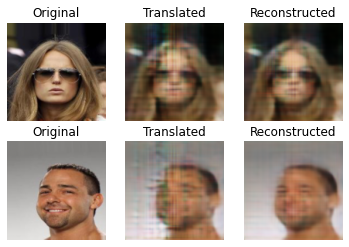

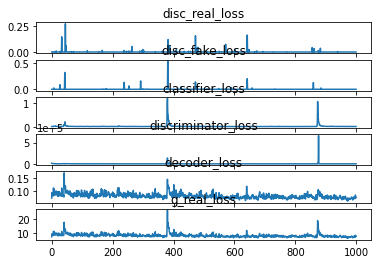

Train 0 / 100:  20%|█▉        | 1000/5086 [2:17:57<29:49:21, 26.28s/it]

Epoch 1/1
32/32 [==============================] - 0s 7ms/step - loss: 1.7854e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5287e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7020 - classifier_loss: 0.0065 - discriminator_loss: 5.5283e-11 - decoder_loss: 0.0764


Train 0 / 100:  20%|█▉        | 1001/5086 [2:18:06<23:43:50, 20.91s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2199e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1010e-05
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.2394 - classifier_loss: 0.0058 - discriminator_loss: 6.6786e-11 - decoder_loss: 0.0718


Train 0 / 100:  20%|█▉        | 1002/5086 [2:18:13<19:10:37, 16.90s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0888e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7098e-08
Epoch 1/1
32/32 [==============================] - 6s 178ms/step - loss: 7.6537 - classifier_loss: 0.0059 - discriminator_loss: 7.2298e-11 - decoder_loss: 0.0759


Train 0 / 100:  20%|█▉        | 1003/5086 [2:18:21<15:58:46, 14.09s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4458e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1052e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.7650 - classifier_loss: 0.0062 - discriminator_loss: 5.7138e-11 - decoder_loss: 0.0770


Train 0 / 100:  20%|█▉        | 1004/5086 [2:18:28<13:45:05, 12.13s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9975e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1503e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0089 - classifier_loss: 0.0077 - discriminator_loss: 6.7517e-11 - decoder_loss: 0.0793


Train 0 / 100:  20%|█▉        | 1005/5086 [2:18:36<12:11:51, 10.76s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7715e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1581e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1893 - classifier_loss: 0.0070 - discriminator_loss: 5.8481e-11 - decoder_loss: 0.0712


Train 0 / 100:  20%|█▉        | 1006/5086 [2:18:43<11:07:29,  9.82s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0296e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3417e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2100 - classifier_loss: 0.0070 - discriminator_loss: 6.1000e-11 - decoder_loss: 0.0714


Train 0 / 100:  20%|█▉        | 1007/5086 [2:18:51<10:22:19,  9.15s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7081e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0583e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.3868 - classifier_loss: 0.0068 - discriminator_loss: 5.7010e-11 - decoder_loss: 0.0732


Train 0 / 100:  20%|█▉        | 1008/5086 [2:18:59<9:52:23,  8.72s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1432e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4816e-04
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.2553 - classifier_loss: 0.0059 - discriminator_loss: 5.2544e-11 - decoder_loss: 0.0820


Train 0 / 100:  20%|█▉        | 1009/5086 [2:19:06<9:31:10,  8.41s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6560e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.1947e-05
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 7.1282 - classifier_loss: 0.0062 - discriminator_loss: 5.2302e-11 - decoder_loss: 0.0707


Train 0 / 100:  20%|█▉        | 1010/5086 [2:19:14<9:17:24,  8.21s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2959e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3784e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1911 - classifier_loss: 0.0080 - discriminator_loss: 4.2813e-11 - decoder_loss: 0.0711


Train 0 / 100:  20%|█▉        | 1011/5086 [2:19:22<9:05:24,  8.03s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8327e-04
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.0258e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8991 - classifier_loss: 0.0051 - discriminator_loss: 5.3265e-11 - decoder_loss: 0.0785


Train 0 / 100:  20%|█▉        | 1012/5086 [2:19:29<8:56:59,  7.91s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7299e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3299e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5605 - classifier_loss: 0.0057 - discriminator_loss: 7.9808e-11 - decoder_loss: 0.0750


Train 0 / 100:  20%|█▉        | 1013/5086 [2:19:37<8:51:41,  7.83s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7124e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3184e-08
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.0699 - classifier_loss: 0.0065 - discriminator_loss: 5.8553e-11 - decoder_loss: 0.0801


Train 0 / 100:  20%|█▉        | 1014/5086 [2:19:45<8:49:48,  7.81s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2585e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1144e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.7514 - classifier_loss: 0.0061 - discriminator_loss: 4.9704e-11 - decoder_loss: 0.0669


Train 0 / 100:  20%|█▉        | 1015/5086 [2:19:52<8:46:16,  7.76s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2967e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2963e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.4796 - classifier_loss: 0.0065 - discriminator_loss: 4.0982e-11 - decoder_loss: 0.0741


Train 0 / 100:  20%|█▉        | 1016/5086 [2:20:00<8:43:27,  7.72s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4287e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5797e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7525 - classifier_loss: 0.0055 - discriminator_loss: 4.6733e-11 - decoder_loss: 0.0770


Train 0 / 100:  20%|█▉        | 1017/5086 [2:20:08<8:41:26,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8376e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3354e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.9419 - classifier_loss: 0.0066 - discriminator_loss: 4.5528e-11 - decoder_loss: 0.0688


Train 0 / 100:  20%|██        | 1018/5086 [2:20:15<8:40:01,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8478e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5379e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9068 - classifier_loss: 0.0058 - discriminator_loss: 5.5082e-11 - decoder_loss: 0.0685


Train 0 / 100:  20%|██        | 1019/5086 [2:20:23<8:38:26,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0993e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4206e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3056 - classifier_loss: 0.0071 - discriminator_loss: 5.5042e-11 - decoder_loss: 0.0723


Train 0 / 100:  20%|██        | 1020/5086 [2:20:30<8:37:27,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7912e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1369e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5379 - classifier_loss: 0.0052 - discriminator_loss: 6.4164e-11 - decoder_loss: 0.0749


Train 0 / 100:  20%|██        | 1021/5086 [2:20:38<8:36:38,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6411e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3903e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2512 - classifier_loss: 0.0071 - discriminator_loss: 5.8674e-11 - decoder_loss: 0.0718


Train 0 / 100:  20%|██        | 1022/5086 [2:20:46<8:36:43,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5528e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8086e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4773 - classifier_loss: 0.0145 - discriminator_loss: 9.2073e-11 - decoder_loss: 0.0733


Train 0 / 100:  20%|██        | 1023/5086 [2:20:53<8:36:11,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5724e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4625e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0101 - classifier_loss: 0.0077 - discriminator_loss: 7.0081e-11 - decoder_loss: 0.0793


Train 0 / 100:  20%|██        | 1024/5086 [2:21:01<8:35:12,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2460e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1371 - classifier_loss: 0.0073 - discriminator_loss: 2.7853e-11 - decoder_loss: 0.0806


Train 0 / 100:  20%|██        | 1025/5086 [2:21:08<8:35:14,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6699e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8173e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7519 - classifier_loss: 0.0078 - discriminator_loss: 2.1179e-11 - decoder_loss: 0.0767


Train 0 / 100:  20%|██        | 1026/5086 [2:21:16<8:35:37,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2775e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0217e-10
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 7.4896 - classifier_loss: 0.0076 - discriminator_loss: 1.7417e-11 - decoder_loss: 0.0741


Train 0 / 100:  20%|██        | 1027/5086 [2:21:24<8:37:23,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.8420e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.5071 - classifier_loss: 0.0082 - discriminator_loss: 2.1715e-11 - decoder_loss: 0.0842


Train 0 / 100:  20%|██        | 1028/5086 [2:21:31<8:36:05,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6410e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5095e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3748 - classifier_loss: 0.0064 - discriminator_loss: 2.3411e-11 - decoder_loss: 0.0731


Train 0 / 100:  20%|██        | 1029/5086 [2:21:39<8:35:33,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2510e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3448e-10
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1294 - classifier_loss: 0.0058 - discriminator_loss: 2.0861e-11 - decoder_loss: 0.0707


Train 0 / 100:  20%|██        | 1030/5086 [2:21:47<8:33:57,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1079e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3926e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2515 - classifier_loss: 0.0081 - discriminator_loss: 2.2953e-11 - decoder_loss: 0.0717


Train 0 / 100:  20%|██        | 1031/5086 [2:21:54<8:34:16,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8313e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2047e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3664 - classifier_loss: 0.0092 - discriminator_loss: 2.1256e-11 - decoder_loss: 0.0827


Train 0 / 100:  20%|██        | 1032/5086 [2:22:02<8:34:17,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7912e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6791e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.3293 - classifier_loss: 0.0065 - discriminator_loss: 2.4384e-11 - decoder_loss: 0.0926


Train 0 / 100:  20%|██        | 1033/5086 [2:22:09<8:34:11,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5004e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7665e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 10.0859 - classifier_loss: 0.0065 - discriminator_loss: 1.8554e-11 - decoder_loss: 0.1002


Train 0 / 100:  20%|██        | 1034/5086 [2:22:17<8:33:25,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0415
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4468 - classifier_loss: 0.0059 - discriminator_loss: 4.0700e-10 - decoder_loss: 0.0739


Train 0 / 100:  20%|██        | 1035/5086 [2:22:25<8:33:31,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7522e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.2849
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8778 - classifier_loss: 0.0067 - discriminator_loss: 2.0032e-11 - decoder_loss: 0.0781


Train 0 / 100:  20%|██        | 1036/5086 [2:22:32<8:33:19,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0778e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5992e-11
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9093 - classifier_loss: 0.0095 - discriminator_loss: 1.1322e-11 - decoder_loss: 0.0681


Train 0 / 100:  20%|██        | 1037/5086 [2:22:40<8:32:54,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4839e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9911e-11
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.6266 - classifier_loss: 0.0068 - discriminator_loss: 1.1852e-11 - decoder_loss: 0.0856


Train 0 / 100:  20%|██        | 1038/5086 [2:22:48<8:35:06,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0779
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1451e-11
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4249 - classifier_loss: 0.0064 - discriminator_loss: 1.5268e-11 - decoder_loss: 0.0736


Train 0 / 100:  20%|██        | 1039/5086 [2:22:55<8:34:40,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5061e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.1477 - classifier_loss: 0.0071 - discriminator_loss: 1.7797e-11 - decoder_loss: 0.0808


Train 0 / 100:  20%|██        | 1040/5086 [2:23:03<8:34:41,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0138
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 2.2284e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.7016 - classifier_loss: 0.0078 - discriminator_loss: 3.1247e-11 - decoder_loss: 0.0962


Train 0 / 100:  20%|██        | 1041/5086 [2:23:10<8:34:20,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6871e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1174e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6073 - classifier_loss: 0.0073 - discriminator_loss: 2.6814e-11 - decoder_loss: 0.0753


Train 0 / 100:  20%|██        | 1042/5086 [2:23:18<8:33:29,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1906e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.1445
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.6479 - classifier_loss: 0.0068 - discriminator_loss: 2.0919e-11 - decoder_loss: 0.0758


Train 0 / 100:  21%|██        | 1043/5086 [2:23:26<8:34:24,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8322e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4283e-11
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4456 - classifier_loss: 0.0080 - discriminator_loss: 2.6215e-11 - decoder_loss: 0.0737


Train 0 / 100:  21%|██        | 1044/5086 [2:23:33<8:34:13,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2897e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8023 - classifier_loss: 0.0063 - discriminator_loss: 2.4712e-11 - decoder_loss: 0.0774


Train 0 / 100:  21%|██        | 1045/5086 [2:23:41<8:33:55,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6012e-10
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.3150 - classifier_loss: 0.0056 - discriminator_loss: 2.5053e-11 - decoder_loss: 0.0826


Train 0 / 100:  21%|██        | 1046/5086 [2:23:48<8:32:19,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6084e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4152e-10
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0760 - classifier_loss: 0.0082 - discriminator_loss: 2.5533e-11 - decoder_loss: 0.0699


Train 0 / 100:  21%|██        | 1047/5086 [2:23:56<8:31:50,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 7.3759e-11
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4319 - classifier_loss: 0.0057 - discriminator_loss: 2.4941e-11 - decoder_loss: 0.0738


Train 0 / 100:  21%|██        | 1048/5086 [2:24:04<8:30:50,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7457e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5038e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4340 - classifier_loss: 0.0068 - discriminator_loss: 2.3453e-11 - decoder_loss: 0.0737


Train 0 / 100:  21%|██        | 1049/5086 [2:24:11<8:31:06,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7676e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.4926e-11
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.3724 - classifier_loss: 0.0067 - discriminator_loss: 2.1600e-11 - decoder_loss: 0.0731


Train 0 / 100:  21%|██        | 1050/5086 [2:24:19<8:32:37,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7415e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2805e-11
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0486 - classifier_loss: 0.0068 - discriminator_loss: 2.4168e-11 - decoder_loss: 0.0798


Train 0 / 100:  21%|██        | 1051/5086 [2:24:27<8:32:40,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1578e-11
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.5677 - classifier_loss: 0.0056 - discriminator_loss: 2.2162e-11 - decoder_loss: 0.0851


Train 0 / 100:  21%|██        | 1052/5086 [2:24:34<8:32:16,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9946e-11
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3723 - classifier_loss: 0.0053 - discriminator_loss: 2.1139e-11 - decoder_loss: 0.0732


Train 0 / 100:  21%|██        | 1053/5086 [2:24:42<8:32:40,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1952e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4795e-11
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.8606 - classifier_loss: 0.0062 - discriminator_loss: 2.2243e-11 - decoder_loss: 0.0680


Train 0 / 100:  21%|██        | 1054/5086 [2:24:49<8:32:47,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3725e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.2149e-11
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 6.7331 - classifier_loss: 0.0055 - discriminator_loss: 2.4286e-11 - decoder_loss: 0.0668


Train 0 / 100:  21%|██        | 1055/5086 [2:24:57<8:34:03,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5485e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5795e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9680 - classifier_loss: 0.0059 - discriminator_loss: 2.6437e-11 - decoder_loss: 0.0791


Train 0 / 100:  21%|██        | 1056/5086 [2:25:05<8:33:23,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3055e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7220e-11
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.7172 - classifier_loss: 0.0062 - discriminator_loss: 2.4217e-11 - decoder_loss: 0.0665


Train 0 / 100:  21%|██        | 1057/5086 [2:25:12<8:31:46,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6405e-11
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.6307 - classifier_loss: 0.0061 - discriminator_loss: 2.8960e-11 - decoder_loss: 0.0657


Train 0 / 100:  21%|██        | 1058/5086 [2:25:20<8:32:11,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.1054
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0472e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.9104 - classifier_loss: 0.0063 - discriminator_loss: 9.2695e-11 - decoder_loss: 0.0785


Train 0 / 100:  21%|██        | 1059/5086 [2:25:28<8:33:02,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4610e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4152e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2074 - classifier_loss: 0.0076 - discriminator_loss: 1.1799e-10 - decoder_loss: 0.0813


Train 0 / 100:  21%|██        | 1060/5086 [2:25:35<8:32:26,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1768e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0913e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0029 - classifier_loss: 0.0061 - discriminator_loss: 1.6468e-10 - decoder_loss: 0.0794


Train 0 / 100:  21%|██        | 1061/5086 [2:25:43<8:31:37,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4323e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5389e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4892 - classifier_loss: 0.0050 - discriminator_loss: 3.0021e-10 - decoder_loss: 0.0744


Train 0 / 100:  21%|██        | 1062/5086 [2:25:50<8:31:02,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7639e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3801 - classifier_loss: 0.0059 - discriminator_loss: 9.6210e-11 - decoder_loss: 0.0732


Train 0 / 100:  21%|██        | 1063/5086 [2:25:58<8:30:57,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2549e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2702e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 9.4516 - classifier_loss: 0.0066 - discriminator_loss: 5.7565e-11 - decoder_loss: 0.0939


Train 0 / 100:  21%|██        | 1064/5086 [2:26:06<8:31:36,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3331e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9914e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.1288 - classifier_loss: 0.0059 - discriminator_loss: 5.6828e-11 - decoder_loss: 0.0707


Train 0 / 100:  21%|██        | 1065/5086 [2:26:13<8:33:00,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5791e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 2.7904e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1356 - classifier_loss: 0.0057 - discriminator_loss: 9.8701e-11 - decoder_loss: 0.0708


Train 0 / 100:  21%|██        | 1066/5086 [2:26:21<8:31:08,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1797e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3938e-05
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.6785 - classifier_loss: 0.0064 - discriminator_loss: 6.7601e-11 - decoder_loss: 0.0761


Train 0 / 100:  21%|██        | 1067/5086 [2:26:29<8:32:36,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9539e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3391e-05
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.0039 - classifier_loss: 0.0065 - discriminator_loss: 7.5331e-11 - decoder_loss: 0.0694


Train 0 / 100:  21%|██        | 1068/5086 [2:26:36<8:33:37,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6754e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4419e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1949 - classifier_loss: 0.0060 - discriminator_loss: 8.2552e-11 - decoder_loss: 0.0713


Train 0 / 100:  21%|██        | 1069/5086 [2:26:44<8:31:24,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9373e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2061e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1326 - classifier_loss: 0.0058 - discriminator_loss: 7.3141e-11 - decoder_loss: 0.0707


Train 0 / 100:  21%|██        | 1070/5086 [2:26:52<8:30:11,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7492e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.6872 - classifier_loss: 0.0062 - discriminator_loss: 5.5593e-11 - decoder_loss: 0.0863


Train 0 / 100:  21%|██        | 1071/5086 [2:26:59<8:31:19,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9769e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3547e-10
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7380 - classifier_loss: 0.0055 - discriminator_loss: 3.6909e-11 - decoder_loss: 0.0768


Train 0 / 100:  21%|██        | 1072/5086 [2:27:07<8:30:31,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7167e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6950e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9820 - classifier_loss: 0.0075 - discriminator_loss: 3.4115e-11 - decoder_loss: 0.0691


Train 0 / 100:  21%|██        | 1073/5086 [2:27:14<8:29:27,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7162e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6518e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.8948 - classifier_loss: 0.0336 - discriminator_loss: 4.2955e-11 - decoder_loss: 0.0656


Train 0 / 100:  21%|██        | 1074/5086 [2:27:22<8:29:46,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8977e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0784e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5932 - classifier_loss: 0.0180 - discriminator_loss: 4.0694e-11 - decoder_loss: 0.0741


Train 0 / 100:  21%|██        | 1075/5086 [2:27:30<8:29:17,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5015e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3858e-11
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3440 - classifier_loss: 0.0127 - discriminator_loss: 3.5763e-11 - decoder_loss: 0.0722


Train 0 / 100:  21%|██        | 1076/5086 [2:27:37<8:29:14,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2314e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2993e-10
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.3259 - classifier_loss: 0.0095 - discriminator_loss: 3.7143e-11 - decoder_loss: 0.0723


Train 0 / 100:  21%|██        | 1077/5086 [2:27:45<8:27:22,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0207e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3610e-10
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5604 - classifier_loss: 0.0074 - discriminator_loss: 3.3508e-11 - decoder_loss: 0.0749


Train 0 / 100:  21%|██        | 1078/5086 [2:27:53<8:27:48,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2304e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.9485e-10
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 6.8338 - classifier_loss: 0.0090 - discriminator_loss: 4.3195e-11 - decoder_loss: 0.0674


Train 0 / 100:  21%|██        | 1079/5086 [2:28:00<8:26:39,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6112e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2601 - classifier_loss: 0.0081 - discriminator_loss: 3.3081e-11 - decoder_loss: 0.0818


Train 0 / 100:  21%|██        | 1080/5086 [2:28:08<8:27:21,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2622e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7551e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6497 - classifier_loss: 0.0063 - discriminator_loss: 3.9251e-11 - decoder_loss: 0.0759


Train 0 / 100:  21%|██▏       | 1081/5086 [2:28:15<8:28:03,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7905e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0737e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5785 - classifier_loss: 0.0075 - discriminator_loss: 3.7432e-11 - decoder_loss: 0.0750


Train 0 / 100:  21%|██▏       | 1082/5086 [2:28:23<8:28:02,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0826
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1800e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.0017 - classifier_loss: 0.0075 - discriminator_loss: 1.6085e-10 - decoder_loss: 0.0693


Train 0 / 100:  21%|██▏       | 1083/5086 [2:28:31<8:30:19,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5232e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.3518e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5391 - classifier_loss: 0.0066 - discriminator_loss: 1.6481e-10 - decoder_loss: 0.0747


Train 0 / 100:  21%|██▏       | 1084/5086 [2:28:38<8:29:58,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5344e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6843e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4695 - classifier_loss: 0.0082 - discriminator_loss: 1.4122e-10 - decoder_loss: 0.0739


Train 0 / 100:  21%|██▏       | 1085/5086 [2:28:46<8:29:45,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8159e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0060e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2255 - classifier_loss: 0.0064 - discriminator_loss: 1.3715e-10 - decoder_loss: 0.0716


Train 0 / 100:  21%|██▏       | 1086/5086 [2:28:54<8:29:33,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5257e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5362e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.2632 - classifier_loss: 0.0063 - discriminator_loss: 1.6908e-10 - decoder_loss: 0.0720


Train 0 / 100:  21%|██▏       | 1087/5086 [2:29:01<8:30:44,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1689e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.8582e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.7441 - classifier_loss: 0.0056 - discriminator_loss: 2.1850e-10 - decoder_loss: 0.0769


Train 0 / 100:  21%|██▏       | 1088/5086 [2:29:09<8:30:37,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5251e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2025e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.4765 - classifier_loss: 0.0078 - discriminator_loss: 2.1809e-10 - decoder_loss: 0.0840


Train 0 / 100:  21%|██▏       | 1089/5086 [2:29:17<8:29:44,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9056e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2883e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.0997 - classifier_loss: 0.0053 - discriminator_loss: 1.8334e-10 - decoder_loss: 0.0905


Train 0 / 100:  21%|██▏       | 1090/5086 [2:29:24<8:28:46,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8668e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3163e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.8791 - classifier_loss: 0.0059 - discriminator_loss: 1.8566e-10 - decoder_loss: 0.0782


Train 0 / 100:  21%|██▏       | 1091/5086 [2:29:32<8:30:13,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2720e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9837e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7343 - classifier_loss: 0.0072 - discriminator_loss: 2.1815e-10 - decoder_loss: 0.0766


Train 0 / 100:  21%|██▏       | 1092/5086 [2:29:39<8:28:10,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.3461e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.1976e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 9.0101 - classifier_loss: 0.0066 - discriminator_loss: 2.1949e-10 - decoder_loss: 0.0894


Train 0 / 100:  21%|██▏       | 1093/5086 [2:29:47<8:29:47,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3635e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4114e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.5665 - classifier_loss: 0.0067 - discriminator_loss: 1.6301e-10 - decoder_loss: 0.0850


Train 0 / 100:  22%|██▏       | 1094/5086 [2:29:55<8:28:09,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.1816e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0723e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8021 - classifier_loss: 0.0070 - discriminator_loss: 1.7219e-10 - decoder_loss: 0.0773


Train 0 / 100:  22%|██▏       | 1095/5086 [2:30:02<8:26:46,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5679e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8318e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9042 - classifier_loss: 0.0064 - discriminator_loss: 1.1436e-10 - decoder_loss: 0.0784


Train 0 / 100:  22%|██▏       | 1096/5086 [2:30:10<8:26:38,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2219e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4399e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.1819 - classifier_loss: 0.0061 - discriminator_loss: 1.3490e-10 - decoder_loss: 0.0712


Train 0 / 100:  22%|██▏       | 1097/5086 [2:30:18<8:27:59,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6165e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0610e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6627 - classifier_loss: 0.0065 - discriminator_loss: 1.0791e-10 - decoder_loss: 0.0760


Train 0 / 100:  22%|██▏       | 1098/5086 [2:30:25<8:27:26,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2400e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6999e-04
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.5504 - classifier_loss: 0.0058 - discriminator_loss: 1.5381e-10 - decoder_loss: 0.0749


Train 0 / 100:  22%|██▏       | 1099/5086 [2:30:33<8:27:47,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0182e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9801e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6788 - classifier_loss: 0.0046 - discriminator_loss: 1.9007e-10 - decoder_loss: 0.0763
Epoch: 0 with batch: 1099


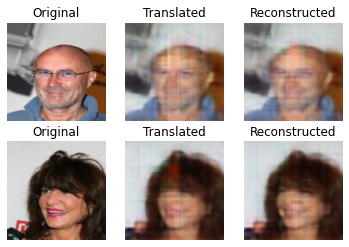

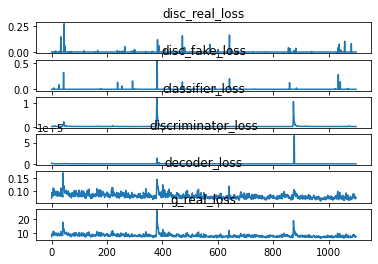

Train 0 / 100:  22%|██▏       | 1100/5086 [2:31:39<27:55:33, 25.22s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2997e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0183e-05
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.0533 - classifier_loss: 0.0067 - discriminator_loss: 1.2847e-10 - decoder_loss: 0.0699


Train 0 / 100:  22%|██▏       | 1101/5086 [2:31:49<22:53:53, 20.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1620e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1333e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 6.7153 - classifier_loss: 0.0067 - discriminator_loss: 1.4705e-10 - decoder_loss: 0.0665


Train 0 / 100:  22%|██▏       | 1102/5086 [2:31:57<18:34:38, 16.79s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7990e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6829e-09
Epoch 1/1
32/32 [==============================] - 6s 178ms/step - loss: 7.5153 - classifier_loss: 0.0055 - discriminator_loss: 1.5247e-10 - decoder_loss: 0.0746


Train 0 / 100:  22%|██▏       | 1103/5086 [2:32:04<15:29:12, 14.00s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9090e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0113e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.0095 - classifier_loss: 0.0080 - discriminator_loss: 1.4325e-10 - decoder_loss: 0.0793


Train 0 / 100:  22%|██▏       | 1104/5086 [2:32:12<13:20:11, 12.06s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9612e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6501e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2368 - classifier_loss: 0.0060 - discriminator_loss: 1.9598e-10 - decoder_loss: 0.0718


Train 0 / 100:  22%|██▏       | 1105/5086 [2:32:20<11:50:26, 10.71s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6332e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0465e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0599 - classifier_loss: 0.0064 - discriminator_loss: 1.9909e-10 - decoder_loss: 0.0700


Train 0 / 100:  22%|██▏       | 1106/5086 [2:32:27<10:48:46,  9.78s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1950e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1829e-05
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 6.7869 - classifier_loss: 0.0046 - discriminator_loss: 1.5498e-10 - decoder_loss: 0.0674


Train 0 / 100:  22%|██▏       | 1107/5086 [2:32:35<10:03:45,  9.10s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7560e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8027e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.4425 - classifier_loss: 0.0065 - discriminator_loss: 1.2149e-10 - decoder_loss: 0.0738


Train 0 / 100:  22%|██▏       | 1108/5086 [2:32:42<9:34:39,  8.67s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2939e-05
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 4.2637e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3788 - classifier_loss: 0.0054 - discriminator_loss: 1.2355e-10 - decoder_loss: 0.0732


Train 0 / 100:  22%|██▏       | 1109/5086 [2:32:50<9:12:53,  8.34s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3204e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2277e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1279 - classifier_loss: 0.0061 - discriminator_loss: 1.8381e-10 - decoder_loss: 0.0707


Train 0 / 100:  22%|██▏       | 1110/5086 [2:32:58<8:57:40,  8.11s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3379e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6965e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8768 - classifier_loss: 0.0063 - discriminator_loss: 1.3989e-10 - decoder_loss: 0.0781


Train 0 / 100:  22%|██▏       | 1111/5086 [2:33:05<8:48:12,  7.97s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1562e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2924e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.7003 - classifier_loss: 0.0065 - discriminator_loss: 1.0503e-10 - decoder_loss: 0.0664


Train 0 / 100:  22%|██▏       | 1112/5086 [2:33:13<8:41:15,  7.87s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9405e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8894e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.4969 - classifier_loss: 0.0055 - discriminator_loss: 2.5078e-10 - decoder_loss: 0.0644


Train 0 / 100:  22%|██▏       | 1113/5086 [2:33:20<8:36:07,  7.79s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5016e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5572e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9389 - classifier_loss: 0.0060 - discriminator_loss: 1.3205e-10 - decoder_loss: 0.0688


Train 0 / 100:  22%|██▏       | 1114/5086 [2:33:28<8:31:50,  7.73s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3451e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5547e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5363 - classifier_loss: 0.0064 - discriminator_loss: 2.1298e-10 - decoder_loss: 0.0747


Train 0 / 100:  22%|██▏       | 1115/5086 [2:33:36<8:28:54,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4886e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6641e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7841 - classifier_loss: 0.0052 - discriminator_loss: 2.4761e-10 - decoder_loss: 0.0773


Train 0 / 100:  22%|██▏       | 1116/5086 [2:33:43<8:26:27,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4229e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9962e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5975 - classifier_loss: 0.0062 - discriminator_loss: 1.3297e-10 - decoder_loss: 0.0754


Train 0 / 100:  22%|██▏       | 1117/5086 [2:33:51<8:25:37,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0067e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0437e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8484 - classifier_loss: 0.0065 - discriminator_loss: 1.5131e-10 - decoder_loss: 0.0678


Train 0 / 100:  22%|██▏       | 1118/5086 [2:33:58<8:25:42,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0894e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9790e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1522 - classifier_loss: 0.0058 - discriminator_loss: 1.7985e-10 - decoder_loss: 0.0709


Train 0 / 100:  22%|██▏       | 1119/5086 [2:34:06<8:24:36,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1827e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1570e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8652 - classifier_loss: 0.0060 - discriminator_loss: 1.0314e-10 - decoder_loss: 0.0781


Train 0 / 100:  22%|██▏       | 1120/5086 [2:34:14<8:24:35,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6066e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.6653e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2879 - classifier_loss: 0.0051 - discriminator_loss: 1.1463e-10 - decoder_loss: 0.0724


Train 0 / 100:  22%|██▏       | 1121/5086 [2:34:21<8:23:41,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0600e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8601e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.0992 - classifier_loss: 0.0049 - discriminator_loss: 1.7369e-10 - decoder_loss: 0.0805


Train 0 / 100:  22%|██▏       | 1122/5086 [2:34:29<8:25:00,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4006e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9137e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.5574 - classifier_loss: 0.0064 - discriminator_loss: 1.3517e-10 - decoder_loss: 0.0649


Train 0 / 100:  22%|██▏       | 1123/5086 [2:34:37<8:24:16,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9023e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8404e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.4468 - classifier_loss: 0.0064 - discriminator_loss: 2.0364e-10 - decoder_loss: 0.0738


Train 0 / 100:  22%|██▏       | 1124/5086 [2:34:44<8:25:14,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7450e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1221e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6022 - classifier_loss: 0.0052 - discriminator_loss: 1.2849e-10 - decoder_loss: 0.0755


Train 0 / 100:  22%|██▏       | 1125/5086 [2:34:52<8:23:12,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0894e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7561e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5307 - classifier_loss: 0.0054 - discriminator_loss: 2.6653e-10 - decoder_loss: 0.0748


Train 0 / 100:  22%|██▏       | 1126/5086 [2:34:59<8:23:34,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1349e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2100e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6829 - classifier_loss: 0.0053 - discriminator_loss: 1.8704e-10 - decoder_loss: 0.0763


Train 0 / 100:  22%|██▏       | 1127/5086 [2:35:07<8:23:41,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4913e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6779e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0084 - classifier_loss: 0.0054 - discriminator_loss: 1.5783e-10 - decoder_loss: 0.0795


Train 0 / 100:  22%|██▏       | 1128/5086 [2:35:15<8:23:15,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.1281e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2011e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6977 - classifier_loss: 0.0053 - discriminator_loss: 1.4449e-10 - decoder_loss: 0.0764


Train 0 / 100:  22%|██▏       | 1129/5086 [2:35:22<8:22:15,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8944e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9535e-05
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.2657 - classifier_loss: 0.0060 - discriminator_loss: 1.5270e-10 - decoder_loss: 0.0721


Train 0 / 100:  22%|██▏       | 1130/5086 [2:35:30<8:23:55,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8108e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9328e-04
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.6175 - classifier_loss: 0.0055 - discriminator_loss: 1.5382e-10 - decoder_loss: 0.0756


Train 0 / 100:  22%|██▏       | 1131/5086 [2:35:38<8:24:33,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1987e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8167e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.1779 - classifier_loss: 0.0052 - discriminator_loss: 1.7821e-10 - decoder_loss: 0.0713


Train 0 / 100:  22%|██▏       | 1132/5086 [2:35:45<8:22:24,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5421e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3628e-09
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.5175 - classifier_loss: 0.0066 - discriminator_loss: 1.1666e-10 - decoder_loss: 0.0745


Train 0 / 100:  22%|██▏       | 1133/5086 [2:35:53<8:24:07,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4193e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4099e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0398 - classifier_loss: 0.0049 - discriminator_loss: 1.5730e-10 - decoder_loss: 0.0799


Train 0 / 100:  22%|██▏       | 1134/5086 [2:36:01<8:22:25,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0373e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6863e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.1341 - classifier_loss: 0.0066 - discriminator_loss: 1.2121e-10 - decoder_loss: 0.0707


Train 0 / 100:  22%|██▏       | 1135/5086 [2:36:08<8:23:11,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3788e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5123e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.8045 - classifier_loss: 0.0053 - discriminator_loss: 1.1923e-10 - decoder_loss: 0.0775


Train 0 / 100:  22%|██▏       | 1136/5086 [2:36:16<8:23:43,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.2653e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0313
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.3426 - classifier_loss: 0.0066 - discriminator_loss: 8.0194e-11 - decoder_loss: 0.0728


Train 0 / 100:  22%|██▏       | 1137/5086 [2:36:24<8:23:40,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7667e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2887e-10
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5674 - classifier_loss: 0.0048 - discriminator_loss: 5.5926e-11 - decoder_loss: 0.0752


Train 0 / 100:  22%|██▏       | 1138/5086 [2:36:31<8:22:24,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6461e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.3340e-10
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9847 - classifier_loss: 0.0051 - discriminator_loss: 5.9761e-11 - decoder_loss: 0.0693


Train 0 / 100:  22%|██▏       | 1139/5086 [2:36:39<8:21:23,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8013e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3206e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.7431 - classifier_loss: 0.0052 - discriminator_loss: 4.8740e-11 - decoder_loss: 0.0669


Train 0 / 100:  22%|██▏       | 1140/5086 [2:36:46<8:21:18,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1632e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3458e-10
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1351 - classifier_loss: 0.0073 - discriminator_loss: 5.2442e-11 - decoder_loss: 0.0806


Train 0 / 100:  22%|██▏       | 1141/5086 [2:36:54<8:20:21,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3711e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3865e-11
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9388 - classifier_loss: 0.0059 - discriminator_loss: 4.6770e-11 - decoder_loss: 0.0788


Train 0 / 100:  22%|██▏       | 1142/5086 [2:37:02<8:20:29,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.3127
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8835e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8360 - classifier_loss: 0.0068 - discriminator_loss: 6.2159e-08 - decoder_loss: 0.0777


Train 0 / 100:  22%|██▏       | 1143/5086 [2:37:09<8:20:27,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6887e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0254
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.5504 - classifier_loss: 0.0051 - discriminator_loss: 5.0772e-08 - decoder_loss: 0.0750


Train 0 / 100:  22%|██▏       | 1144/5086 [2:37:17<8:21:39,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2855e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4733e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8908 - classifier_loss: 0.0049 - discriminator_loss: 1.5917e-08 - decoder_loss: 0.0684


Train 0 / 100:  23%|██▎       | 1145/5086 [2:37:24<8:21:16,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0354e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 6.6364 - classifier_loss: 0.0057 - discriminator_loss: 1.2271e-08 - decoder_loss: 0.0658


Train 0 / 100:  23%|██▎       | 1146/5086 [2:37:32<8:22:19,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9133e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2526e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6577 - classifier_loss: 0.0053 - discriminator_loss: 1.1560e-08 - decoder_loss: 0.0760


Train 0 / 100:  23%|██▎       | 1147/5086 [2:37:40<8:21:24,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1794e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7303e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 6.9785 - classifier_loss: 0.0047 - discriminator_loss: 8.6924e-09 - decoder_loss: 0.0693


Train 0 / 100:  23%|██▎       | 1148/5086 [2:37:47<8:22:38,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6445e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3204e-05
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 6.8816 - classifier_loss: 0.0065 - discriminator_loss: 8.2976e-09 - decoder_loss: 0.0682


Train 0 / 100:  23%|██▎       | 1149/5086 [2:37:55<8:24:21,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2821e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0175
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2202 - classifier_loss: 0.0056 - discriminator_loss: 2.9472e-09 - decoder_loss: 0.0716


Train 0 / 100:  23%|██▎       | 1150/5086 [2:38:03<8:23:21,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9421e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1139e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7915 - classifier_loss: 0.0063 - discriminator_loss: 2.1048e-09 - decoder_loss: 0.0773


Train 0 / 100:  23%|██▎       | 1151/5086 [2:38:10<8:21:02,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7081e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5606e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1353 - classifier_loss: 0.0049 - discriminator_loss: 1.6031e-09 - decoder_loss: 0.0709


Train 0 / 100:  23%|██▎       | 1152/5086 [2:38:18<8:20:19,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6252e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5299e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8396 - classifier_loss: 0.0056 - discriminator_loss: 1.5022e-09 - decoder_loss: 0.0678


Train 0 / 100:  23%|██▎       | 1153/5086 [2:38:26<8:19:54,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4214e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7529e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.5835 - classifier_loss: 0.0050 - discriminator_loss: 1.5634e-09 - decoder_loss: 0.0653


Train 0 / 100:  23%|██▎       | 1154/5086 [2:38:33<8:18:39,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2456e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4821 - classifier_loss: 0.0055 - discriminator_loss: 1.6240e-09 - decoder_loss: 0.0743


Train 0 / 100:  23%|██▎       | 1155/5086 [2:38:41<8:18:22,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9035e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6475e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1030 - classifier_loss: 0.0059 - discriminator_loss: 8.8492e-10 - decoder_loss: 0.0704


Train 0 / 100:  23%|██▎       | 1156/5086 [2:38:48<8:18:28,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6134e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2375e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5863 - classifier_loss: 0.0050 - discriminator_loss: 9.0273e-10 - decoder_loss: 0.0754


Train 0 / 100:  23%|██▎       | 1157/5086 [2:38:56<8:18:08,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4149e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9460e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.0409 - classifier_loss: 0.0056 - discriminator_loss: 6.5744e-10 - decoder_loss: 0.0698


Train 0 / 100:  23%|██▎       | 1158/5086 [2:39:04<8:18:00,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1319e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5654e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.7615 - classifier_loss: 0.0052 - discriminator_loss: 8.0480e-10 - decoder_loss: 0.0671


Train 0 / 100:  23%|██▎       | 1159/5086 [2:39:11<8:17:48,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2356e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7629e-06
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.3356 - classifier_loss: 0.0058 - discriminator_loss: 1.0868e-09 - decoder_loss: 0.0728


Train 0 / 100:  23%|██▎       | 1160/5086 [2:39:19<8:16:34,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6306e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4021e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2739 - classifier_loss: 0.0052 - discriminator_loss: 1.1999e-09 - decoder_loss: 0.0722


Train 0 / 100:  23%|██▎       | 1161/5086 [2:39:26<8:16:17,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9482e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4785e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.6687 - classifier_loss: 0.0055 - discriminator_loss: 7.0563e-10 - decoder_loss: 0.0761


Train 0 / 100:  23%|██▎       | 1162/5086 [2:39:34<8:18:10,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8579e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4033e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9875 - classifier_loss: 0.0059 - discriminator_loss: 1.0845e-09 - decoder_loss: 0.0693


Train 0 / 100:  23%|██▎       | 1163/5086 [2:39:42<8:17:41,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9893e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3722e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 6.9745 - classifier_loss: 0.0067 - discriminator_loss: 5.2674e-10 - decoder_loss: 0.0691


Train 0 / 100:  23%|██▎       | 1164/5086 [2:39:49<8:18:39,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5512e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4029e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0230 - classifier_loss: 0.0048 - discriminator_loss: 1.2932e-09 - decoder_loss: 0.0698


Train 0 / 100:  23%|██▎       | 1165/5086 [2:39:57<8:17:39,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0959e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8590e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.8636 - classifier_loss: 0.0056 - discriminator_loss: 6.7935e-10 - decoder_loss: 0.0681


Train 0 / 100:  23%|██▎       | 1166/5086 [2:40:05<8:16:30,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1655e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6426e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4350 - classifier_loss: 0.0052 - discriminator_loss: 8.1217e-10 - decoder_loss: 0.0738


Train 0 / 100:  23%|██▎       | 1167/5086 [2:40:12<8:16:27,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.3743e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8590 - classifier_loss: 0.0060 - discriminator_loss: 6.2822e-10 - decoder_loss: 0.0780


Train 0 / 100:  23%|██▎       | 1168/5086 [2:40:20<8:15:54,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6608e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8950e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.1029 - classifier_loss: 0.0054 - discriminator_loss: 7.1010e-10 - decoder_loss: 0.0705


Train 0 / 100:  23%|██▎       | 1169/5086 [2:40:27<8:17:53,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3779e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3954e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0328 - classifier_loss: 0.0047 - discriminator_loss: 7.1875e-10 - decoder_loss: 0.0699


Train 0 / 100:  23%|██▎       | 1170/5086 [2:40:35<8:16:53,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9579e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4410e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5252 - classifier_loss: 0.0049 - discriminator_loss: 9.2835e-10 - decoder_loss: 0.0748


Train 0 / 100:  23%|██▎       | 1171/5086 [2:40:43<8:16:26,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7938e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7223e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 6.6738 - classifier_loss: 0.0049 - discriminator_loss: 8.7770e-10 - decoder_loss: 0.0663


Train 0 / 100:  23%|██▎       | 1172/5086 [2:40:50<8:17:44,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8008e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2887e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0957 - classifier_loss: 0.0061 - discriminator_loss: 7.7576e-10 - decoder_loss: 0.0703


Train 0 / 100:  23%|██▎       | 1173/5086 [2:40:58<8:16:30,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9182e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9327e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4157 - classifier_loss: 0.0055 - discriminator_loss: 7.7993e-10 - decoder_loss: 0.0736


Train 0 / 100:  23%|██▎       | 1174/5086 [2:41:05<8:16:03,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0946e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7773e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2542 - classifier_loss: 0.0052 - discriminator_loss: 8.8481e-10 - decoder_loss: 0.0720


Train 0 / 100:  23%|██▎       | 1175/5086 [2:41:13<8:15:33,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5760e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2287e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8876 - classifier_loss: 0.0062 - discriminator_loss: 9.8789e-10 - decoder_loss: 0.0783


Train 0 / 100:  23%|██▎       | 1176/5086 [2:41:21<8:16:06,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3366e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4884e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4553 - classifier_loss: 0.0046 - discriminator_loss: 1.4222e-09 - decoder_loss: 0.0741


Train 0 / 100:  23%|██▎       | 1177/5086 [2:41:28<8:15:53,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1237e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5667e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6908 - classifier_loss: 0.0059 - discriminator_loss: 1.0870e-09 - decoder_loss: 0.0763


Train 0 / 100:  23%|██▎       | 1178/5086 [2:41:36<8:15:08,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1327e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1711 - classifier_loss: 0.0057 - discriminator_loss: 1.0179e-09 - decoder_loss: 0.0711


Train 0 / 100:  23%|██▎       | 1179/5086 [2:41:43<8:14:48,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0905e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.3240e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.9849 - classifier_loss: 0.0059 - discriminator_loss: 8.4484e-10 - decoder_loss: 0.0693


Train 0 / 100:  23%|██▎       | 1180/5086 [2:41:51<8:15:44,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5405e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8760e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.3234 - classifier_loss: 0.0051 - discriminator_loss: 7.8930e-10 - decoder_loss: 0.0727


Train 0 / 100:  23%|██▎       | 1181/5086 [2:41:59<8:16:48,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9802e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5294e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.8381 - classifier_loss: 0.0053 - discriminator_loss: 7.8655e-10 - decoder_loss: 0.0778


Train 0 / 100:  23%|██▎       | 1182/5086 [2:42:06<8:17:30,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2641e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8089e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8789 - classifier_loss: 0.0059 - discriminator_loss: 1.9043e-09 - decoder_loss: 0.0682


Train 0 / 100:  23%|██▎       | 1183/5086 [2:42:14<8:16:16,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1474e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3278e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.6877 - classifier_loss: 0.0052 - discriminator_loss: 5.3637e-10 - decoder_loss: 0.0664


Train 0 / 100:  23%|██▎       | 1184/5086 [2:42:22<8:15:24,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2363e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2095e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.6452 - classifier_loss: 0.0056 - discriminator_loss: 5.9886e-10 - decoder_loss: 0.0659


Train 0 / 100:  23%|██▎       | 1185/5086 [2:42:29<8:15:35,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5567e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0598e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0596 - classifier_loss: 0.0060 - discriminator_loss: 7.0304e-10 - decoder_loss: 0.0700


Train 0 / 100:  23%|██▎       | 1186/5086 [2:42:37<8:14:39,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6814e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3528e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 6.6293 - classifier_loss: 0.0048 - discriminator_loss: 6.7992e-10 - decoder_loss: 0.0658


Train 0 / 100:  23%|██▎       | 1187/5086 [2:42:45<8:16:00,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4200e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2352e-04
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.7461 - classifier_loss: 0.0056 - discriminator_loss: 5.5149e-10 - decoder_loss: 0.0769


Train 0 / 100:  23%|██▎       | 1188/5086 [2:42:52<8:13:46,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5946e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5734e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.7173 - classifier_loss: 0.0047 - discriminator_loss: 4.3473e-10 - decoder_loss: 0.0667


Train 0 / 100:  23%|██▎       | 1189/5086 [2:43:00<8:13:44,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2266e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4428e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0424 - classifier_loss: 0.0063 - discriminator_loss: 5.8890e-10 - decoder_loss: 0.0698


Train 0 / 100:  23%|██▎       | 1190/5086 [2:43:07<8:13:27,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9635e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8092e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.8730 - classifier_loss: 0.0054 - discriminator_loss: 5.0062e-10 - decoder_loss: 0.0682


Train 0 / 100:  23%|██▎       | 1191/5086 [2:43:15<8:14:03,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6745e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7273e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4487 - classifier_loss: 0.0059 - discriminator_loss: 6.1164e-10 - decoder_loss: 0.0739


Train 0 / 100:  23%|██▎       | 1192/5086 [2:43:22<8:14:00,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2264e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5535e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.8577 - classifier_loss: 0.0058 - discriminator_loss: 6.1581e-10 - decoder_loss: 0.0680


Train 0 / 100:  23%|██▎       | 1193/5086 [2:43:30<8:13:43,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3209e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3287e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8401 - classifier_loss: 0.0057 - discriminator_loss: 3.8783e-10 - decoder_loss: 0.0678


Train 0 / 100:  23%|██▎       | 1194/5086 [2:43:38<8:13:17,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0807e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0793e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0945 - classifier_loss: 0.0041 - discriminator_loss: 6.7998e-10 - decoder_loss: 0.0705


Train 0 / 100:  23%|██▎       | 1195/5086 [2:43:45<8:12:55,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2089e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4407e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2259 - classifier_loss: 0.0053 - discriminator_loss: 5.8110e-10 - decoder_loss: 0.0717


Train 0 / 100:  24%|██▎       | 1196/5086 [2:43:53<8:13:04,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5135e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8374e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6265 - classifier_loss: 0.0058 - discriminator_loss: 7.1920e-10 - decoder_loss: 0.0857


Train 0 / 100:  24%|██▎       | 1197/5086 [2:44:01<8:13:28,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6547e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1592e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3208 - classifier_loss: 0.0058 - discriminator_loss: 4.9305e-10 - decoder_loss: 0.0726


Train 0 / 100:  24%|██▎       | 1198/5086 [2:44:08<8:12:18,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1269e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7695e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.7742 - classifier_loss: 0.0063 - discriminator_loss: 5.6773e-10 - decoder_loss: 0.0671


Train 0 / 100:  24%|██▎       | 1199/5086 [2:44:16<8:12:37,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5923e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0735e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.3592 - classifier_loss: 0.0053 - discriminator_loss: 5.4202e-10 - decoder_loss: 0.0831
Epoch: 0 with batch: 1199


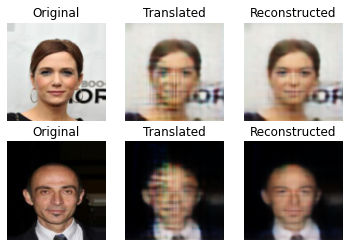

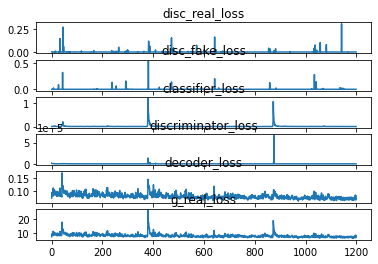

Train 0 / 100:  24%|██▎       | 1200/5086 [2:45:21<26:54:26, 24.93s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7078e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9037e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.2862 - classifier_loss: 0.0051 - discriminator_loss: 8.1014e-10 - decoder_loss: 0.0724


Train 0 / 100:  24%|██▎       | 1201/5086 [2:45:29<21:21:55, 19.80s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4909e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7066e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0180 - classifier_loss: 0.0061 - discriminator_loss: 5.3246e-10 - decoder_loss: 0.0696


Train 0 / 100:  24%|██▎       | 1202/5086 [2:45:37<17:28:24, 16.20s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0956e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3749e-06
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 6.5829 - classifier_loss: 0.0077 - discriminator_loss: 6.8155e-10 - decoder_loss: 0.0651


Train 0 / 100:  24%|██▎       | 1203/5086 [2:45:44<14:43:15, 13.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7464e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.2583e-04
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.4215 - classifier_loss: 0.0069 - discriminator_loss: 9.4983e-10 - decoder_loss: 0.0735


Train 0 / 100:  24%|██▎       | 1204/5086 [2:45:52<12:44:09, 11.81s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2670e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1704e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3184 - classifier_loss: 0.0053 - discriminator_loss: 4.0546e-10 - decoder_loss: 0.0727


Train 0 / 100:  24%|██▎       | 1205/5086 [2:46:00<11:22:19, 10.55s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4959e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.0008e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4196 - classifier_loss: 0.0062 - discriminator_loss: 1.2614e-09 - decoder_loss: 0.0736


Train 0 / 100:  24%|██▎       | 1206/5086 [2:46:07<10:24:36,  9.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9870e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2446e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0023 - classifier_loss: 0.0061 - discriminator_loss: 5.5442e-10 - decoder_loss: 0.0694


Train 0 / 100:  24%|██▎       | 1207/5086 [2:46:15<9:43:38,  9.03s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3082e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3380e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9434 - classifier_loss: 0.0069 - discriminator_loss: 4.2868e-10 - decoder_loss: 0.0787


Train 0 / 100:  24%|██▍       | 1208/5086 [2:46:22<9:15:42,  8.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2708e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7465e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4223 - classifier_loss: 0.0060 - discriminator_loss: 8.4026e-10 - decoder_loss: 0.0736


Train 0 / 100:  24%|██▍       | 1209/5086 [2:46:30<8:56:06,  8.30s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8581e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1178e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.5126 - classifier_loss: 0.0062 - discriminator_loss: 2.5661e-10 - decoder_loss: 0.0645


Train 0 / 100:  24%|██▍       | 1210/5086 [2:46:37<8:42:50,  8.09s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2158e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.8013e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.6857 - classifier_loss: 0.0059 - discriminator_loss: 4.7797e-10 - decoder_loss: 0.0663


Train 0 / 100:  24%|██▍       | 1211/5086 [2:46:45<8:33:45,  7.95s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3431e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.9265e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.1559 - classifier_loss: 0.0057 - discriminator_loss: 4.5929e-10 - decoder_loss: 0.0710


Train 0 / 100:  24%|██▍       | 1212/5086 [2:46:53<8:28:50,  7.88s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9749e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.0631e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8232 - classifier_loss: 0.0057 - discriminator_loss: 4.7116e-10 - decoder_loss: 0.0777


Train 0 / 100:  24%|██▍       | 1213/5086 [2:47:00<8:22:59,  7.79s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2207e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.5672e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1525 - classifier_loss: 0.0061 - discriminator_loss: 4.0727e-10 - decoder_loss: 0.0809


Train 0 / 100:  24%|██▍       | 1214/5086 [2:47:08<8:18:38,  7.73s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8617e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.6984e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.5378 - classifier_loss: 0.0050 - discriminator_loss: 4.9422e-10 - decoder_loss: 0.0649


Train 0 / 100:  24%|██▍       | 1215/5086 [2:47:16<8:16:22,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8494e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3211e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.8682 - classifier_loss: 0.0064 - discriminator_loss: 3.7732e-10 - decoder_loss: 0.0680


Train 0 / 100:  24%|██▍       | 1216/5086 [2:47:23<8:14:21,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8840e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4093e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.4914 - classifier_loss: 0.0061 - discriminator_loss: 6.3677e-10 - decoder_loss: 0.0743


Train 0 / 100:  24%|██▍       | 1217/5086 [2:47:31<8:13:06,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8979e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9750e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3104 - classifier_loss: 0.0054 - discriminator_loss: 4.8059e-10 - decoder_loss: 0.0726


Train 0 / 100:  24%|██▍       | 1218/5086 [2:47:38<8:12:09,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5626e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9784e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.7600 - classifier_loss: 0.0058 - discriminator_loss: 4.2031e-10 - decoder_loss: 0.0670


Train 0 / 100:  24%|██▍       | 1219/5086 [2:47:46<8:11:31,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3471e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5138e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3875 - classifier_loss: 0.0060 - discriminator_loss: 4.1767e-10 - decoder_loss: 0.0733


Train 0 / 100:  24%|██▍       | 1220/5086 [2:47:54<8:10:30,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3040e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3552e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.4507 - classifier_loss: 0.0066 - discriminator_loss: 5.9827e-10 - decoder_loss: 0.0738


Train 0 / 100:  24%|██▍       | 1221/5086 [2:48:01<8:12:05,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6151e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4841e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.2886 - classifier_loss: 0.0062 - discriminator_loss: 3.4871e-10 - decoder_loss: 0.0723


Train 0 / 100:  24%|██▍       | 1222/5086 [2:48:09<8:12:36,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2891e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7172e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.8131 - classifier_loss: 0.0055 - discriminator_loss: 4.5343e-10 - decoder_loss: 0.0776


Train 0 / 100:  24%|██▍       | 1223/5086 [2:48:17<8:13:06,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6923e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.1515e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0194 - classifier_loss: 0.0073 - discriminator_loss: 4.9582e-10 - decoder_loss: 0.0795


Train 0 / 100:  24%|██▍       | 1224/5086 [2:48:24<8:11:16,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0703e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0617e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1714 - classifier_loss: 0.0065 - discriminator_loss: 4.1833e-10 - decoder_loss: 0.0811


Train 0 / 100:  24%|██▍       | 1225/5086 [2:48:32<8:11:25,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9390e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4219e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9831 - classifier_loss: 0.0068 - discriminator_loss: 4.8895e-10 - decoder_loss: 0.0792


Train 0 / 100:  24%|██▍       | 1226/5086 [2:48:39<8:11:16,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9497e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4669e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.2018 - classifier_loss: 0.0069 - discriminator_loss: 6.4845e-10 - decoder_loss: 0.0813


Train 0 / 100:  24%|██▍       | 1227/5086 [2:48:47<8:10:51,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9325e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3704e-08
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 6.7487 - classifier_loss: 0.0070 - discriminator_loss: 5.0752e-10 - decoder_loss: 0.0668


Train 0 / 100:  24%|██▍       | 1228/5086 [2:48:55<8:12:27,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9614e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6303e-09
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.4216 - classifier_loss: 0.0077 - discriminator_loss: 5.1551e-10 - decoder_loss: 0.0734


Train 0 / 100:  24%|██▍       | 1229/5086 [2:49:02<8:12:32,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9647e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1999e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9034 - classifier_loss: 0.0053 - discriminator_loss: 3.8125e-10 - decoder_loss: 0.0685


Train 0 / 100:  24%|██▍       | 1230/5086 [2:49:10<8:11:53,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6995e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.6352e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.4446 - classifier_loss: 0.0072 - discriminator_loss: 5.6677e-10 - decoder_loss: 0.0737


Train 0 / 100:  24%|██▍       | 1231/5086 [2:49:18<8:11:00,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0583e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.6765e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5762 - classifier_loss: 0.0065 - discriminator_loss: 6.4680e-10 - decoder_loss: 0.0751


Train 0 / 100:  24%|██▍       | 1232/5086 [2:49:25<8:10:18,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8927e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8851e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.7300 - classifier_loss: 0.0065 - discriminator_loss: 5.1123e-10 - decoder_loss: 0.0667


Train 0 / 100:  24%|██▍       | 1233/5086 [2:49:33<8:09:01,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7073e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.3358e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.9052 - classifier_loss: 0.0064 - discriminator_loss: 4.5918e-10 - decoder_loss: 0.0684


Train 0 / 100:  24%|██▍       | 1234/5086 [2:49:41<8:09:28,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0275e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0950e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.8892 - classifier_loss: 0.0060 - discriminator_loss: 6.7283e-10 - decoder_loss: 0.0683


Train 0 / 100:  24%|██▍       | 1235/5086 [2:49:48<8:09:16,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1430e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1194e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6482 - classifier_loss: 0.0052 - discriminator_loss: 5.7571e-10 - decoder_loss: 0.0760


Train 0 / 100:  24%|██▍       | 1236/5086 [2:49:56<8:08:24,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5590e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0872e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.3171 - classifier_loss: 0.0051 - discriminator_loss: 6.2225e-10 - decoder_loss: 0.0827


Train 0 / 100:  24%|██▍       | 1237/5086 [2:50:03<8:08:09,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6304e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7941e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9797 - classifier_loss: 0.0055 - discriminator_loss: 4.8575e-10 - decoder_loss: 0.0693


Train 0 / 100:  24%|██▍       | 1238/5086 [2:50:11<8:08:12,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0459e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9964e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9772 - classifier_loss: 0.0052 - discriminator_loss: 3.5624e-10 - decoder_loss: 0.0792


Train 0 / 100:  24%|██▍       | 1239/5086 [2:50:19<8:08:03,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7964e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 9.8401e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.2127 - classifier_loss: 0.0055 - discriminator_loss: 4.3218e-10 - decoder_loss: 0.0716


Train 0 / 100:  24%|██▍       | 1240/5086 [2:50:26<8:08:08,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3257e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2073e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.6177 - classifier_loss: 0.0054 - discriminator_loss: 4.0525e-10 - decoder_loss: 0.0656


Train 0 / 100:  24%|██▍       | 1241/5086 [2:50:34<8:07:37,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0042e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1873e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 6.7254 - classifier_loss: 0.0054 - discriminator_loss: 6.2404e-10 - decoder_loss: 0.0667


Train 0 / 100:  24%|██▍       | 1242/5086 [2:50:41<8:08:01,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3474e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3648e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9437 - classifier_loss: 0.0047 - discriminator_loss: 3.5495e-10 - decoder_loss: 0.0690


Train 0 / 100:  24%|██▍       | 1243/5086 [2:50:49<8:07:20,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6337e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4667e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.4511 - classifier_loss: 0.0050 - discriminator_loss: 7.0953e-10 - decoder_loss: 0.0740


Train 0 / 100:  24%|██▍       | 1244/5086 [2:50:57<8:07:07,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9695e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5743e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1522 - classifier_loss: 0.0049 - discriminator_loss: 3.7669e-10 - decoder_loss: 0.0710


Train 0 / 100:  24%|██▍       | 1245/5086 [2:51:04<8:06:13,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1081e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6146e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.9174 - classifier_loss: 0.0059 - discriminator_loss: 2.9486e-10 - decoder_loss: 0.0686


Train 0 / 100:  24%|██▍       | 1246/5086 [2:51:12<8:06:24,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0376e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8293e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9347 - classifier_loss: 0.0056 - discriminator_loss: 5.2780e-10 - decoder_loss: 0.0688


Train 0 / 100:  25%|██▍       | 1247/5086 [2:51:19<8:05:51,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9052e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1452e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2108 - classifier_loss: 0.0083 - discriminator_loss: 3.1298e-10 - decoder_loss: 0.0713


Train 0 / 100:  25%|██▍       | 1248/5086 [2:51:27<8:06:01,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4119e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3627e-04
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5665 - classifier_loss: 0.0076 - discriminator_loss: 4.8074e-10 - decoder_loss: 0.0749


Train 0 / 100:  25%|██▍       | 1249/5086 [2:51:35<8:06:28,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0817e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2364e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.1741 - classifier_loss: 0.0059 - discriminator_loss: 3.7879e-10 - decoder_loss: 0.0711


Train 0 / 100:  25%|██▍       | 1250/5086 [2:51:42<8:06:50,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2924e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3586e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.5990 - classifier_loss: 0.0050 - discriminator_loss: 4.2546e-10 - decoder_loss: 0.0655


Train 0 / 100:  25%|██▍       | 1251/5086 [2:51:50<8:05:11,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7339e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2242e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 9.3575 - classifier_loss: 0.0057 - discriminator_loss: 5.7135e-10 - decoder_loss: 0.0930


Train 0 / 100:  25%|██▍       | 1252/5086 [2:51:57<8:04:56,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5859e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4313e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.4320 - classifier_loss: 0.0049 - discriminator_loss: 4.9627e-10 - decoder_loss: 0.0738


Train 0 / 100:  25%|██▍       | 1253/5086 [2:52:05<8:06:02,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3727e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2401e-09
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 7.2037 - classifier_loss: 0.0066 - discriminator_loss: 2.9660e-10 - decoder_loss: 0.0714


Train 0 / 100:  25%|██▍       | 1254/5086 [2:52:13<8:08:09,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9500e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4327e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.5088 - classifier_loss: 0.0051 - discriminator_loss: 4.9262e-10 - decoder_loss: 0.0846


Train 0 / 100:  25%|██▍       | 1255/5086 [2:52:20<8:07:31,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4631e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3656e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9111 - classifier_loss: 0.0061 - discriminator_loss: 3.6352e-10 - decoder_loss: 0.0785


Train 0 / 100:  25%|██▍       | 1256/5086 [2:52:28<8:07:49,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2040e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4286e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7959 - classifier_loss: 0.0051 - discriminator_loss: 4.3415e-10 - decoder_loss: 0.0774


Train 0 / 100:  25%|██▍       | 1257/5086 [2:52:36<8:07:10,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3679e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2398e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9509 - classifier_loss: 0.0048 - discriminator_loss: 5.1732e-10 - decoder_loss: 0.0690


Train 0 / 100:  25%|██▍       | 1258/5086 [2:52:43<8:06:37,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6044e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8593e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0271 - classifier_loss: 0.0045 - discriminator_loss: 3.6284e-10 - decoder_loss: 0.0698


Train 0 / 100:  25%|██▍       | 1259/5086 [2:52:51<8:05:56,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4538e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3464e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.0629 - classifier_loss: 0.0056 - discriminator_loss: 3.4866e-10 - decoder_loss: 0.0701


Train 0 / 100:  25%|██▍       | 1260/5086 [2:52:59<8:07:07,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7006e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3562e-04
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.6815 - classifier_loss: 0.0047 - discriminator_loss: 3.2283e-10 - decoder_loss: 0.0663


Train 0 / 100:  25%|██▍       | 1261/5086 [2:53:06<8:05:36,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8837e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8055e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7231 - classifier_loss: 0.0048 - discriminator_loss: 3.7181e-10 - decoder_loss: 0.0767


Train 0 / 100:  25%|██▍       | 1262/5086 [2:53:14<8:05:27,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3088e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6411e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.7164 - classifier_loss: 0.0052 - discriminator_loss: 3.9765e-10 - decoder_loss: 0.0666


Train 0 / 100:  25%|██▍       | 1263/5086 [2:53:21<8:05:14,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5528e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.1575e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6357 - classifier_loss: 0.0044 - discriminator_loss: 5.3832e-10 - decoder_loss: 0.0759


Train 0 / 100:  25%|██▍       | 1264/5086 [2:53:29<8:04:38,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0497e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.6776e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5403 - classifier_loss: 0.0054 - discriminator_loss: 4.4517e-10 - decoder_loss: 0.0749


Train 0 / 100:  25%|██▍       | 1265/5086 [2:53:37<8:04:23,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0173e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9325e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2789 - classifier_loss: 0.0060 - discriminator_loss: 6.2801e-10 - decoder_loss: 0.0722


Train 0 / 100:  25%|██▍       | 1266/5086 [2:53:44<8:04:43,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4165e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8051e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.5987 - classifier_loss: 0.0099 - discriminator_loss: 3.3476e-10 - decoder_loss: 0.0650


Train 0 / 100:  25%|██▍       | 1267/5086 [2:53:52<8:04:39,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5075e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4576e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4468 - classifier_loss: 0.0059 - discriminator_loss: 3.5398e-10 - decoder_loss: 0.0739


Train 0 / 100:  25%|██▍       | 1268/5086 [2:53:59<8:04:25,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6960e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1057e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.6086 - classifier_loss: 0.0045 - discriminator_loss: 4.4559e-10 - decoder_loss: 0.0756


Train 0 / 100:  25%|██▍       | 1269/5086 [2:54:07<8:04:37,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1368e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4396e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1123 - classifier_loss: 0.0061 - discriminator_loss: 4.0727e-10 - decoder_loss: 0.0705


Train 0 / 100:  25%|██▍       | 1270/5086 [2:54:15<8:04:24,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2343e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5867e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.7873 - classifier_loss: 0.0061 - discriminator_loss: 3.1121e-10 - decoder_loss: 0.0773


Train 0 / 100:  25%|██▍       | 1271/5086 [2:54:22<8:04:59,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0966e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8186e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0767 - classifier_loss: 0.0060 - discriminator_loss: 3.7026e-10 - decoder_loss: 0.0702


Train 0 / 100:  25%|██▌       | 1272/5086 [2:54:30<8:04:14,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2957e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6606e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.4359 - classifier_loss: 0.0050 - discriminator_loss: 3.6160e-10 - decoder_loss: 0.0739


Train 0 / 100:  25%|██▌       | 1273/5086 [2:54:38<8:05:32,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1566e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6990 - classifier_loss: 0.0052 - discriminator_loss: 3.1729e-10 - decoder_loss: 0.0765


Train 0 / 100:  25%|██▌       | 1274/5086 [2:54:45<8:04:41,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8972e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.4880 - classifier_loss: 0.0052 - discriminator_loss: 3.8418e-10 - decoder_loss: 0.0744


Train 0 / 100:  25%|██▌       | 1275/5086 [2:54:53<8:04:51,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5299e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1767e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1056 - classifier_loss: 0.0054 - discriminator_loss: 3.5126e-10 - decoder_loss: 0.0705


Train 0 / 100:  25%|██▌       | 1276/5086 [2:55:00<8:04:21,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8594e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2718e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2115 - classifier_loss: 0.0044 - discriminator_loss: 4.2109e-10 - decoder_loss: 0.0717


Train 0 / 100:  25%|██▌       | 1277/5086 [2:55:08<8:03:43,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8073e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9792e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2922 - classifier_loss: 0.0130 - discriminator_loss: 2.8387e-10 - decoder_loss: 0.0716


Train 0 / 100:  25%|██▌       | 1278/5086 [2:55:16<8:04:19,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4426e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2456e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.7355 - classifier_loss: 0.0065 - discriminator_loss: 5.5817e-10 - decoder_loss: 0.0767


Train 0 / 100:  25%|██▌       | 1279/5086 [2:55:23<8:03:57,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9285e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4890e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.7820 - classifier_loss: 0.0065 - discriminator_loss: 4.4307e-10 - decoder_loss: 0.0672


Train 0 / 100:  25%|██▌       | 1280/5086 [2:55:31<8:03:22,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0541e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6562e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9693 - classifier_loss: 0.0048 - discriminator_loss: 6.5367e-10 - decoder_loss: 0.0692


Train 0 / 100:  25%|██▌       | 1281/5086 [2:55:38<8:01:57,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1834e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5057e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2053 - classifier_loss: 0.0058 - discriminator_loss: 7.5725e-10 - decoder_loss: 0.0715


Train 0 / 100:  25%|██▌       | 1282/5086 [2:55:46<8:02:04,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1691e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7772e-04
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.2786 - classifier_loss: 0.0063 - discriminator_loss: 8.4425e-10 - decoder_loss: 0.0722


Train 0 / 100:  25%|██▌       | 1283/5086 [2:55:54<8:02:38,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8606e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2151e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.3036 - classifier_loss: 0.0049 - discriminator_loss: 7.6797e-10 - decoder_loss: 0.0725


Train 0 / 100:  25%|██▌       | 1284/5086 [2:56:01<8:02:54,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4018e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0685e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0438 - classifier_loss: 0.0050 - discriminator_loss: 5.7151e-10 - decoder_loss: 0.0699


Train 0 / 100:  25%|██▌       | 1285/5086 [2:56:09<8:02:15,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9969e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6406e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2019 - classifier_loss: 0.0045 - discriminator_loss: 5.8454e-10 - decoder_loss: 0.0716


Train 0 / 100:  25%|██▌       | 1286/5086 [2:56:17<8:02:17,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3425e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8621e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3456 - classifier_loss: 0.0057 - discriminator_loss: 6.1429e-10 - decoder_loss: 0.0729


Train 0 / 100:  25%|██▌       | 1287/5086 [2:56:24<8:02:15,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9647e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4858e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9206 - classifier_loss: 0.0057 - discriminator_loss: 4.0223e-10 - decoder_loss: 0.0686


Train 0 / 100:  25%|██▌       | 1288/5086 [2:56:32<8:02:15,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8709e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0775e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2948 - classifier_loss: 0.0052 - discriminator_loss: 5.6240e-10 - decoder_loss: 0.0724


Train 0 / 100:  25%|██▌       | 1289/5086 [2:56:39<8:01:09,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 9.9400e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.9018 - classifier_loss: 0.0058 - discriminator_loss: 4.7147e-10 - decoder_loss: 0.0684


Train 0 / 100:  25%|██▌       | 1290/5086 [2:56:47<8:01:15,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4680e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7226e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4982 - classifier_loss: 0.0058 - discriminator_loss: 6.0032e-10 - decoder_loss: 0.0744


Train 0 / 100:  25%|██▌       | 1291/5086 [2:56:55<8:01:11,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4961e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1075e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.7195 - classifier_loss: 0.0054 - discriminator_loss: 5.6531e-10 - decoder_loss: 0.0667


Train 0 / 100:  25%|██▌       | 1292/5086 [2:57:02<8:01:10,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7745e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2992e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.9211 - classifier_loss: 0.0059 - discriminator_loss: 3.7719e-10 - decoder_loss: 0.0686


Train 0 / 100:  25%|██▌       | 1293/5086 [2:57:10<8:01:23,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2869e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5583e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1983 - classifier_loss: 0.0059 - discriminator_loss: 4.2321e-10 - decoder_loss: 0.0714


Train 0 / 100:  25%|██▌       | 1294/5086 [2:57:17<8:00:02,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7412e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4489e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6867 - classifier_loss: 0.0062 - discriminator_loss: 6.6726e-10 - decoder_loss: 0.0762


Train 0 / 100:  25%|██▌       | 1295/5086 [2:57:25<7:59:39,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5609e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2664e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1495 - classifier_loss: 0.0074 - discriminator_loss: 4.8537e-10 - decoder_loss: 0.0808


Train 0 / 100:  25%|██▌       | 1296/5086 [2:57:33<7:59:30,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0556e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 4.4665e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.5023 - classifier_loss: 0.0052 - discriminator_loss: 3.2756e-10 - decoder_loss: 0.0745


Train 0 / 100:  26%|██▌       | 1297/5086 [2:57:40<8:00:13,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6994e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1445e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.6896 - classifier_loss: 0.0043 - discriminator_loss: 7.2575e-10 - decoder_loss: 0.0765


Train 0 / 100:  26%|██▌       | 1298/5086 [2:57:48<8:01:03,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2515e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0904e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9769 - classifier_loss: 0.0052 - discriminator_loss: 1.0124e-09 - decoder_loss: 0.0792


Train 0 / 100:  26%|██▌       | 1299/5086 [2:57:56<8:00:55,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2235e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9753e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5185 - classifier_loss: 0.0047 - discriminator_loss: 6.3745e-10 - decoder_loss: 0.0747
Epoch: 0 with batch: 1299


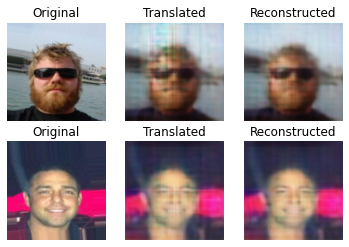

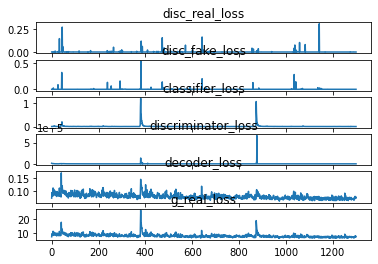

Train 0 / 100:  26%|██▌       | 1300/5086 [2:59:03<27:03:16, 25.73s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7983e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9284e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0433 - classifier_loss: 0.0051 - discriminator_loss: 4.5937e-10 - decoder_loss: 0.0799


Train 0 / 100:  26%|██▌       | 1301/5086 [2:59:11<21:23:32, 20.35s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7880e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1791e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.0467 - classifier_loss: 0.0048 - discriminator_loss: 5.4666e-10 - decoder_loss: 0.0700


Train 0 / 100:  26%|██▌       | 1302/5086 [2:59:19<17:21:08, 16.51s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3428e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0273e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8025 - classifier_loss: 0.0058 - discriminator_loss: 4.0934e-10 - decoder_loss: 0.0774


Train 0 / 100:  26%|██▌       | 1303/5086 [2:59:27<14:36:04, 13.89s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2112e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0390e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.5734 - classifier_loss: 0.0045 - discriminator_loss: 4.0592e-10 - decoder_loss: 0.0753


Train 0 / 100:  26%|██▌       | 1304/5086 [2:59:34<12:35:58, 11.99s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2138e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8473e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0198 - classifier_loss: 0.0052 - discriminator_loss: 3.7909e-10 - decoder_loss: 0.0697


Train 0 / 100:  26%|██▌       | 1305/5086 [2:59:42<11:12:19, 10.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2869e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0649e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9172 - classifier_loss: 0.0056 - discriminator_loss: 4.0044e-10 - decoder_loss: 0.0786


Train 0 / 100:  26%|██▌       | 1306/5086 [2:59:49<10:13:33,  9.74s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7717e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6843e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.6673 - classifier_loss: 0.0047 - discriminator_loss: 3.9966e-10 - decoder_loss: 0.0662


Train 0 / 100:  26%|██▌       | 1307/5086 [2:59:57<9:32:21,  9.09s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1778e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0780e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.8014 - classifier_loss: 0.0051 - discriminator_loss: 5.6772e-10 - decoder_loss: 0.0675


Train 0 / 100:  26%|██▌       | 1308/5086 [3:00:05<9:04:58,  8.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3972e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6974e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1524 - classifier_loss: 0.0054 - discriminator_loss: 5.8676e-10 - decoder_loss: 0.0810


Train 0 / 100:  26%|██▌       | 1309/5086 [3:00:12<8:44:53,  8.34s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7988e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.3389e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1719 - classifier_loss: 0.0105 - discriminator_loss: 4.2372e-10 - decoder_loss: 0.0707


Train 0 / 100:  26%|██▌       | 1310/5086 [3:00:20<8:31:12,  8.12s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8053e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8398e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.1355 - classifier_loss: 0.0054 - discriminator_loss: 4.6953e-10 - decoder_loss: 0.0708


Train 0 / 100:  26%|██▌       | 1311/5086 [3:00:27<8:22:36,  7.99s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1326e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1833e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0400 - classifier_loss: 0.0144 - discriminator_loss: 3.0829e-10 - decoder_loss: 0.0790


Train 0 / 100:  26%|██▌       | 1312/5086 [3:00:35<8:15:32,  7.88s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6186e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3968e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7590 - classifier_loss: 0.0166 - discriminator_loss: 2.7771e-10 - decoder_loss: 0.0759


Train 0 / 100:  26%|██▌       | 1313/5086 [3:00:43<8:09:24,  7.78s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6930e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0805e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7415 - classifier_loss: 0.0077 - discriminator_loss: 3.4376e-10 - decoder_loss: 0.0766


Train 0 / 100:  26%|██▌       | 1314/5086 [3:00:50<8:06:23,  7.74s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4094e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 2.4142e-06
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 6.8566 - classifier_loss: 0.0067 - discriminator_loss: 6.2451e-10 - decoder_loss: 0.0679


Train 0 / 100:  26%|██▌       | 1315/5086 [3:00:58<8:05:45,  7.73s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6335e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7528e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.3292 - classifier_loss: 0.0079 - discriminator_loss: 3.8335e-10 - decoder_loss: 0.0725


Train 0 / 100:  26%|██▌       | 1316/5086 [3:01:06<8:04:17,  7.71s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2388e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0889e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.1446 - classifier_loss: 0.0070 - discriminator_loss: 5.7086e-10 - decoder_loss: 0.0707


Train 0 / 100:  26%|██▌       | 1317/5086 [3:01:13<8:04:23,  7.71s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0446e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2473e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.7249 - classifier_loss: 0.0075 - discriminator_loss: 2.8813e-10 - decoder_loss: 0.0765


Train 0 / 100:  26%|██▌       | 1318/5086 [3:01:21<8:02:58,  7.69s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6969e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6589e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.4685 - classifier_loss: 0.0079 - discriminator_loss: 5.5223e-10 - decoder_loss: 0.0739


Train 0 / 100:  26%|██▌       | 1319/5086 [3:01:29<8:01:33,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8720e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0133e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3280 - classifier_loss: 0.0071 - discriminator_loss: 4.4067e-10 - decoder_loss: 0.0726


Train 0 / 100:  26%|██▌       | 1320/5086 [3:01:36<8:00:48,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2921e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7696e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.4635 - classifier_loss: 0.0085 - discriminator_loss: 3.3437e-10 - decoder_loss: 0.0638


Train 0 / 100:  26%|██▌       | 1321/5086 [3:01:44<8:00:17,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0715e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7560e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8756 - classifier_loss: 0.0052 - discriminator_loss: 3.0420e-10 - decoder_loss: 0.0682


Train 0 / 100:  26%|██▌       | 1322/5086 [3:01:52<8:00:09,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5397e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1444e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2701 - classifier_loss: 0.0063 - discriminator_loss: 7.8739e-10 - decoder_loss: 0.0721


Train 0 / 100:  26%|██▌       | 1323/5086 [3:01:59<7:59:25,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2488e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6253e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0812 - classifier_loss: 0.0062 - discriminator_loss: 5.3713e-10 - decoder_loss: 0.0702


Train 0 / 100:  26%|██▌       | 1324/5086 [3:02:07<7:58:58,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1036e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1390e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.1084 - classifier_loss: 0.0047 - discriminator_loss: 4.3247e-10 - decoder_loss: 0.0706


Train 0 / 100:  26%|██▌       | 1325/5086 [3:02:14<7:58:29,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3175e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6381e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4884 - classifier_loss: 0.0055 - discriminator_loss: 4.6011e-10 - decoder_loss: 0.0743


Train 0 / 100:  26%|██▌       | 1326/5086 [3:02:22<7:57:06,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2393e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.7457e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.6945 - classifier_loss: 0.0047 - discriminator_loss: 3.6320e-10 - decoder_loss: 0.0665


Train 0 / 100:  26%|██▌       | 1327/5086 [3:02:30<7:57:54,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7264e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4550e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.9416 - classifier_loss: 0.0056 - discriminator_loss: 4.4978e-10 - decoder_loss: 0.0689


Train 0 / 100:  26%|██▌       | 1328/5086 [3:02:37<7:57:41,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3600e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9913e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0862 - classifier_loss: 0.0053 - discriminator_loss: 3.2540e-10 - decoder_loss: 0.0703


Train 0 / 100:  26%|██▌       | 1329/5086 [3:02:45<7:57:16,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7201e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6277e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1525 - classifier_loss: 0.0063 - discriminator_loss: 3.4324e-10 - decoder_loss: 0.0709


Train 0 / 100:  26%|██▌       | 1330/5086 [3:02:52<7:57:10,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6712e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8693e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.1117 - classifier_loss: 0.0055 - discriminator_loss: 5.4532e-10 - decoder_loss: 0.0806


Train 0 / 100:  26%|██▌       | 1331/5086 [3:03:00<7:57:09,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1262e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5030e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1493 - classifier_loss: 0.0046 - discriminator_loss: 8.3332e-10 - decoder_loss: 0.0710


Train 0 / 100:  26%|██▌       | 1332/5086 [3:03:08<7:56:20,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5620e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5722e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.6265 - classifier_loss: 0.0058 - discriminator_loss: 3.2669e-10 - decoder_loss: 0.0757


Train 0 / 100:  26%|██▌       | 1333/5086 [3:03:15<7:56:45,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6877e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1959e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5886 - classifier_loss: 0.0056 - discriminator_loss: 3.1697e-10 - decoder_loss: 0.0753


Train 0 / 100:  26%|██▌       | 1334/5086 [3:03:23<7:55:42,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2536e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4018e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.6839 - classifier_loss: 0.0065 - discriminator_loss: 4.2398e-10 - decoder_loss: 0.0862


Train 0 / 100:  26%|██▌       | 1335/5086 [3:03:30<7:53:57,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5842e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7021e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 6.8925 - classifier_loss: 0.0047 - discriminator_loss: 3.5170e-10 - decoder_loss: 0.0685


Train 0 / 100:  26%|██▋       | 1336/5086 [3:03:38<7:53:24,  7.57s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5614e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5937e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8344 - classifier_loss: 0.0059 - discriminator_loss: 3.8802e-10 - decoder_loss: 0.0678


Train 0 / 100:  26%|██▋       | 1337/5086 [3:03:46<7:54:09,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4524e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0224e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.9104 - classifier_loss: 0.0058 - discriminator_loss: 4.3009e-10 - decoder_loss: 0.0785


Train 0 / 100:  26%|██▋       | 1338/5086 [3:03:53<7:55:44,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1213e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 4.1120e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.1935 - classifier_loss: 0.0050 - discriminator_loss: 3.8978e-10 - decoder_loss: 0.0714


Train 0 / 100:  26%|██▋       | 1339/5086 [3:04:01<7:56:42,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2476e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 5.4379e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.6043 - classifier_loss: 0.0058 - discriminator_loss: 4.7836e-10 - decoder_loss: 0.0855


Train 0 / 100:  26%|██▋       | 1340/5086 [3:04:09<7:55:04,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.9756e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8141e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7150 - classifier_loss: 0.0050 - discriminator_loss: 4.9010e-10 - decoder_loss: 0.0767


Train 0 / 100:  26%|██▋       | 1341/5086 [3:04:16<7:55:25,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2530e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5094e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7656 - classifier_loss: 0.0052 - discriminator_loss: 5.6283e-10 - decoder_loss: 0.0771


Train 0 / 100:  26%|██▋       | 1342/5086 [3:04:24<7:55:54,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5905e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0945e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3360 - classifier_loss: 0.0073 - discriminator_loss: 3.1232e-10 - decoder_loss: 0.0726


Train 0 / 100:  26%|██▋       | 1343/5086 [3:04:31<7:55:17,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8837e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9537e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.3793 - classifier_loss: 0.0047 - discriminator_loss: 3.2612e-10 - decoder_loss: 0.0733


Train 0 / 100:  26%|██▋       | 1344/5086 [3:04:39<7:57:47,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2142e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2158e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3239 - classifier_loss: 0.0060 - discriminator_loss: 2.7859e-10 - decoder_loss: 0.0726


Train 0 / 100:  26%|██▋       | 1345/5086 [3:04:47<7:56:46,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7213e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9715e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9730 - classifier_loss: 0.0045 - discriminator_loss: 3.8641e-10 - decoder_loss: 0.0693


Train 0 / 100:  26%|██▋       | 1346/5086 [3:04:54<7:56:18,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0443e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7791e-06
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.3721 - classifier_loss: 0.0052 - discriminator_loss: 3.2224e-10 - decoder_loss: 0.0732


Train 0 / 100:  26%|██▋       | 1347/5086 [3:05:02<7:57:12,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5132e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7969e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8030 - classifier_loss: 0.0050 - discriminator_loss: 5.1090e-10 - decoder_loss: 0.0775


Train 0 / 100:  27%|██▋       | 1348/5086 [3:05:10<7:55:50,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0492e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6610e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1755 - classifier_loss: 0.0069 - discriminator_loss: 3.8466e-10 - decoder_loss: 0.0711


Train 0 / 100:  27%|██▋       | 1349/5086 [3:05:17<7:55:33,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1597e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2717e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2366 - classifier_loss: 0.0051 - discriminator_loss: 3.3694e-10 - decoder_loss: 0.0719


Train 0 / 100:  27%|██▋       | 1350/5086 [3:05:25<7:54:58,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3407e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4952e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1082 - classifier_loss: 0.0053 - discriminator_loss: 5.1795e-10 - decoder_loss: 0.0705


Train 0 / 100:  27%|██▋       | 1351/5086 [3:05:32<7:53:30,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6350e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5458e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.1504 - classifier_loss: 0.0060 - discriminator_loss: 3.2488e-10 - decoder_loss: 0.0709


Train 0 / 100:  27%|██▋       | 1352/5086 [3:05:40<7:54:54,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2466e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6586e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 6.5942 - classifier_loss: 0.0045 - discriminator_loss: 3.7243e-10 - decoder_loss: 0.0655


Train 0 / 100:  27%|██▋       | 1353/5086 [3:05:48<7:55:44,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0877e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5554e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.0143 - classifier_loss: 0.0046 - discriminator_loss: 4.2551e-10 - decoder_loss: 0.0797


Train 0 / 100:  27%|██▋       | 1354/5086 [3:05:55<7:54:49,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5027e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3879e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9320 - classifier_loss: 0.0049 - discriminator_loss: 3.8959e-10 - decoder_loss: 0.0788


Train 0 / 100:  27%|██▋       | 1355/5086 [3:06:03<7:54:04,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7103e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9297e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.7919 - classifier_loss: 0.0054 - discriminator_loss: 3.3581e-10 - decoder_loss: 0.0674


Train 0 / 100:  27%|██▋       | 1356/5086 [3:06:11<7:54:02,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4989e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6098e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0812 - classifier_loss: 0.0060 - discriminator_loss: 2.8265e-10 - decoder_loss: 0.0702


Train 0 / 100:  27%|██▋       | 1357/5086 [3:06:18<7:53:02,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1930e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7211e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3948 - classifier_loss: 0.0053 - discriminator_loss: 4.5288e-10 - decoder_loss: 0.0734


Train 0 / 100:  27%|██▋       | 1358/5086 [3:06:26<7:51:51,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9038e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8821e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5577 - classifier_loss: 0.0046 - discriminator_loss: 7.6492e-10 - decoder_loss: 0.0751


Train 0 / 100:  27%|██▋       | 1359/5086 [3:06:33<7:51:59,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3208e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8453e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.6144 - classifier_loss: 0.0051 - discriminator_loss: 5.4612e-10 - decoder_loss: 0.0856


Train 0 / 100:  27%|██▋       | 1360/5086 [3:06:41<7:51:04,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3792e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9027e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.5657 - classifier_loss: 0.0057 - discriminator_loss: 3.4408e-10 - decoder_loss: 0.0651


Train 0 / 100:  27%|██▋       | 1361/5086 [3:06:49<7:50:54,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4538e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2208e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9780 - classifier_loss: 0.0056 - discriminator_loss: 7.2226e-10 - decoder_loss: 0.0792


Train 0 / 100:  27%|██▋       | 1362/5086 [3:06:56<7:52:09,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5130e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6601e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1665 - classifier_loss: 0.0066 - discriminator_loss: 3.8679e-10 - decoder_loss: 0.0710


Train 0 / 100:  27%|██▋       | 1363/5086 [3:07:04<7:52:06,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2054e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1868e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1874 - classifier_loss: 0.0063 - discriminator_loss: 4.2394e-10 - decoder_loss: 0.0712


Train 0 / 100:  27%|██▋       | 1364/5086 [3:07:11<7:51:53,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8263e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6206e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6513 - classifier_loss: 0.0057 - discriminator_loss: 4.9788e-10 - decoder_loss: 0.0759


Train 0 / 100:  27%|██▋       | 1365/5086 [3:07:19<7:51:11,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5110e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5354e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0841 - classifier_loss: 0.0048 - discriminator_loss: 3.0897e-10 - decoder_loss: 0.0704


Train 0 / 100:  27%|██▋       | 1366/5086 [3:07:27<7:51:32,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0540e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9605e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2962 - classifier_loss: 0.0055 - discriminator_loss: 3.4329e-10 - decoder_loss: 0.0724


Train 0 / 100:  27%|██▋       | 1367/5086 [3:07:34<7:50:46,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5382e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4698e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9451 - classifier_loss: 0.0050 - discriminator_loss: 3.3182e-10 - decoder_loss: 0.0690


Train 0 / 100:  27%|██▋       | 1368/5086 [3:07:42<7:50:42,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2105e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5650e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3938 - classifier_loss: 0.0063 - discriminator_loss: 3.5987e-10 - decoder_loss: 0.0733


Train 0 / 100:  27%|██▋       | 1369/5086 [3:07:49<7:50:38,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7479e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6900e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9429 - classifier_loss: 0.0062 - discriminator_loss: 3.8171e-10 - decoder_loss: 0.0788


Train 0 / 100:  27%|██▋       | 1370/5086 [3:07:57<7:51:13,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1060e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5030e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.6803 - classifier_loss: 0.0054 - discriminator_loss: 4.0896e-10 - decoder_loss: 0.0663


Train 0 / 100:  27%|██▋       | 1371/5086 [3:08:05<7:51:04,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9991e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1158e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.7108 - classifier_loss: 0.0051 - discriminator_loss: 3.5508e-10 - decoder_loss: 0.0766


Train 0 / 100:  27%|██▋       | 1372/5086 [3:08:12<7:51:58,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4278e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5069e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.1975 - classifier_loss: 0.0058 - discriminator_loss: 3.2676e-10 - decoder_loss: 0.0714


Train 0 / 100:  27%|██▋       | 1373/5086 [3:08:20<7:50:41,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3133e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6159e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0668 - classifier_loss: 0.0048 - discriminator_loss: 4.0785e-10 - decoder_loss: 0.0702


Train 0 / 100:  27%|██▋       | 1374/5086 [3:08:28<7:50:58,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3672e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7693e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.3309 - classifier_loss: 0.0046 - discriminator_loss: 8.1551e-10 - decoder_loss: 0.0828


Train 0 / 100:  27%|██▋       | 1375/5086 [3:08:35<7:52:03,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3820e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7441e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6964 - classifier_loss: 0.0055 - discriminator_loss: 6.2611e-10 - decoder_loss: 0.0764


Train 0 / 100:  27%|██▋       | 1376/5086 [3:08:43<7:51:19,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5514e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5710e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0747 - classifier_loss: 0.0044 - discriminator_loss: 5.4715e-10 - decoder_loss: 0.0703


Train 0 / 100:  27%|██▋       | 1377/5086 [3:08:50<7:49:38,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5763e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1211e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2107 - classifier_loss: 0.0047 - discriminator_loss: 3.9374e-10 - decoder_loss: 0.0716


Train 0 / 100:  27%|██▋       | 1378/5086 [3:08:58<7:49:39,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2974e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2941e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0032 - classifier_loss: 0.0048 - discriminator_loss: 8.4872e-10 - decoder_loss: 0.0696


Train 0 / 100:  27%|██▋       | 1379/5086 [3:09:06<7:48:53,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2604e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2952e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0793 - classifier_loss: 0.0048 - discriminator_loss: 4.3289e-10 - decoder_loss: 0.0703


Train 0 / 100:  27%|██▋       | 1380/5086 [3:09:13<7:48:33,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0188e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0127e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.4228 - classifier_loss: 0.0048 - discriminator_loss: 3.6540e-10 - decoder_loss: 0.0738


Train 0 / 100:  27%|██▋       | 1381/5086 [3:09:21<7:50:50,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4850e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7405e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8666 - classifier_loss: 0.0055 - discriminator_loss: 3.2911e-10 - decoder_loss: 0.0681


Train 0 / 100:  27%|██▋       | 1382/5086 [3:09:28<7:51:15,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5013e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3241e-08
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.0414 - classifier_loss: 0.0044 - discriminator_loss: 2.9544e-10 - decoder_loss: 0.0800


Train 0 / 100:  27%|██▋       | 1383/5086 [3:09:36<7:52:23,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5878e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4169e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9600 - classifier_loss: 0.0050 - discriminator_loss: 3.4753e-10 - decoder_loss: 0.0691


Train 0 / 100:  27%|██▋       | 1384/5086 [3:09:44<7:51:32,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1430e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0199e-07
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.0062 - classifier_loss: 0.0049 - discriminator_loss: 4.4828e-10 - decoder_loss: 0.0696


Train 0 / 100:  27%|██▋       | 1385/5086 [3:09:51<7:52:02,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3690e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2294e-05
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.3601 - classifier_loss: 0.0052 - discriminator_loss: 4.5294e-10 - decoder_loss: 0.0731


Train 0 / 100:  27%|██▋       | 1386/5086 [3:09:59<7:50:41,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8085e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8819e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9799 - classifier_loss: 0.0043 - discriminator_loss: 3.9453e-10 - decoder_loss: 0.0694


Train 0 / 100:  27%|██▋       | 1387/5086 [3:10:07<7:49:38,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9273e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4163e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8436 - classifier_loss: 0.0051 - discriminator_loss: 6.0713e-10 - decoder_loss: 0.0779


Train 0 / 100:  27%|██▋       | 1388/5086 [3:10:14<7:49:18,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3948e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6600e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6311 - classifier_loss: 0.0057 - discriminator_loss: 3.9988e-10 - decoder_loss: 0.0757


Train 0 / 100:  27%|██▋       | 1389/5086 [3:10:22<7:48:17,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4087e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 4.0784e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4539 - classifier_loss: 0.0041 - discriminator_loss: 3.5264e-10 - decoder_loss: 0.0741


Train 0 / 100:  27%|██▋       | 1390/5086 [3:10:29<7:48:13,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5951e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3968e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4587 - classifier_loss: 0.0050 - discriminator_loss: 5.2675e-10 - decoder_loss: 0.0741


Train 0 / 100:  27%|██▋       | 1391/5086 [3:10:37<7:47:23,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4973e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4652e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.6426 - classifier_loss: 0.0053 - discriminator_loss: 3.9216e-10 - decoder_loss: 0.0759


Train 0 / 100:  27%|██▋       | 1392/5086 [3:10:45<7:48:42,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1558e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2735e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.5855 - classifier_loss: 0.0050 - discriminator_loss: 4.0640e-10 - decoder_loss: 0.0654


Train 0 / 100:  27%|██▋       | 1393/5086 [3:10:52<7:47:39,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.2410e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0099
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.7851 - classifier_loss: 0.0049 - discriminator_loss: 2.1958e-10 - decoder_loss: 0.0674


Train 0 / 100:  27%|██▋       | 1394/5086 [3:11:00<7:47:49,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8177e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6688e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2896 - classifier_loss: 0.0059 - discriminator_loss: 1.7129e-10 - decoder_loss: 0.0723


Train 0 / 100:  27%|██▋       | 1395/5086 [3:11:07<7:47:56,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.6765e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4566e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.1343 - classifier_loss: 0.0061 - discriminator_loss: 1.3944e-10 - decoder_loss: 0.0707


Train 0 / 100:  27%|██▋       | 1396/5086 [3:11:15<7:48:35,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0131e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0790e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6441 - classifier_loss: 0.0055 - discriminator_loss: 2.6262e-10 - decoder_loss: 0.0759


Train 0 / 100:  27%|██▋       | 1397/5086 [3:11:23<7:47:45,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0995e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0085e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5509 - classifier_loss: 0.0058 - discriminator_loss: 1.4886e-10 - decoder_loss: 0.0749


Train 0 / 100:  27%|██▋       | 1398/5086 [3:11:30<7:47:25,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5304e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0416e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0994 - classifier_loss: 0.0063 - discriminator_loss: 1.4401e-10 - decoder_loss: 0.0704


Train 0 / 100:  28%|██▊       | 1399/5086 [3:11:38<7:47:27,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9764e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3355e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.3001 - classifier_loss: 0.0043 - discriminator_loss: 1.5609e-10 - decoder_loss: 0.0626
Epoch: 0 with batch: 1399


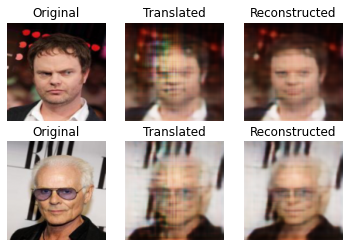

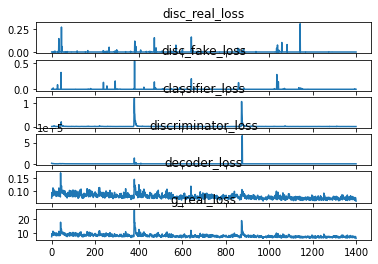

Train 0 / 100:  28%|██▊       | 1400/5086 [3:12:45<26:07:29, 25.52s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8787e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2830e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.7435 - classifier_loss: 0.0061 - discriminator_loss: 1.7198e-10 - decoder_loss: 0.0768


Train 0 / 100:  28%|██▊       | 1401/5086 [3:12:53<20:39:20, 20.18s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0257e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1015e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.5677 - classifier_loss: 0.0048 - discriminator_loss: 1.4849e-10 - decoder_loss: 0.0752


Train 0 / 100:  28%|██▊       | 1402/5086 [3:13:01<16:51:12, 16.47s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4240e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5544e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 6.8176 - classifier_loss: 0.0054 - discriminator_loss: 1.7167e-10 - decoder_loss: 0.0676


Train 0 / 100:  28%|██▊       | 1403/5086 [3:13:08<14:06:27, 13.79s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3518e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6397e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 6.7466 - classifier_loss: 0.0072 - discriminator_loss: 1.4266e-10 - decoder_loss: 0.0667


Train 0 / 100:  28%|██▊       | 1404/5086 [3:13:16<12:10:57, 11.91s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7757e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6856e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6887 - classifier_loss: 0.0042 - discriminator_loss: 1.5328e-10 - decoder_loss: 0.0765


Train 0 / 100:  28%|██▊       | 1405/5086 [3:13:23<10:50:44, 10.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5192e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.7527e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1300 - classifier_loss: 0.0045 - discriminator_loss: 1.8384e-10 - decoder_loss: 0.0708


Train 0 / 100:  28%|██▊       | 1406/5086 [3:13:31<9:55:19,  9.71s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0128
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0304e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9491 - classifier_loss: 0.0045 - discriminator_loss: 3.1788e-10 - decoder_loss: 0.0690


Train 0 / 100:  28%|██▊       | 1407/5086 [3:13:39<9:15:55,  9.07s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7745e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1240e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.6709 - classifier_loss: 0.0046 - discriminator_loss: 3.3706e-10 - decoder_loss: 0.0862


Train 0 / 100:  28%|██▊       | 1408/5086 [3:13:46<8:48:44,  8.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2101e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1972e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0810 - classifier_loss: 0.0053 - discriminator_loss: 2.3922e-10 - decoder_loss: 0.0703


Train 0 / 100:  28%|██▊       | 1409/5086 [3:13:54<8:29:03,  8.31s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5696e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.7662e-06
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.7168 - classifier_loss: 0.0043 - discriminator_loss: 3.0839e-10 - decoder_loss: 0.0667


Train 0 / 100:  28%|██▊       | 1410/5086 [3:14:01<8:16:38,  8.11s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2692e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3140e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2121 - classifier_loss: 0.0053 - discriminator_loss: 3.4323e-10 - decoder_loss: 0.0716


Train 0 / 100:  28%|██▊       | 1411/5086 [3:14:09<8:07:34,  7.96s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2346e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 8.8175e-07
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.7381 - classifier_loss: 0.0046 - discriminator_loss: 4.6056e-10 - decoder_loss: 0.0769


Train 0 / 100:  28%|██▊       | 1412/5086 [3:14:16<7:59:23,  7.83s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4929e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6950e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9292 - classifier_loss: 0.0044 - discriminator_loss: 3.1901e-10 - decoder_loss: 0.0689


Train 0 / 100:  28%|██▊       | 1413/5086 [3:14:24<7:55:24,  7.77s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3415e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5239e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7552 - classifier_loss: 0.0043 - discriminator_loss: 4.3698e-10 - decoder_loss: 0.0771


Train 0 / 100:  28%|██▊       | 1414/5086 [3:14:32<7:52:46,  7.73s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4997e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2337e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2423 - classifier_loss: 0.0050 - discriminator_loss: 2.5550e-10 - decoder_loss: 0.0719


Train 0 / 100:  28%|██▊       | 1415/5086 [3:14:39<7:51:24,  7.70s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3793e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2291e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6628 - classifier_loss: 0.0061 - discriminator_loss: 2.0561e-10 - decoder_loss: 0.0760


Train 0 / 100:  28%|██▊       | 1416/5086 [3:14:47<7:49:02,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7899e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2217e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8504 - classifier_loss: 0.0048 - discriminator_loss: 2.6753e-10 - decoder_loss: 0.0780


Train 0 / 100:  28%|██▊       | 1417/5086 [3:14:55<7:47:50,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0581e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8353e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9986 - classifier_loss: 0.0045 - discriminator_loss: 2.9784e-10 - decoder_loss: 0.0795


Train 0 / 100:  28%|██▊       | 1418/5086 [3:15:02<7:48:07,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.5735e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2124e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6584 - classifier_loss: 0.0048 - discriminator_loss: 4.1304e-10 - decoder_loss: 0.0861


Train 0 / 100:  28%|██▊       | 1419/5086 [3:15:10<7:46:59,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2184e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6782e-04
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.5186 - classifier_loss: 0.0077 - discriminator_loss: 3.4214e-10 - decoder_loss: 0.0944


Train 0 / 100:  28%|██▊       | 1420/5086 [3:15:17<7:45:48,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2515e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.4668e-05
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 9.7243 - classifier_loss: 0.0053 - discriminator_loss: 2.2953e-10 - decoder_loss: 0.0967


Train 0 / 100:  28%|██▊       | 1421/5086 [3:15:25<7:46:08,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9070e-06
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 5.7101e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1572 - classifier_loss: 0.0055 - discriminator_loss: 2.0476e-10 - decoder_loss: 0.0810


Train 0 / 100:  28%|██▊       | 1422/5086 [3:15:33<7:46:06,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6904e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2689e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.0989 - classifier_loss: 0.0062 - discriminator_loss: 2.2812e-10 - decoder_loss: 0.0804


Train 0 / 100:  28%|██▊       | 1423/5086 [3:15:40<7:46:46,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1113e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6286e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.7028 - classifier_loss: 0.0060 - discriminator_loss: 1.8896e-10 - decoder_loss: 0.0764


Train 0 / 100:  28%|██▊       | 1424/5086 [3:15:48<7:47:15,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8386e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.8939e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.8639 - classifier_loss: 0.0164 - discriminator_loss: 2.2995e-10 - decoder_loss: 0.0870


Train 0 / 100:  28%|██▊       | 1425/5086 [3:15:56<7:45:08,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5277e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2615e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0078 - classifier_loss: 0.0080 - discriminator_loss: 1.6509e-10 - decoder_loss: 0.0793


Train 0 / 100:  28%|██▊       | 1426/5086 [3:16:03<7:45:32,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6176e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8351e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5169 - classifier_loss: 0.0080 - discriminator_loss: 1.9865e-10 - decoder_loss: 0.0744


Train 0 / 100:  28%|██▊       | 1427/5086 [3:16:11<7:44:51,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5402e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2621e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8792 - classifier_loss: 0.0064 - discriminator_loss: 2.8176e-10 - decoder_loss: 0.0782


Train 0 / 100:  28%|██▊       | 1428/5086 [3:16:18<7:44:06,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3180e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4258e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2612 - classifier_loss: 0.0053 - discriminator_loss: 2.0238e-10 - decoder_loss: 0.0721


Train 0 / 100:  28%|██▊       | 1429/5086 [3:16:26<7:43:25,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.9933e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 6.9796e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5762 - classifier_loss: 0.0050 - discriminator_loss: 2.0482e-10 - decoder_loss: 0.0753


Train 0 / 100:  28%|██▊       | 1430/5086 [3:16:34<7:43:25,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5034e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0395e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9962 - classifier_loss: 0.0064 - discriminator_loss: 1.7583e-10 - decoder_loss: 0.0793


Train 0 / 100:  28%|██▊       | 1431/5086 [3:16:41<7:43:55,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8651e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5422e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2423 - classifier_loss: 0.0058 - discriminator_loss: 2.0591e-10 - decoder_loss: 0.0718


Train 0 / 100:  28%|██▊       | 1432/5086 [3:16:49<7:43:33,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4740e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4870e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0990 - classifier_loss: 0.0050 - discriminator_loss: 2.0333e-10 - decoder_loss: 0.0705


Train 0 / 100:  28%|██▊       | 1433/5086 [3:16:56<7:42:57,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4698e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0864e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 6.7146 - classifier_loss: 0.0058 - discriminator_loss: 2.4046e-10 - decoder_loss: 0.0666


Train 0 / 100:  28%|██▊       | 1434/5086 [3:17:04<7:44:09,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9869e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7384e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6592 - classifier_loss: 0.0057 - discriminator_loss: 1.7249e-10 - decoder_loss: 0.0760


Train 0 / 100:  28%|██▊       | 1435/5086 [3:17:12<7:43:16,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4284e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0018e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2937 - classifier_loss: 0.0065 - discriminator_loss: 1.8549e-10 - decoder_loss: 0.0723


Train 0 / 100:  28%|██▊       | 1436/5086 [3:17:19<7:43:27,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1577e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2027e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.0082 - classifier_loss: 0.0055 - discriminator_loss: 2.0907e-10 - decoder_loss: 0.0695


Train 0 / 100:  28%|██▊       | 1437/5086 [3:17:27<7:43:33,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8757e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2701e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6012 - classifier_loss: 0.0057 - discriminator_loss: 3.1913e-10 - decoder_loss: 0.0854


Train 0 / 100:  28%|██▊       | 1438/5086 [3:17:35<7:43:13,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6933e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0063e-08
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.8770 - classifier_loss: 0.0050 - discriminator_loss: 2.7850e-10 - decoder_loss: 0.0883


Train 0 / 100:  28%|██▊       | 1439/5086 [3:17:42<7:44:52,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6943e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2852e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.3898 - classifier_loss: 0.0059 - discriminator_loss: 3.0090e-10 - decoder_loss: 0.0833


Train 0 / 100:  28%|██▊       | 1440/5086 [3:17:50<7:43:54,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8468e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7450e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.4326 - classifier_loss: 0.0053 - discriminator_loss: 2.5284e-10 - decoder_loss: 0.0838


Train 0 / 100:  28%|██▊       | 1441/5086 [3:17:57<7:42:42,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1783e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.0823e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8518 - classifier_loss: 0.0090 - discriminator_loss: 2.2544e-10 - decoder_loss: 0.0776


Train 0 / 100:  28%|██▊       | 1442/5086 [3:18:05<7:42:29,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9138e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 2.8449e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.3249 - classifier_loss: 0.0064 - discriminator_loss: 2.3273e-10 - decoder_loss: 0.0726


Train 0 / 100:  28%|██▊       | 1443/5086 [3:18:13<7:42:13,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4668e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9775e-09
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 7.7484 - classifier_loss: 0.0056 - discriminator_loss: 1.3246e-10 - decoder_loss: 0.0769


Train 0 / 100:  28%|██▊       | 1444/5086 [3:18:20<7:43:34,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8181e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6687e-08
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.7923 - classifier_loss: 0.0071 - discriminator_loss: 1.4554e-10 - decoder_loss: 0.0772


Train 0 / 100:  28%|██▊       | 1445/5086 [3:18:28<7:43:52,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7650e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6133e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.8735 - classifier_loss: 0.0052 - discriminator_loss: 2.4097e-10 - decoder_loss: 0.0682


Train 0 / 100:  28%|██▊       | 1446/5086 [3:18:36<7:43:34,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3783e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1872e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9034 - classifier_loss: 0.0061 - discriminator_loss: 1.7036e-10 - decoder_loss: 0.0784


Train 0 / 100:  28%|██▊       | 1447/5086 [3:18:43<7:42:48,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0871e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4202e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9125 - classifier_loss: 0.0071 - discriminator_loss: 1.8996e-10 - decoder_loss: 0.0784


Train 0 / 100:  28%|██▊       | 1448/5086 [3:18:51<7:41:36,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2128e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9155e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.0783 - classifier_loss: 0.0045 - discriminator_loss: 1.9978e-10 - decoder_loss: 0.0703


Train 0 / 100:  28%|██▊       | 1449/5086 [3:18:59<7:41:50,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7793e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3210e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.7531 - classifier_loss: 0.0053 - discriminator_loss: 4.3581e-10 - decoder_loss: 0.0770


Train 0 / 100:  29%|██▊       | 1450/5086 [3:19:06<7:41:41,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.1451e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0921e-08
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 8.2501 - classifier_loss: 0.0290 - discriminator_loss: 2.5897e-10 - decoder_loss: 0.0796


Train 0 / 100:  29%|██▊       | 1451/5086 [3:19:14<7:43:21,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4628e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4146e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 9.6249 - classifier_loss: 0.0118 - discriminator_loss: 1.7213e-10 - decoder_loss: 0.0951


Train 0 / 100:  29%|██▊       | 1452/5086 [3:19:21<7:41:32,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8946e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5452e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.6844 - classifier_loss: 0.0099 - discriminator_loss: 1.8793e-10 - decoder_loss: 0.0859


Train 0 / 100:  29%|██▊       | 1453/5086 [3:19:29<7:40:34,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8896e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4524e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5593 - classifier_loss: 0.0103 - discriminator_loss: 2.9356e-10 - decoder_loss: 0.0746


Train 0 / 100:  29%|██▊       | 1454/5086 [3:19:37<7:40:18,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.9539e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9284e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6716 - classifier_loss: 0.0082 - discriminator_loss: 3.3176e-10 - decoder_loss: 0.0759


Train 0 / 100:  29%|██▊       | 1455/5086 [3:19:44<7:40:32,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2395e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9534e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2108 - classifier_loss: 0.0064 - discriminator_loss: 2.2175e-10 - decoder_loss: 0.0715


Train 0 / 100:  29%|██▊       | 1456/5086 [3:19:52<7:41:08,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7132e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.4883e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8924 - classifier_loss: 0.0064 - discriminator_loss: 2.4933e-10 - decoder_loss: 0.0683


Train 0 / 100:  29%|██▊       | 1457/5086 [3:19:59<7:40:08,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8158e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0978e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.0915 - classifier_loss: 0.0056 - discriminator_loss: 3.4044e-10 - decoder_loss: 0.0704


Train 0 / 100:  29%|██▊       | 1458/5086 [3:20:07<7:40:19,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2471e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0973e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.3351 - classifier_loss: 0.0057 - discriminator_loss: 2.1967e-10 - decoder_loss: 0.0728


Train 0 / 100:  29%|██▊       | 1459/5086 [3:20:15<7:40:47,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5781e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 2.1029e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7411 - classifier_loss: 0.0062 - discriminator_loss: 2.1321e-10 - decoder_loss: 0.0768


Train 0 / 100:  29%|██▊       | 1460/5086 [3:20:22<7:40:04,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9438e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5387e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4398 - classifier_loss: 0.0062 - discriminator_loss: 2.3641e-10 - decoder_loss: 0.0738


Train 0 / 100:  29%|██▊       | 1461/5086 [3:20:30<7:39:37,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8908e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4884e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.5283 - classifier_loss: 0.0054 - discriminator_loss: 2.4634e-10 - decoder_loss: 0.0647


Train 0 / 100:  29%|██▊       | 1462/5086 [3:20:37<7:39:38,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4816e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 7.3487e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.5844 - classifier_loss: 0.0060 - discriminator_loss: 2.4808e-10 - decoder_loss: 0.0652


Train 0 / 100:  29%|██▉       | 1463/5086 [3:20:45<7:39:38,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8860e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3095e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.2994 - classifier_loss: 0.0059 - discriminator_loss: 2.4794e-10 - decoder_loss: 0.0724


Train 0 / 100:  29%|██▉       | 1464/5086 [3:20:53<7:41:07,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9870e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8973e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2189 - classifier_loss: 0.0063 - discriminator_loss: 2.4518e-10 - decoder_loss: 0.0716


Train 0 / 100:  29%|██▉       | 1465/5086 [3:21:00<7:40:01,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5680e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2460e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0639 - classifier_loss: 0.0050 - discriminator_loss: 1.9440e-10 - decoder_loss: 0.0801


Train 0 / 100:  29%|██▉       | 1466/5086 [3:21:08<7:39:18,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.6166e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.6429e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.3360 - classifier_loss: 0.0047 - discriminator_loss: 1.8941e-10 - decoder_loss: 0.0729


Train 0 / 100:  29%|██▉       | 1467/5086 [3:21:16<7:39:31,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8005e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6784e-09
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 8.1183 - classifier_loss: 0.0053 - discriminator_loss: 2.1528e-10 - decoder_loss: 0.0807


Train 0 / 100:  29%|██▉       | 1468/5086 [3:21:23<7:41:13,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6082e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.1258e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.2713 - classifier_loss: 0.0048 - discriminator_loss: 2.0728e-10 - decoder_loss: 0.0722


Train 0 / 100:  29%|██▉       | 1469/5086 [3:21:31<7:40:54,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5828e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9292e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8558 - classifier_loss: 0.0062 - discriminator_loss: 2.0527e-10 - decoder_loss: 0.0779


Train 0 / 100:  29%|██▉       | 1470/5086 [3:21:39<7:40:19,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7379e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8849e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4037 - classifier_loss: 0.0051 - discriminator_loss: 1.9882e-10 - decoder_loss: 0.0735


Train 0 / 100:  29%|██▉       | 1471/5086 [3:21:46<7:39:27,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5484e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2170e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4346 - classifier_loss: 0.0066 - discriminator_loss: 2.5719e-10 - decoder_loss: 0.0737


Train 0 / 100:  29%|██▉       | 1472/5086 [3:21:54<7:38:38,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8989e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3087e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.6918 - classifier_loss: 0.0056 - discriminator_loss: 2.6324e-10 - decoder_loss: 0.0664


Train 0 / 100:  29%|██▉       | 1473/5086 [3:22:01<7:38:17,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8878e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5474e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9879 - classifier_loss: 0.0054 - discriminator_loss: 2.5173e-10 - decoder_loss: 0.0693


Train 0 / 100:  29%|██▉       | 1474/5086 [3:22:09<7:38:21,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2390e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3217e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.6693 - classifier_loss: 0.0046 - discriminator_loss: 2.3341e-10 - decoder_loss: 0.0762


Train 0 / 100:  29%|██▉       | 1475/5086 [3:22:17<7:38:44,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7765e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2546e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5770 - classifier_loss: 0.0049 - discriminator_loss: 3.1563e-10 - decoder_loss: 0.0753


Train 0 / 100:  29%|██▉       | 1476/5086 [3:22:24<7:39:09,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1218e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9761e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.8355 - classifier_loss: 0.0053 - discriminator_loss: 2.4067e-10 - decoder_loss: 0.0778


Train 0 / 100:  29%|██▉       | 1477/5086 [3:22:32<7:38:03,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6663e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0623e-07
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.0551 - classifier_loss: 0.0044 - discriminator_loss: 2.9404e-10 - decoder_loss: 0.0701


Train 0 / 100:  29%|██▉       | 1478/5086 [3:22:40<7:39:04,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5830e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5457e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.5243 - classifier_loss: 0.0047 - discriminator_loss: 2.2267e-10 - decoder_loss: 0.0648


Train 0 / 100:  29%|██▉       | 1479/5086 [3:22:47<7:38:33,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1410e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2194e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.3570 - classifier_loss: 0.0054 - discriminator_loss: 2.6608e-10 - decoder_loss: 0.0730


Train 0 / 100:  29%|██▉       | 1480/5086 [3:22:55<7:38:57,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3920e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7328e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.1490 - classifier_loss: 0.0040 - discriminator_loss: 3.0425e-10 - decoder_loss: 0.0711


Train 0 / 100:  29%|██▉       | 1481/5086 [3:23:02<7:38:47,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3608e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8726e-04
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.8725 - classifier_loss: 0.0057 - discriminator_loss: 2.2474e-10 - decoder_loss: 0.0682


Train 0 / 100:  29%|██▉       | 1482/5086 [3:23:10<7:38:56,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7463e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0421e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5944 - classifier_loss: 0.0048 - discriminator_loss: 2.5411e-10 - decoder_loss: 0.0755


Train 0 / 100:  29%|██▉       | 1483/5086 [3:23:18<7:38:40,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8254e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8308e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0418 - classifier_loss: 0.0048 - discriminator_loss: 2.9993e-10 - decoder_loss: 0.0699


Train 0 / 100:  29%|██▉       | 1484/5086 [3:23:25<7:38:15,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3657e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3024e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9354 - classifier_loss: 0.0047 - discriminator_loss: 2.4999e-10 - decoder_loss: 0.0689


Train 0 / 100:  29%|██▉       | 1485/5086 [3:23:33<7:37:57,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.6496e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1703e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1908 - classifier_loss: 0.0054 - discriminator_loss: 2.0636e-10 - decoder_loss: 0.0714


Train 0 / 100:  29%|██▉       | 1486/5086 [3:23:41<7:36:34,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5794e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2395e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9257 - classifier_loss: 0.0052 - discriminator_loss: 1.7476e-10 - decoder_loss: 0.0687


Train 0 / 100:  29%|██▉       | 1487/5086 [3:23:48<7:36:13,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4374e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7776e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6646 - classifier_loss: 0.0068 - discriminator_loss: 2.1713e-10 - decoder_loss: 0.0760


Train 0 / 100:  29%|██▉       | 1488/5086 [3:23:56<7:36:38,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5756e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2874e-10
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.1854 - classifier_loss: 0.0066 - discriminator_loss: 2.5676e-10 - decoder_loss: 0.0712


Train 0 / 100:  29%|██▉       | 1489/5086 [3:24:03<7:36:24,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.9855e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.1282e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9174 - classifier_loss: 0.0050 - discriminator_loss: 2.8407e-10 - decoder_loss: 0.0687


Train 0 / 100:  29%|██▉       | 1490/5086 [3:24:11<7:37:24,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2376e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8943e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2538 - classifier_loss: 0.0051 - discriminator_loss: 2.5024e-10 - decoder_loss: 0.0720


Train 0 / 100:  29%|██▉       | 1491/5086 [3:24:19<7:36:06,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6208e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1495e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.9982 - classifier_loss: 0.0053 - discriminator_loss: 2.8305e-10 - decoder_loss: 0.0795


Train 0 / 100:  29%|██▉       | 1492/5086 [3:24:26<7:35:15,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9381e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5913e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9259 - classifier_loss: 0.0055 - discriminator_loss: 2.8583e-10 - decoder_loss: 0.0787


Train 0 / 100:  29%|██▉       | 1493/5086 [3:24:34<7:35:51,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.9920e-08
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 5.8119e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.9162 - classifier_loss: 0.0063 - discriminator_loss: 3.1254e-10 - decoder_loss: 0.0785


Train 0 / 100:  29%|██▉       | 1494/5086 [3:24:41<7:36:10,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9037e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0182e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2553 - classifier_loss: 0.0047 - discriminator_loss: 2.3159e-10 - decoder_loss: 0.0721


Train 0 / 100:  29%|██▉       | 1495/5086 [3:24:49<7:36:07,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5908e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5377e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7409 - classifier_loss: 0.0081 - discriminator_loss: 2.1597e-10 - decoder_loss: 0.0766


Train 0 / 100:  29%|██▉       | 1496/5086 [3:24:57<7:36:23,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2926e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5402e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2614 - classifier_loss: 0.0055 - discriminator_loss: 3.4534e-10 - decoder_loss: 0.0821


Train 0 / 100:  29%|██▉       | 1497/5086 [3:25:04<7:36:32,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1529e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7212e-05
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0173 - classifier_loss: 0.0054 - discriminator_loss: 1.8830e-10 - decoder_loss: 0.0696


Train 0 / 100:  29%|██▉       | 1498/5086 [3:25:12<7:36:02,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3582e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0978e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.0056 - classifier_loss: 0.0046 - discriminator_loss: 2.3246e-10 - decoder_loss: 0.0696


Train 0 / 100:  29%|██▉       | 1499/5086 [3:25:20<7:36:45,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0458e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8650e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0990 - classifier_loss: 0.0053 - discriminator_loss: 2.2254e-10 - decoder_loss: 0.0705
Epoch: 0 with batch: 1499


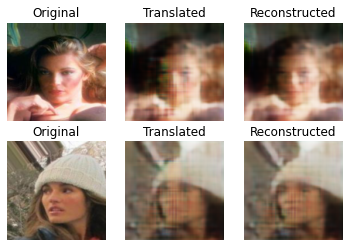

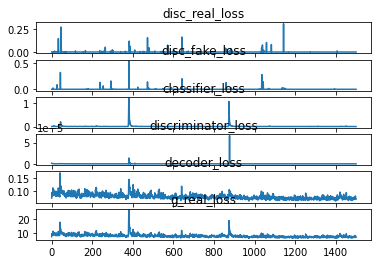

Train 0 / 100:  29%|██▉       | 1500/5086 [3:26:27<25:21:08, 25.45s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1828e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3429e-07
Epoch 1/1
32/32 [==============================] - 6s 177ms/step - loss: 6.8961 - classifier_loss: 0.0048 - discriminator_loss: 1.9618e-10 - decoder_loss: 0.0685


Train 0 / 100:  30%|██▉       | 1501/5086 [3:26:36<20:28:06, 20.55s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.4691e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1311e-09
Epoch 1/1
32/32 [==============================] - 6s 178ms/step - loss: 7.2659 - classifier_loss: 0.0052 - discriminator_loss: 2.2684e-10 - decoder_loss: 0.0721


Train 0 / 100:  30%|██▉       | 1502/5086 [3:26:44<16:38:17, 16.71s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8077e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0054e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0657 - classifier_loss: 0.0047 - discriminator_loss: 2.3760e-10 - decoder_loss: 0.0702


Train 0 / 100:  30%|██▉       | 1503/5086 [3:26:51<13:57:26, 14.02s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5976e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5511e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.8381 - classifier_loss: 0.0040 - discriminator_loss: 2.4347e-10 - decoder_loss: 0.0680


Train 0 / 100:  30%|██▉       | 1504/5086 [3:26:59<12:01:23, 12.08s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5016e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.7049e-08
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 8.4681 - classifier_loss: 0.0053 - discriminator_loss: 2.4372e-10 - decoder_loss: 0.0841


Train 0 / 100:  30%|██▉       | 1505/5086 [3:27:06<10:40:01, 10.72s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7258e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.2795e-09
Epoch 1/1
32/32 [==============================] - 6s 179ms/step - loss: 7.2262 - classifier_loss: 0.0054 - discriminator_loss: 2.7519e-10 - decoder_loss: 0.0717


Train 0 / 100:  30%|██▉       | 1506/5086 [3:27:14<9:43:10,  9.77s/it] 

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5363e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1782e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8273 - classifier_loss: 0.0052 - discriminator_loss: 3.3481e-10 - decoder_loss: 0.0678


Train 0 / 100:  30%|██▉       | 1507/5086 [3:27:22<9:04:36,  9.13s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4930e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7252e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.7490 - classifier_loss: 0.0043 - discriminator_loss: 2.2906e-10 - decoder_loss: 0.0671


Train 0 / 100:  30%|██▉       | 1508/5086 [3:27:29<8:37:16,  8.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.3239e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3461e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8507 - classifier_loss: 0.0048 - discriminator_loss: 2.3465e-10 - decoder_loss: 0.0680


Train 0 / 100:  30%|██▉       | 1509/5086 [3:27:37<8:17:58,  8.35s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6263e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2469e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.2877 - classifier_loss: 0.0057 - discriminator_loss: 2.2908e-10 - decoder_loss: 0.0723


Train 0 / 100:  30%|██▉       | 1510/5086 [3:27:44<8:03:24,  8.11s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0618e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9750e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3345 - classifier_loss: 0.0043 - discriminator_loss: 2.4973e-10 - decoder_loss: 0.0729


Train 0 / 100:  30%|██▉       | 1511/5086 [3:27:52<7:54:32,  7.96s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5378e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.2290e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.4923 - classifier_loss: 0.0052 - discriminator_loss: 2.1883e-10 - decoder_loss: 0.0744


Train 0 / 100:  30%|██▉       | 1512/5086 [3:28:00<7:47:19,  7.85s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.3186e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3829e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 8.6871 - classifier_loss: 0.0044 - discriminator_loss: 2.0095e-10 - decoder_loss: 0.0864


Train 0 / 100:  30%|██▉       | 1513/5086 [3:28:07<7:43:39,  7.79s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3350e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4728e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3682 - classifier_loss: 0.0042 - discriminator_loss: 2.7732e-10 - decoder_loss: 0.0733


Train 0 / 100:  30%|██▉       | 1514/5086 [3:28:15<7:40:20,  7.73s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0343e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7717e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.1327 - classifier_loss: 0.0059 - discriminator_loss: 2.0012e-10 - decoder_loss: 0.0707


Train 0 / 100:  30%|██▉       | 1515/5086 [3:28:22<7:38:42,  7.71s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3650e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3899e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.0355 - classifier_loss: 0.0051 - discriminator_loss: 1.9738e-10 - decoder_loss: 0.0798


Train 0 / 100:  30%|██▉       | 1516/5086 [3:28:30<7:37:02,  7.68s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9677e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7543e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.8313 - classifier_loss: 0.0045 - discriminator_loss: 1.9722e-10 - decoder_loss: 0.0779


Train 0 / 100:  30%|██▉       | 1517/5086 [3:28:38<7:36:06,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5493e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0723e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.1511 - classifier_loss: 0.0047 - discriminator_loss: 2.1717e-10 - decoder_loss: 0.0710


Train 0 / 100:  30%|██▉       | 1518/5086 [3:28:45<7:36:02,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.4232e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5532e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1327 - classifier_loss: 0.0044 - discriminator_loss: 2.8204e-10 - decoder_loss: 0.0809


Train 0 / 100:  30%|██▉       | 1519/5086 [3:28:53<7:34:27,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.3287e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.4340e-06
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.7853 - classifier_loss: 0.0047 - discriminator_loss: 2.6440e-10 - decoder_loss: 0.0674


Train 0 / 100:  30%|██▉       | 1520/5086 [3:29:01<7:33:34,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1420e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0722e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8812 - classifier_loss: 0.0052 - discriminator_loss: 2.6010e-10 - decoder_loss: 0.0783


Train 0 / 100:  30%|██▉       | 1521/5086 [3:29:08<7:32:20,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1781e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.7919e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.2094 - classifier_loss: 0.0041 - discriminator_loss: 2.4390e-10 - decoder_loss: 0.0717


Train 0 / 100:  30%|██▉       | 1522/5086 [3:29:16<7:33:04,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4182e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6568e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 8.1773 - classifier_loss: 0.0063 - discriminator_loss: 1.8129e-10 - decoder_loss: 0.0811


Train 0 / 100:  30%|██▉       | 1523/5086 [3:29:23<7:32:21,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9690e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0242e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2175 - classifier_loss: 0.0050 - discriminator_loss: 2.3732e-10 - decoder_loss: 0.0717


Train 0 / 100:  30%|██▉       | 1524/5086 [3:29:31<7:32:24,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.1018e-07
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 1.1770e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9065 - classifier_loss: 0.0053 - discriminator_loss: 1.9321e-10 - decoder_loss: 0.0685


Train 0 / 100:  30%|██▉       | 1525/5086 [3:29:39<7:32:23,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.8286e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3837e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.3939 - classifier_loss: 0.0052 - discriminator_loss: 2.5387e-10 - decoder_loss: 0.0734


Train 0 / 100:  30%|███       | 1526/5086 [3:29:46<7:32:31,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8696e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.8815 - classifier_loss: 0.0047 - discriminator_loss: 2.1833e-10 - decoder_loss: 0.0683


Train 0 / 100:  30%|███       | 1527/5086 [3:29:54<7:32:12,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7906e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3254e-09
Epoch 1/1
32/32 [==============================] - 6s 184ms/step - loss: 7.7662 - classifier_loss: 0.0049 - discriminator_loss: 1.5791e-10 - decoder_loss: 0.0772


Train 0 / 100:  30%|███       | 1528/5086 [3:30:02<7:33:18,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.5987e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1539e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0877 - classifier_loss: 0.0050 - discriminator_loss: 2.0153e-10 - decoder_loss: 0.0704


Train 0 / 100:  30%|███       | 1529/5086 [3:30:09<7:32:49,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1099e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.8760e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0654 - classifier_loss: 0.0045 - discriminator_loss: 2.8279e-10 - decoder_loss: 0.0702


Train 0 / 100:  30%|███       | 1530/5086 [3:30:17<7:32:09,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1703e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9716e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.6534 - classifier_loss: 0.0041 - discriminator_loss: 2.3538e-10 - decoder_loss: 0.0761


Train 0 / 100:  30%|███       | 1531/5086 [3:30:25<7:33:17,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2256e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3570e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0794 - classifier_loss: 0.0049 - discriminator_loss: 1.8856e-10 - decoder_loss: 0.0703


Train 0 / 100:  30%|███       | 1532/5086 [3:30:32<7:31:39,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3995e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6169e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.5028 - classifier_loss: 0.0047 - discriminator_loss: 1.9419e-10 - decoder_loss: 0.0746


Train 0 / 100:  30%|███       | 1533/5086 [3:30:40<7:31:50,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0696e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.9600e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2249 - classifier_loss: 0.0054 - discriminator_loss: 2.1461e-10 - decoder_loss: 0.0717


Train 0 / 100:  30%|███       | 1534/5086 [3:30:47<7:31:31,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.4806e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0875e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6580 - classifier_loss: 0.0051 - discriminator_loss: 1.6294e-10 - decoder_loss: 0.0761


Train 0 / 100:  30%|███       | 1535/5086 [3:30:55<7:31:18,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.5253e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.2723e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2406 - classifier_loss: 0.0047 - discriminator_loss: 2.0033e-10 - decoder_loss: 0.0719


Train 0 / 100:  30%|███       | 1536/5086 [3:31:03<7:31:35,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1448e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.5378e-07
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 6.8252 - classifier_loss: 0.0053 - discriminator_loss: 1.6832e-10 - decoder_loss: 0.0677


Train 0 / 100:  30%|███       | 1537/5086 [3:31:10<7:33:09,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0040e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.0927e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.6546 - classifier_loss: 0.0058 - discriminator_loss: 2.6444e-10 - decoder_loss: 0.0660


Train 0 / 100:  30%|███       | 1538/5086 [3:31:18<7:32:58,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.7155e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9295e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.8182 - classifier_loss: 0.0045 - discriminator_loss: 1.9798e-10 - decoder_loss: 0.0677


Train 0 / 100:  30%|███       | 1539/5086 [3:31:26<7:30:41,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2112e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.4467e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3556 - classifier_loss: 0.0091 - discriminator_loss: 2.1406e-10 - decoder_loss: 0.0726


Train 0 / 100:  30%|███       | 1540/5086 [3:31:33<7:30:29,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6277e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4332e-07
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.9297 - classifier_loss: 0.0059 - discriminator_loss: 2.3014e-10 - decoder_loss: 0.0687


Train 0 / 100:  30%|███       | 1541/5086 [3:31:41<7:30:18,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5658e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9854e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.6823 - classifier_loss: 0.0053 - discriminator_loss: 1.5822e-10 - decoder_loss: 0.0663


Train 0 / 100:  30%|███       | 1542/5086 [3:31:48<7:30:09,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9864e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5594e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9212 - classifier_loss: 0.0062 - discriminator_loss: 2.1436e-10 - decoder_loss: 0.0686


Train 0 / 100:  30%|███       | 1543/5086 [3:31:56<7:28:59,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9865e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.6627e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.7799 - classifier_loss: 0.0056 - discriminator_loss: 1.7542e-10 - decoder_loss: 0.0672


Train 0 / 100:  30%|███       | 1544/5086 [3:32:04<7:28:23,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1855e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4995e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.0844 - classifier_loss: 0.0051 - discriminator_loss: 2.2191e-10 - decoder_loss: 0.0703


Train 0 / 100:  30%|███       | 1545/5086 [3:32:11<7:28:20,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.6201e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.9370e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.6752 - classifier_loss: 0.0051 - discriminator_loss: 2.7511e-10 - decoder_loss: 0.0762


Train 0 / 100:  30%|███       | 1546/5086 [3:32:19<7:28:11,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.3069e-08
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1154e-07
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.9151 - classifier_loss: 0.0049 - discriminator_loss: 2.7595e-10 - decoder_loss: 0.0687


Train 0 / 100:  30%|███       | 1547/5086 [3:32:26<7:27:35,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.0048e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.8859e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2715 - classifier_loss: 0.0057 - discriminator_loss: 2.8992e-10 - decoder_loss: 0.0721


Train 0 / 100:  30%|███       | 1548/5086 [3:32:34<7:27:41,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2201e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1893e-08
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.7602 - classifier_loss: 0.0051 - discriminator_loss: 2.4274e-10 - decoder_loss: 0.0671


Train 0 / 100:  30%|███       | 1549/5086 [3:32:41<7:27:16,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2253e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.1599
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3592 - classifier_loss: 0.0055 - discriminator_loss: 1.5957e-10 - decoder_loss: 0.0730


Train 0 / 100:  30%|███       | 1550/5086 [3:32:49<7:26:55,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.2077e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.4632e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.0076 - classifier_loss: 0.0057 - discriminator_loss: 1.0248e-10 - decoder_loss: 0.0695


Train 0 / 100:  30%|███       | 1551/5086 [3:32:57<7:27:19,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.0437e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.8724e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3828 - classifier_loss: 0.0067 - discriminator_loss: 1.0959e-10 - decoder_loss: 0.0732


Train 0 / 100:  31%|███       | 1552/5086 [3:33:04<7:27:03,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2160e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.3062e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9142 - classifier_loss: 0.0045 - discriminator_loss: 1.0119e-10 - decoder_loss: 0.0687


Train 0 / 100:  31%|███       | 1553/5086 [3:33:12<7:27:21,  7.60s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0064
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1278e-09
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.6283 - classifier_loss: 0.0047 - discriminator_loss: 9.4940e-11 - decoder_loss: 0.0758


Train 0 / 100:  31%|███       | 1554/5086 [3:33:19<7:26:58,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.0359e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1106e-10
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 6.6846 - classifier_loss: 0.0048 - discriminator_loss: 1.0780e-10 - decoder_loss: 0.0664


Train 0 / 100:  31%|███       | 1555/5086 [3:33:27<7:26:21,  7.58s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.6821e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5192e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1079 - classifier_loss: 0.0069 - discriminator_loss: 1.0994e-10 - decoder_loss: 0.0804


Train 0 / 100:  31%|███       | 1556/5086 [3:33:35<7:26:47,  7.59s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.4617e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.5652e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 6.9402 - classifier_loss: 0.0051 - discriminator_loss: 1.2890e-10 - decoder_loss: 0.0689


Train 0 / 100:  31%|███       | 1557/5086 [3:33:42<7:27:57,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.6913e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.2753e-08
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.9183 - classifier_loss: 0.0045 - discriminator_loss: 1.1633e-10 - decoder_loss: 0.0687


Train 0 / 100:  31%|███       | 1558/5086 [3:33:50<7:28:17,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.2602e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7340e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.9575 - classifier_loss: 0.0048 - discriminator_loss: 1.0202e-10 - decoder_loss: 0.0691


Train 0 / 100:  31%|███       | 1559/5086 [3:33:58<7:27:28,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.5895e-04
Epoch 1/1
32/32 [==============================] - 0s 5ms/step - loss: 3.4933e-10
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 7.2031 - classifier_loss: 0.0047 - discriminator_loss: 8.0249e-11 - decoder_loss: 0.0716


Train 0 / 100:  31%|███       | 1560/5086 [3:34:05<7:29:18,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4830e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9366e-10
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.8409 - classifier_loss: 0.0049 - discriminator_loss: 9.6341e-11 - decoder_loss: 0.0779


Train 0 / 100:  31%|███       | 1561/5086 [3:34:13<7:28:39,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.8250e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.2904e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4292 - classifier_loss: 0.0042 - discriminator_loss: 1.2253e-10 - decoder_loss: 0.0739


Train 0 / 100:  31%|███       | 1562/5086 [3:34:21<7:28:24,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0820e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.6961e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.8626 - classifier_loss: 0.0053 - discriminator_loss: 1.0614e-10 - decoder_loss: 0.0681


Train 0 / 100:  31%|███       | 1563/5086 [3:34:28<7:28:13,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8065e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.7877e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.5040 - classifier_loss: 0.0062 - discriminator_loss: 9.2572e-11 - decoder_loss: 0.0644


Train 0 / 100:  31%|███       | 1564/5086 [3:34:36<7:27:36,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2386e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.0368e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.4266 - classifier_loss: 0.0052 - discriminator_loss: 1.1065e-10 - decoder_loss: 0.0637


Train 0 / 100:  31%|███       | 1565/5086 [3:34:43<7:27:30,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0156e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4464e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1600 - classifier_loss: 0.0049 - discriminator_loss: 1.1600e-10 - decoder_loss: 0.0711


Train 0 / 100:  31%|███       | 1566/5086 [3:34:51<7:26:28,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2530e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8978e-10
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.5754 - classifier_loss: 0.0051 - discriminator_loss: 1.1385e-10 - decoder_loss: 0.0752


Train 0 / 100:  31%|███       | 1567/5086 [3:34:59<7:27:36,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.7074e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.3573e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4285 - classifier_loss: 0.0045 - discriminator_loss: 1.1144e-10 - decoder_loss: 0.0738


Train 0 / 100:  31%|███       | 1568/5086 [3:35:06<7:26:36,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.8461e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.0015 - classifier_loss: 0.0046 - discriminator_loss: 1.0726e-10 - decoder_loss: 0.0696


Train 0 / 100:  31%|███       | 1569/5086 [3:35:14<7:26:27,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.8400e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.8124e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 6.8758 - classifier_loss: 0.0046 - discriminator_loss: 1.1875e-10 - decoder_loss: 0.0683


Train 0 / 100:  31%|███       | 1570/5086 [3:35:22<7:27:38,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.1336
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0345e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.3907 - classifier_loss: 0.0057 - discriminator_loss: 4.6150e-09 - decoder_loss: 0.0733


Train 0 / 100:  31%|███       | 1571/5086 [3:35:29<7:27:26,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.1458e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.7342 - classifier_loss: 0.0053 - discriminator_loss: 1.2430e-08 - decoder_loss: 0.0668


Train 0 / 100:  31%|███       | 1572/5086 [3:35:37<7:26:43,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7647e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.6452 - classifier_loss: 0.0049 - discriminator_loss: 2.1633e-09 - decoder_loss: 0.0660


Train 0 / 100:  31%|███       | 1573/5086 [3:35:44<7:26:12,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.6895e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 5.0275e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.7475 - classifier_loss: 0.0046 - discriminator_loss: 1.3782e-09 - decoder_loss: 0.0770


Train 0 / 100:  31%|███       | 1574/5086 [3:35:52<7:26:27,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2873e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.0114 - classifier_loss: 0.0052 - discriminator_loss: 9.2776e-10 - decoder_loss: 0.0696


Train 0 / 100:  31%|███       | 1575/5086 [3:36:00<7:27:11,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.5927e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2480e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.5989 - classifier_loss: 0.0046 - discriminator_loss: 6.9766e-10 - decoder_loss: 0.0655


Train 0 / 100:  31%|███       | 1576/5086 [3:36:07<7:26:20,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.7748e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2026e-06
Epoch 1/1
32/32 [==============================] - 6s 180ms/step - loss: 7.7568 - classifier_loss: 0.0055 - discriminator_loss: 8.6252e-10 - decoder_loss: 0.0770


Train 0 / 100:  31%|███       | 1577/5086 [3:36:15<7:25:29,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1228e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 7.5723 - classifier_loss: 0.0056 - discriminator_loss: 4.2508e-10 - decoder_loss: 0.0752


Train 0 / 100:  31%|███       | 1578/5086 [3:36:23<7:27:42,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9491e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9905e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.1332 - classifier_loss: 0.0049 - discriminator_loss: 2.5171e-10 - decoder_loss: 0.0708


Train 0 / 100:  31%|███       | 1579/5086 [3:36:30<7:26:42,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3877e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9214e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3606 - classifier_loss: 0.0049 - discriminator_loss: 2.8095e-10 - decoder_loss: 0.0731


Train 0 / 100:  31%|███       | 1580/5086 [3:36:38<7:26:01,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.3190e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3588e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.2229 - classifier_loss: 0.0045 - discriminator_loss: 2.5587e-10 - decoder_loss: 0.0718


Train 0 / 100:  31%|███       | 1581/5086 [3:36:45<7:25:22,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.1400e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.6758e-10
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 7.3434 - classifier_loss: 0.0050 - discriminator_loss: 2.8159e-10 - decoder_loss: 0.0729


Train 0 / 100:  31%|███       | 1582/5086 [3:36:53<7:27:00,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.9482e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.1965e-09
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.2834 - classifier_loss: 0.0051 - discriminator_loss: 2.8417e-10 - decoder_loss: 0.0723


Train 0 / 100:  31%|███       | 1583/5086 [3:37:01<7:26:39,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4040e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0319e-09
Epoch 1/1
32/32 [==============================] - 6s 185ms/step - loss: 9.5767 - classifier_loss: 0.0051 - discriminator_loss: 2.7213e-10 - decoder_loss: 0.0953


Train 0 / 100:  31%|███       | 1584/5086 [3:37:09<7:28:10,  7.68s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.8795e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.1844e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1045 - classifier_loss: 0.0051 - discriminator_loss: 2.5754e-10 - decoder_loss: 0.0705


Train 0 / 100:  31%|███       | 1585/5086 [3:37:16<7:27:05,  7.66s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.7849e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2062e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5605 - classifier_loss: 0.0044 - discriminator_loss: 2.4408e-10 - decoder_loss: 0.0752


Train 0 / 100:  31%|███       | 1586/5086 [3:37:24<7:26:16,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2186e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.1969e-09
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 7.6022 - classifier_loss: 0.0041 - discriminator_loss: 2.9256e-10 - decoder_loss: 0.0756


Train 0 / 100:  31%|███       | 1587/5086 [3:37:32<7:27:19,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.0898e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3049e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.0326 - classifier_loss: 0.0043 - discriminator_loss: 2.8744e-10 - decoder_loss: 0.0699


Train 0 / 100:  31%|███       | 1588/5086 [3:37:39<7:26:53,  7.67s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3965e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5052 - classifier_loss: 0.0061 - discriminator_loss: 3.0491e-10 - decoder_loss: 0.0744


Train 0 / 100:  31%|███       | 1589/5086 [3:37:47<7:25:41,  7.65s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.3673e-04
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 9.5043e-10
Epoch 1/1
32/32 [==============================] - 6s 182ms/step - loss: 7.9921 - classifier_loss: 0.0158 - discriminator_loss: 2.3880e-10 - decoder_loss: 0.0783


Train 0 / 100:  31%|███▏      | 1590/5086 [3:37:54<7:25:12,  7.64s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.9435e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1231e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.1376 - classifier_loss: 0.0070 - discriminator_loss: 3.2233e-10 - decoder_loss: 0.0807


Train 0 / 100:  31%|███▏      | 1591/5086 [3:38:02<7:24:43,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 3.2832e-07
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.3832e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 8.2056 - classifier_loss: 0.0063 - discriminator_loss: 3.2161e-10 - decoder_loss: 0.0814


Train 0 / 100:  31%|███▏      | 1592/5086 [3:38:10<7:24:05,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 7.7720e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.2526e-10
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.3651 - classifier_loss: 0.0055 - discriminator_loss: 2.6248e-10 - decoder_loss: 0.0731


Train 0 / 100:  31%|███▏      | 1593/5086 [3:38:17<7:23:54,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 8.4238e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0689e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.5202 - classifier_loss: 0.0064 - discriminator_loss: 2.6605e-10 - decoder_loss: 0.0746


Train 0 / 100:  31%|███▏      | 1594/5086 [3:38:25<7:23:45,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0328e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.5565e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1572 - classifier_loss: 0.0058 - discriminator_loss: 2.3938e-10 - decoder_loss: 0.0710


Train 0 / 100:  31%|███▏      | 1595/5086 [3:38:32<7:23:01,  7.61s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.0637e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3231e-08
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4114 - classifier_loss: 0.0045 - discriminator_loss: 2.4295e-10 - decoder_loss: 0.0737


Train 0 / 100:  31%|███▏      | 1596/5086 [3:38:40<7:23:01,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.9261e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 4.9760e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.1365 - classifier_loss: 0.0059 - discriminator_loss: 2.5610e-10 - decoder_loss: 0.0708


Train 0 / 100:  31%|███▏      | 1597/5086 [3:38:48<7:23:03,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 6.1797e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.3961e-05
Epoch 1/1
32/32 [==============================] - 6s 183ms/step - loss: 8.3552 - classifier_loss: 0.0065 - discriminator_loss: 2.4779e-10 - decoder_loss: 0.0829


Train 0 / 100:  31%|███▏      | 1598/5086 [3:38:55<7:23:46,  7.63s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.4151e-06
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2500e-09
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 6.8032 - classifier_loss: 0.0046 - discriminator_loss: 2.6970e-10 - decoder_loss: 0.0676


Train 0 / 100:  31%|███▏      | 1599/5086 [3:39:03<7:22:41,  7.62s/it]

Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 2.7297e-05
Epoch 1/1
32/32 [==============================] - 0s 6ms/step - loss: 1.2864e-07
Epoch 1/1
32/32 [==============================] - 6s 181ms/step - loss: 7.4103 - classifier_loss: 0.0051 - discriminator_loss: 2.9014e-10 - decoder_loss: 0.0736
Epoch: 0 with batch: 1599


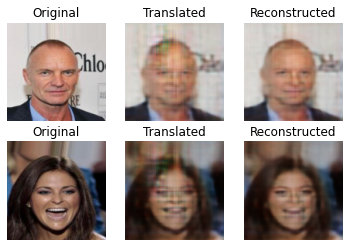

In [ ]:
project_path = '/content/drive/My Drive/hairy_gan'
flags = { 'filter_on': False }
gan = HairyGan(flags)
# gan.pretrain_classifier(num_epochs=100, batch_size=32, visualize_interval=100)
gan.train(num_epochs=100, batch_size=32, visualize_interval=100)

In [ ]:
rows, cols = 2, 3

imgs, attrs = gan.dl.load_data('train_filter', batch_size=2, is_testing=True)

new_attrs = create_random_attrs(attrs)

encodings = gan.enc.predict(imgs)

reconstrs = gan.dec.predict([encodings, attrs])

new_imgs = gan.dec.predict([encodings, new_attrs])
# combined.predict([imgs, attrs, new_attrs]) 

gen_imgs = np.array([imgs[0], new_imgs[0], reconstrs[0], imgs[1], new_imgs[1], reconstrs[1]])

gen_imgs = 0.5 * gen_imgs + 0.5

titles = ['Original', 'Translated', 'Reconstructed']
fig, axes = plt.subplots(rows, cols)

count = 0

for i in range(rows):
  for j in range(cols):
    axes[i, j].imshow(gen_imgs[count])
    axes[i, j].set_title(titles[j])
    axes[i, j].axis('off')
    count += 1

plt.show()

In [ ]:
gan.dc.predict(new_imgs)

In [ ]:
img_paths = glob('/content/celeba-dataset/train_filter/*')
img_paths.sort()
img_paths = img_paths[25:]

og_imgs = []
for path in img_paths:
  img = gan.dl.imread(path)
  img = scipy.misc.imresize(img, (128, 128, 3))
  og_imgs.append(img)

imgs = np.array(og_imgs)/127.5 - 1.
attrs = np.ones((len(imgs), gan.dl.num_attrs))
# new_attrs = create_random_attrs(attrs)
new_attrs = np.zeros(attrs.shape)
new_attrs[:, 2] = 1

encodings = gan.enc.predict(imgs)

reconstrs = gan.dec.predict([encodings, attrs])
reconstrs = (reconstrs + 1) * 127.5

new_imgs = gan.dec.predict([encodings, new_attrs])
new_imgs = (new_imgs + 1) * 127.5

In [ ]:
out = gan.dc.predict(new_imgs)

In [ ]:
Image.fromarray(((imgs[0] + 1) * 127.5).astype(np.uint8))

In [ ]:
Image.fromarray(new_imgs[0].astype(np.uint8))

In [ ]:
out[1]